<a href="https://colab.research.google.com/github/LexMainye/Crypto-Price-Analysis/blob/main/Crypto_Price_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installations

In [ ]:
!pip install wikipedia-api

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=e3f2eff3b78a841f6a1f5b3f40f54f732401d7bb0ac92b59fe47c4dd3f8ef22f
  Stored in directory: /root/.cache/pip/wheels/0b/0f/39/e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia-api


In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 19.9 MB/s eta 0:00:00


In [ ]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install riskfolio-lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.8/314.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 10.1 MB/s eta 0:00:00


In [ ]:
#@title Setting up env and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import yfinance as yf
from datetime import datetime, timedelta
import os
from IPython.display import Image, display


# Mount Google Drive
drive.mount('/content/drive')

# Set style for plots using Seaborn
# plt.style.use('seaborn')  # This line is causing the error
sns.set_theme(style="darkgrid")  # Use Seaborn's set_theme to apply a style like 'darkgrid'
sns.set_palette("husl")

Mounted at /content/drive


# **Crypto Background Information**

In [ ]:
# @title Background information about the crypto currencies being analysed

import wikipediaapi
import time

# Define function to fetch Wikipedia summary with better error handling
def get_wikipedia_summary(crypto_name):
    # Map of crypto names to their Wikipedia page titles (for cases where they differ)
    wiki_name_mapping = {
        "Bitcoin": "Bitcoin",
        "Ethereum": "Ethereum",
        "Cardano": "Cardano (blockchain_platform)",
        "Shiba Inu": "Shiba Inu (cryptocurrency)",
        "Ripple": "Ripple (payment_protocol)",  # Ripple is actually the company, XRP is the cryptocurrency
    }

    # Use mapping if available, otherwise use the original name
    wiki_page_name = wiki_name_mapping.get(crypto_name, crypto_name)

    # Provide a descriptive user agent string
    wiki_wiki = wikipediaapi.Wikipedia(
        language="en",
        user_agent="MyCryptoProject/1.0 (MyProject; myemail@example.com)"
    )

    try:
        page = wiki_wiki.page(wiki_page_name)
        if page.exists():
            return page.summary[:10000] + "..."  # Limit summary to 10000 characters
        else:
            # Try with alternative naming
            alternative_name = crypto_name + " (cryptocurrency)"
            alt_page = wiki_wiki.page(alternative_name)
            if alt_page.exists():
                return alt_page.summary[:500] + "..."
            return f"No Wikipedia page found for {crypto_name}"
    except Exception as e:
        return f"Error fetching data for {crypto_name}: {str(e)}"

# Cryptocurrencies list
cryptos = ["Bitcoin", "Ethereum", "Cardano", "Shiba Inu", "Ripple"]

# Fetch summaries with a small delay to avoid hitting rate limits
crypto_data = {}
for crypto in cryptos:
    crypto_data[crypto] = get_wikipedia_summary(crypto)
    time.sleep(0.5)  # Add a small delay between requests

# Display results
for name, summary in crypto_data.items():
    print(f"{name}:\n{summary}\n{'-'*80}\n")

Bitcoin:
Bitcoin (abbreviation: BTC; sign: ₿) is the first decentralized cryptocurrency. Based on a free-market ideology, bitcoin was invented in 2008 by an unknown entity under the pseudonym of Satoshi Nakamoto. Use of bitcoin as a currency began in 2009, with the release of its open-source implementation.: ch. 1  In 2021, El Salvador adopted it as legal tender. It is mostly seen as an investment and has been described by some scholars as an economic bubble. As bitcoin is pseudonymous, its use by criminals has attracted the attention of regulators, leading to its ban by several countries as of 2021.
Bitcoin works through the collaboration of computers, each of which acts as a node in the peer-to-peer bitcoin network. Each node maintains an independent copy of a public distributed ledger of transactions, called a blockchain, without central oversight. Transactions are validated through the use of cryptography, making it practically impossible for one person to spend another person's bi

# Loading the daily and monthly datasets

In [ ]:
#@title Cryptocurrency Dataset

def load_crypto_data(ticker):
    """Loads data with your specific CSV format, handling variable column counts and specific column renaming"""
    file_path = f'/content/drive/MyDrive/crypto_kes_5year_project/5year_data/{ticker}_5year_daily_data.csv'

    try:
        # Read CSV, skipping the second row (Ticker row) and using third row as header
        df = pd.read_csv(file_path, skiprows=[1], header=1)

        # Remove any empty rows
        df = df.dropna(how='all')

        # Print diagnostic information
        print(f"Columns found in {ticker} data: {df.columns.tolist()}")
        print(f"Number of columns: {len(df.columns)}")
        print(f"First row of data:\n{df.iloc[0]}")

        # Set Date column as index if it exists
        if 'Date' in df.columns:
            df.set_index('Date', inplace=True)
        else:
            print("No 'Date' column found. Using first column as index.")
            df.set_index(df.columns[0], inplace=True)

        # Convert the index to datetime objects
        df.index = pd.to_datetime(df.index)

        # Define renaming dictionary for Unnamed columns
        rename_dict = {
            'Unnamed: 1': 'Close',
            'Unnamed: 2': 'High',
            'Unnamed: 3': 'Low',
            'Unnamed: 4': 'Open',
            'Unnamed: 5': 'Volume'
        }

        # Rename columns if they exist in the DataFrame
        df.rename(columns={k: v for k, v in rename_dict.items() if k in df.columns}, inplace=True)

        # Expected columns
        expected_columns = ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']

        # Check if we have the expected columns after renaming
        current_columns = df.columns.tolist()
        if len(current_columns) == len(expected_columns) and all(col in expected_columns for col in current_columns):
            print("Columns match expected format after renaming.")
        else:
            print(f"Warning: Columns after renaming {current_columns} don't fully match expected {expected_columns}")

        # Convert numeric columns to float
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        return df

    except pd.errors.ParserError:
        print(f"Error reading file: {file_path}. Check file format and column names.")
        return None
    except Exception as e:
        print(f"Unexpected error reading file {file_path}: {str(e)}")
        return None



# Load Bitcoin data
btc = load_crypto_data('btc')
print(f"Loaded {len(btc)} days of BTC data")
print(btc.head())
print(btc.tail())

# Load Cardano data
ada = load_crypto_data('ada')
print(f"Loaded {len(ada)} days of ADA data")
print(ada.head())
print(ada.tail())

# Load Etherium data
eth = load_crypto_data('eth')
print(f"Loaded {len(eth)} days of ETH data")
print(eth.head())
print(eth.tail())

#Load Shiba_Inu data
shib = load_crypto_data('shib')
print(f"Loaded {len(shib)} days of SHIB data")
print(shib.head())
print(shib.tail())

#Load Ripple Data
xrp = load_crypto_data('xrp')
print(f"Loaded {len(xrp)} days of XRP data")
print(xrp.head())
print(xrp.tail())

Columns found in btc data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date           2020-04-02
Unnamed: 1    6793.624512
Unnamed: 2    7088.247559
Unnamed: 3    6595.918457
Unnamed: 4    6606.776367
Unnamed: 5    47660646124
Name: 0, dtype: object
Loaded 1825 days of BTC data
                  Close         High          Low         Open       Volume
Date                                                                       
2020-04-02  6793.624512  7088.247559  6595.918457  6606.776367  47660646124
2020-04-03  6733.387207  7003.220703  6673.335938  6797.396484  38976504903
2020-04-04  6867.527344  6878.953613  6696.484863  6738.382812  33185988584
2020-04-05  6791.129395  6883.414062  6715.929199  6862.537598  29510409856
2020-04-06  7271.781250  7271.781250  6782.889648  6788.049805  46896904615
                   Close          High           Low          Open  \
Date                                        

# **Price Analysis Section**

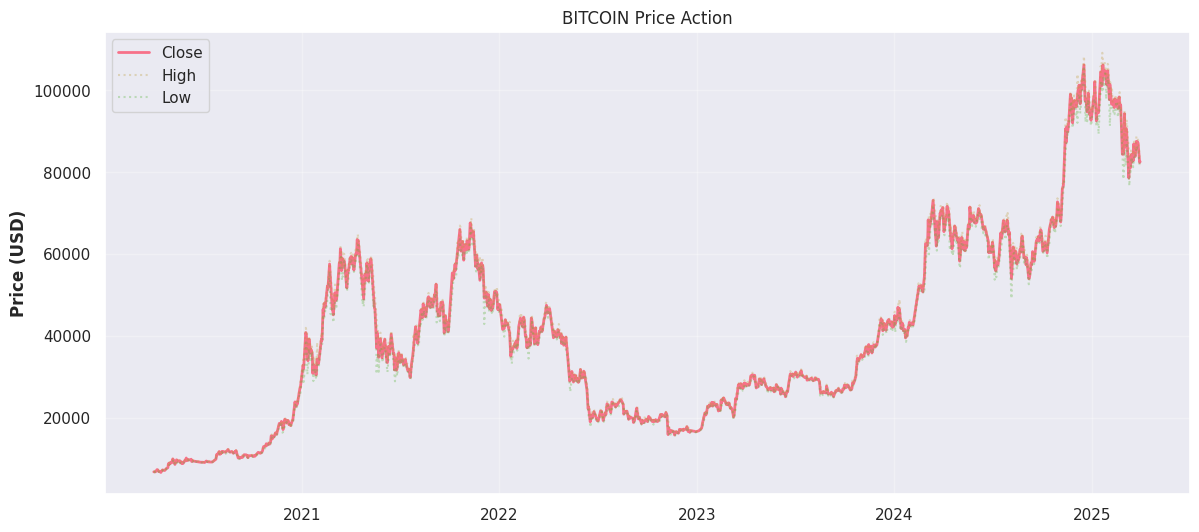

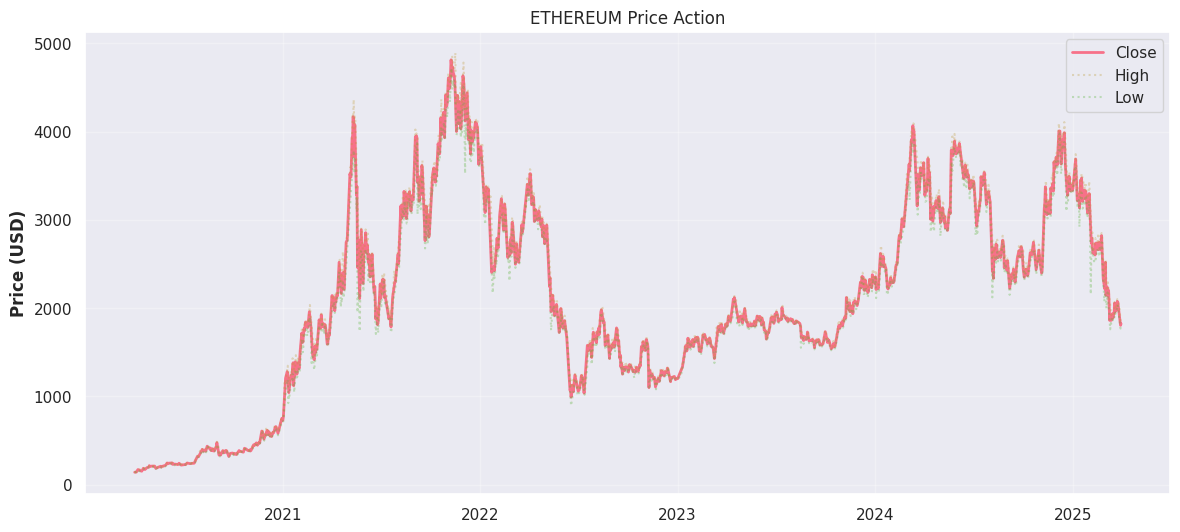

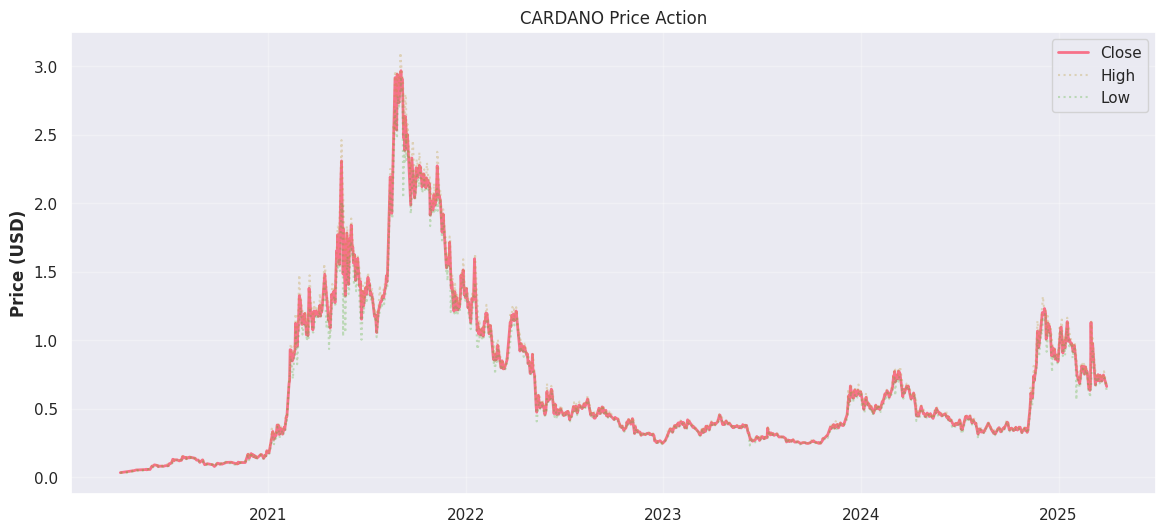

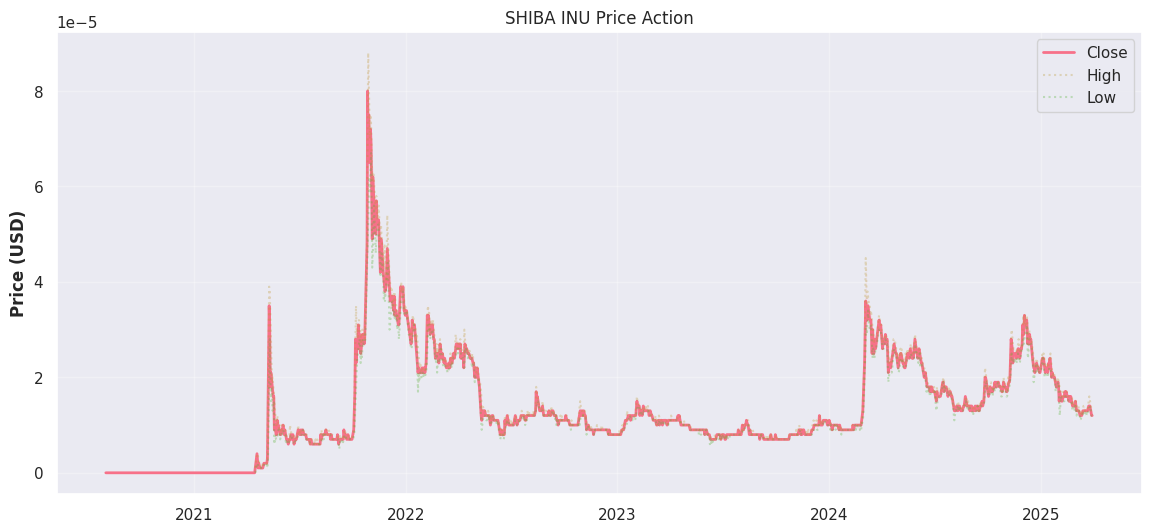

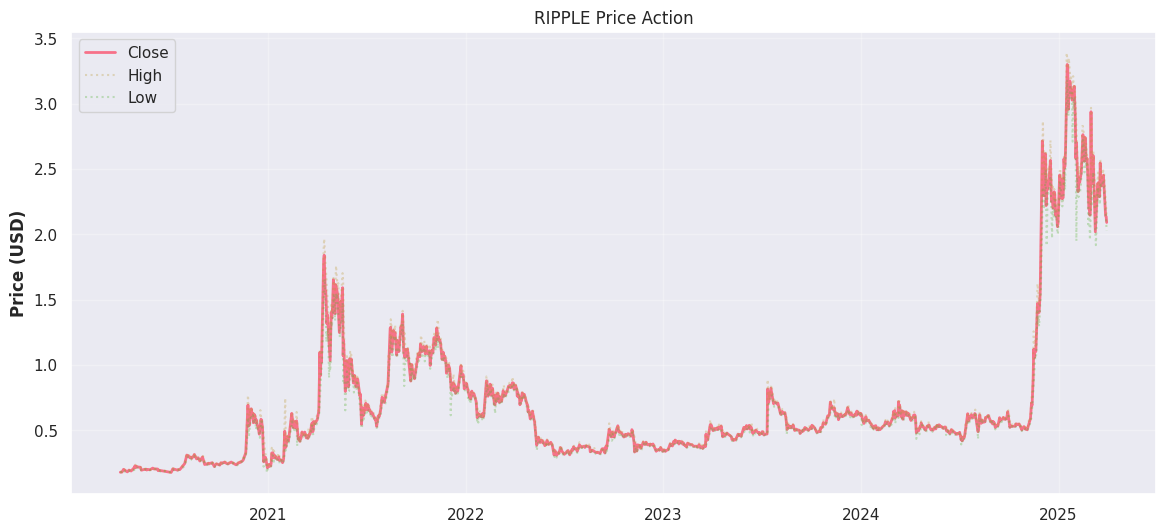

In [ ]:
# @title Price Analysis
def plot_price_comparison(df, title, save_path):
    """Plot OHLC comparison and save as PNG"""
    plt.figure(figsize=(14, 6))
    plt.plot(df['Close'], label='Close', linewidth=2)
    plt.plot(df['High'], alpha=0.3, label='High', linestyle=':')
    plt.plot(df['Low'], alpha=0.3, label='Low', linestyle=':')
    plt.fill_between(df.index, df['Low'], df['High'], alpha=0.1)
    plt.title(f'{title} Price Action')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.show()

    # Create the directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Save the plot as PNG
    file_name = f"{title}_price_action.png"
    file_path = os.path.join(save_path, file_name)
    plt.savefig(file_path)
    plt.close()  # Close the plot to avoid displaying it


# Set the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/Line charts'

# Generate and save the plots
plot_price_comparison(btc, 'Bitcoin'.upper(), save_path)
plot_price_comparison(eth, 'Ethereum'.upper(), save_path)
plot_price_comparison(ada, 'Cardano'.upper(), save_path)
plot_price_comparison(shib, 'Shiba Inu'.upper(), save_path)
plot_price_comparison(xrp, 'Ripple'.upper(), save_path)

**General Observations Across All Cryptocurrencies**
---

1. **Time Period**: The data spans from 2020 to 2025, covering a significant period in the crypto market, including the 2021 bull run, the 2022 bear market, and a potential recovery or new bull run in 2024-2025.

2. **Market Cycles**:
   - **2021 Bull Run🐂**: All cryptocurrencies show a significant price spike in early 2021, reflecting the broader crypto market bull run driven by institutional adoption, retail FOMO (fear of missing out), and macroeconomic factors like low interest rates.

   - **2022 Bear Market🧸**: A sharp decline follows in 2022, likely due to macroeconomic tightening (e.g., rising interest rates), regulatory concerns, and high-profile crypto failures (e.g., Terra-Luna collapse, FTX bankruptcy).

   - **2023 Consolidation 🔄**: Most cryptocurrencies show a period of consolidation or sideways movement in 2023, indicating a lack of strong directional momentum.

   - **2024-2025 Surge 📈**: A strong upward trend emerges in 2024-2025 for most cryptocurrencies, suggesting a new bull market, possibly driven by positive developments like regulatory clarity, Bitcoin ETF approvals, or renewed retail and institutional interest.

3. **Volatility**:
   - The High and Low lines show significant daily price ranges, especially during periods of rapid price movement (e.g., early 2021 and 2024-2025), indicating high volatility.

   - SHIB exhibits the most extreme volatility, with massive spikes and drops, typical of meme coins with smaller market caps and speculative trading.

---
**Individual Analysis of Each Cryptocurrency**

**1. Bitcoin (BTC) Price Action**

- **2020-2021**: BTC starts at around USD 10,000  and surges to nearly USD 65,000 by mid-2021 a classic bull run pattern. The High and Low lines show increased volatility during this period.

- **2022**: A sharp decline brings BTC down to around USD 20,000, reflecting the bear market. Volatility decreases as the price consolidates.

- **2023**: BTC trades sideways between USD 20,000 and USD 30,000, with relatively low volatility.

- **2024-2025**: A massive rally takes BTC to over USD 100,000 by early 2025, with a slight pullback toward the end. This surge aligns with historical Bitcoin halving cycles (the 2024 halving likely contributed to this rally) and potential ETF approvals or institutional adoption.

**2. Ethereum (ETH) Price Action**

- **2020-2021**: ETH rises from around USD 400 to nearly USD 4,800 by mid-2021, following Bitcoin’s lead but with a slightly higher percentage gain, likely due to the growth of DeFi and NFT ecosystems on Ethereum.

- **2022**: ETH drops to around USD 1,000, mirroring the broader market downturn. The Ethereum Merge (transition to Proof of Stake in September 2022) may have introduced some volatility but didn’t prevent the bear market impact.

- **2023**: ETH consolidates between USD 1,000 and USD 2,000, with moderate volatility.

- **2024-2025**: ETH surges to over USD 5,000, with a pullback to around USD 4,000 by early 2025. This rally could be driven by increased adoption of Ethereum-based applications, layer-2 scaling solutions (e.g., Arbitrum, Optimism), and the broader market recovery.

**3. Cardano (ADA) Price Action**

- **2020-2021**: ADA starts at around USD 0.03 and spikes to over USD 3 by mid-2021, a massive gain driven by hype around Cardano’s smart contract rollout (Alonzo hard fork in September 2021).

- **2022-2023**: ADA drops sharply to around $0.3 and consolidates between USD 0.3 and USD 0.5, with low volatility. This period reflects a lack of significant catalysts for Cardano and the broader bear market.

- **2024-2025**: ADA sees a modest rally to around USD 1 by early 2025, but it doesn’t match the explosive growth of BTC or ETH. This suggests Cardano may have underperformed relative to larger cryptocurrencies, possibly due to slower ecosystem growth or competition from other layer-1 blockchains like Solana.

**4. Shiba Inu (SHIB) Price Action**
- **2020-2021**: SHIB starts near USD 0 and spikes dramatically to around USD 0.00008 in late 2021, a classic meme coin pump driven by retail speculation, social media hype, and the broader altcoin season.

- **2022-2023**: SHIB crashes to around USD 0.00001 and trades sideways with occasional smaller spikes (e.g., in 2024). This reflects the speculative nature of meme coins, which often lack fundamental value and are highly sensitive to market sentiment.

- **2024-2025**: SHIB sees another spike to around USD 0.00003, but it remains far below its 2021 peak. This suggests meme coins can still experience pumps during bull markets, but their long-term sustainability is questionable.

**5. Ripple (XRP) Price Action**
- **2020-2021**: XRP starts at around USD 0.2 and spikes to USD 1.8 in early 2021, benefiting from the bull market despite ongoing legal challenges (SEC lawsuit filed in December 2020).

- **2022-2023**: XRP drops to around USD 0.3 and consolidates, with low volatility. The SEC lawsuit likely suppressed XRP’s price, as many exchanges delisted it, reducing liquidity and investor confidence.

- **2024-2025**: XRP experiences a dramatic rally to over USD 3.5 by early 2025, with a pullback to USD 3. This surge likely reflects a resolution of the SEC lawsuit (possibly in 2023 or 2024), renewed exchange listings, and increased adoption of Ripple’s payment solutions by financial institutions.

---

 **Comparative Insights**

1. **Correlation with Bitcoin**:
   - All cryptocurrencies show a strong correlation with Bitcoin’s price movements. When BTC surges (e.g., 2021 and 2024-2025), ETH, ADA, SHIB, and XRP also rise, though with varying magnitudes.
   - During the 2022 bear market, all cryptocurrencies decline, reinforcing Bitcoin’s role as a market leader.

2. **Relative Performance**:
   - **BTC and ETH**: As the largest cryptocurrencies by market cap, they show the most consistent long-term growth, with BTC reaching USD 100,000 and ETH surpassing USD 5,000 by 2025. Their rallies are likely driven by institutional adoption, Bitcoin halving cycles, and Ethereum’s ecosystem growth.

   - **XRP**: XRP’s 2024-2025 surge is the most dramatic in percentage terms (from USD 0.3 to USD 3.5, a 10x increase), likely due to a specific catalyst (e.g., SEC lawsuit resolution). However, its price remains lower than ETH’s in absolute terms.

   - **ADA**: Cardano underperforms relative to BTC, ETH, and XRP, with a more modest rally to USD 1. This suggests Cardano may have lost momentum compared to competitors.

   - **SHIB**: Shiba Inu shows the most extreme volatility, with massive spikes and crashes. Its price remains very low (in the USD 0.00001- USD 0.00003 range), reflecting its speculative nature and lack of fundamental value compared to the others.

3. **Volatility Patterns**:
   - SHIB exhibits the highest volatility, with extreme spikes in 2021 and 2024, typical of meme coins.
   - BTC and ETH show moderate volatility, with larger daily ranges during bull runs (2021, 2024-2025) but more stability during consolidation (2023).
   - XRP and ADA show lower volatility during 2022-2023, likely due to regulatory uncertainty (XRP) and lack of catalysts (ADA).

4. **2024-2025 Bull Run**:
   - The 2024-2025 period is a clear bull market for all cryptocurrencies, but the magnitude varies:
     - BTC: +400% (from USD 20,000 to USD 100,000)
     - ETH: +400% (from USD 1,000 to USD 5,000)
     - XRP: +1000% (from USD 0.3 to USD 3.5)
     - ADA: +200% (from USD 0.3 to USD 1)
     - SHIB: +200% (from USD 0.00001 to USD 0.00003)
   - XRP’s outsized gain suggests a unique catalyst, while BTC and ETH benefit from broader market trends. ADA and SHIB lag in relative terms, indicating weaker fundamentals or market interest.

5. **Regulatory Impact**:
   - XRP’s price action is heavily influenced by the SEC lawsuit. The 2022-2023 consolidation and 2024-2025 surge align with the timeline of legal developments (e.g., a favorable ruling or settlement in 2023-2024).
   - Other cryptocurrencies (BTC, ETH) are less affected by regulatory concerns, as they are more established and often classified as commodities rather than securities.

---

**Broader Market Insights**

1. **Market Sentiment**:

   - The 2021 bull run reflects peak market euphoria, with retail and institutional investors driving prices to all-time highs.

   - The 2022 bear market shows a shift to risk-off sentiment, likely due to macroeconomic factors (e.g., Federal Reserve rate hikes, inflation concerns) and crypto-specific events (e.g., FTX collapse).

   - The 2024-2025 rally indicates renewed optimism, possibly driven by:
     - Bitcoin halving (April 2024), which historically precedes bull runs.
     - Regulatory clarity (e.g., XRP lawsuit resolution, potential SEC approval of Bitcoin ETFs).
     - Macroeconomic shifts (e.g., potential rate cuts in 2024-2025, making risk assets like crypto more attractive).

2. **Adoption and Fundamentals**:
   - **BTC**: As the market leader, Bitcoin benefits from its store-of-value narrative and institutional adoption (e.g., Bitcoin ETFs, corporate treasury allocations like MicroStrategy).

   - **ETH**: Ethereum’s growth is tied to its ecosystem (DeFi, NFTs, layer-2 solutions), making it a fundamental driver of the crypto space.

   - **XRP**: Ripple’s focus on cross-border payments likely contributed to its 2024-2025 surge, especially if financial institutions increased adoption post-lawsuit.

   - **ADA**: Cardano’s slower growth suggests challenges in ecosystem adoption, despite its focus on scalability and sustainability.

   - **SHIB**: Shiba Inu’s price action is purely speculative, driven by retail hype rather than fundamentals.

3. **Investment Implications**:

   - **BTC and ETH** are the most stable long-term investments, with consistent growth and lower risk compared to altcoins.

   - **XRP** shows high potential for outsized gains but also higher risk due to regulatory uncertainty.

   - **ADA** may appeal to long-term holders betting on future ecosystem growth, but it has underperformed in this period.

   - **SHIB** is a high-risk, high-reward speculative asset, suitable only for traders comfortable with extreme volatility.

---
**Conclusion**

The plots collectively show a crypto market that follows distinct cycles: a 2021 bull run, a 2022 bear market, a 2023 consolidation, and a 2024-2025 bull run. Bitcoin and Ethereum lead the market with consistent growth, while XRP shows the most dramatic recovery, likely due to regulatory clarity. Cardano underperforms, and Shiba Inu remains a volatile meme coin. These patterns highlight the importance of market sentiment, regulatory developments, and fundamental adoption in driving cryptocurrency prices. For investors, BTC and ETH offer stability, XRP offers high potential with regulatory risk, and SHIB and ADA cater to more speculative or long-term strategies.

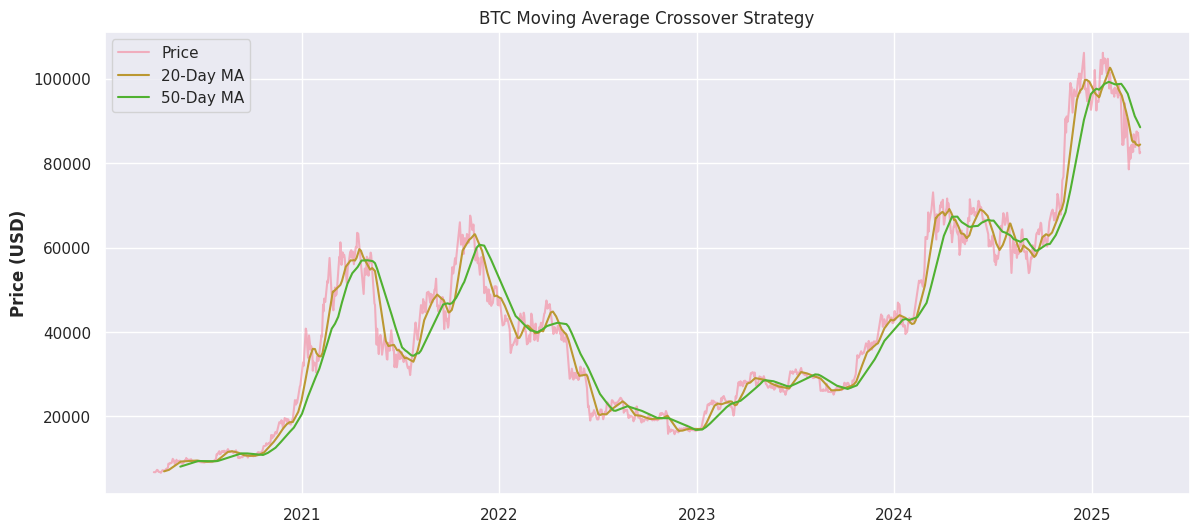

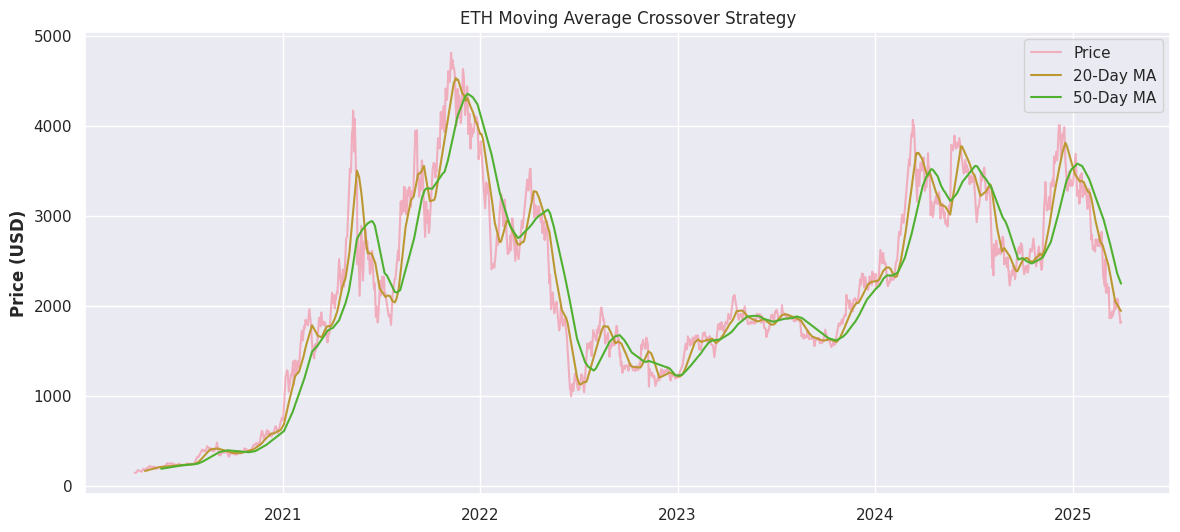

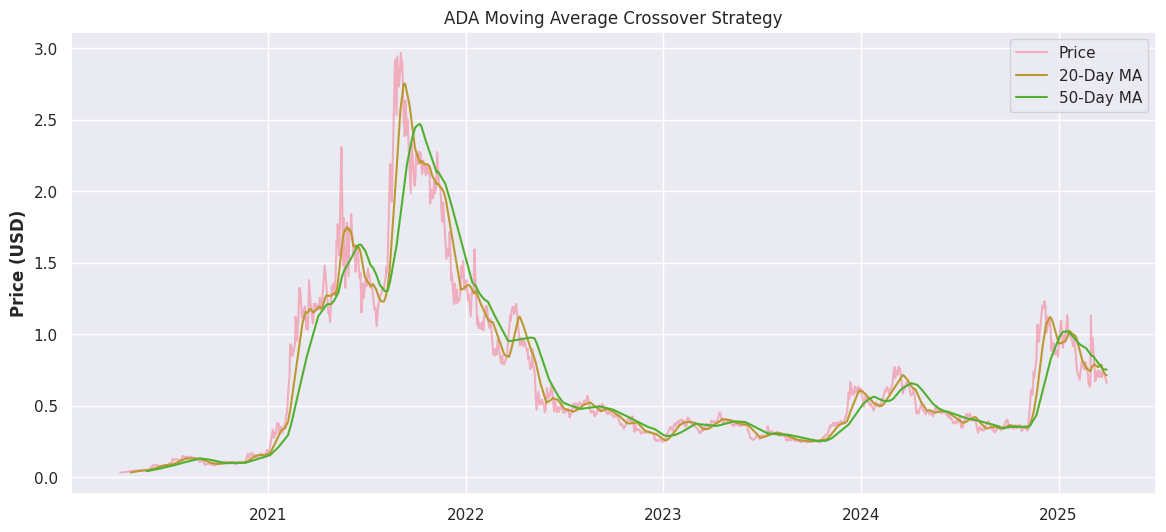

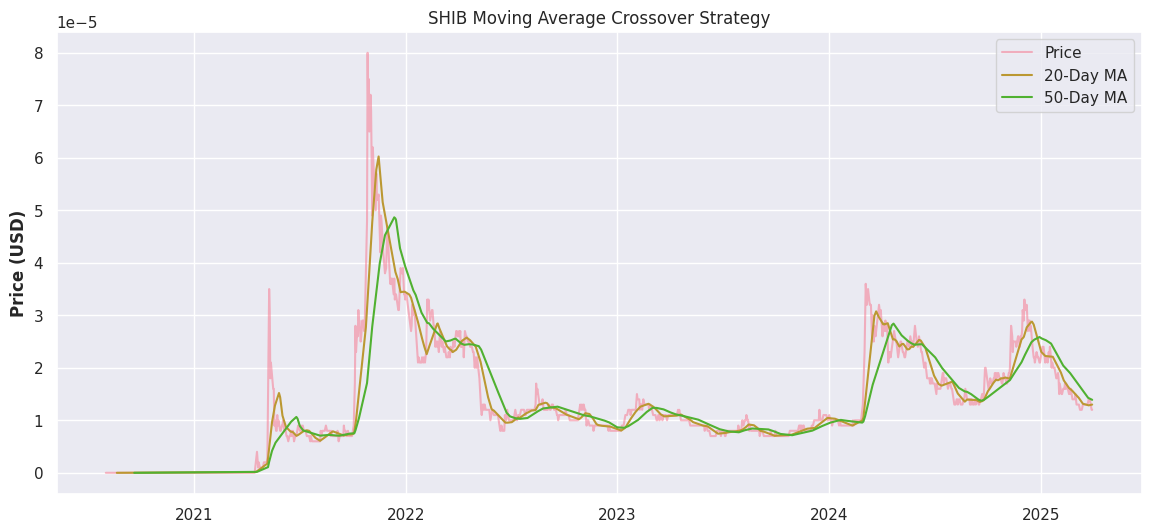

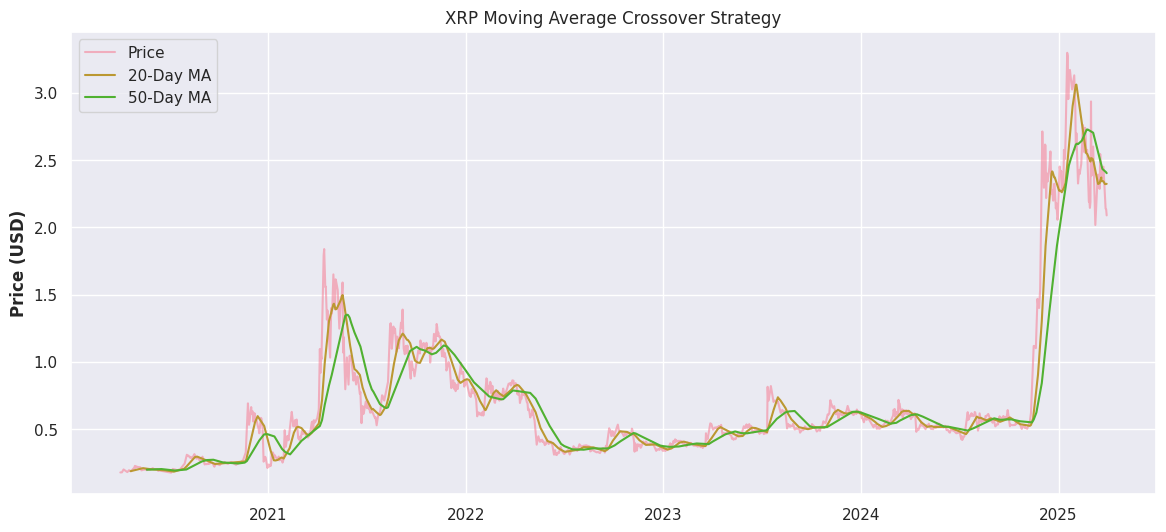

In [ ]:
# @title Moving Average

def analyze_moving_average(df, ticker, save_path_base='/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/Moving Average'):
    """Calculates and plots moving averages, saving the plot to the 'moving average' folder."""

    def plot_moving_average_crossover(df, ticker, save_path):
        """Calculates and plots moving averages, saving the plot."""
        df['MA_20'] = df['Close'].rolling(20).mean()
        df['MA_50'] = df['Close'].rolling(50).mean()

        plt.figure(figsize=(14, 6))
        plt.plot(df['Close'], label='Price', alpha=0.5)
        plt.plot(df['MA_20'], label='20-Day MA')
        plt.plot(df['MA_50'], label='50-Day MA')
        plt.title(f'{ticker.upper()} Moving Average Crossover Strategy')
        plt.legend()

         # Add y-axis label for price
        plt.ylabel('Price (USD)')

        plt.show()

        # Create the directory if it doesn't exist
        os.makedirs(save_path, exist_ok=True)

        # Save the plot as PNG
        file_name = f"{ticker}_moving_average_crossover.png"
        file_path = os.path.join(save_path, file_name)
        plt.savefig(file_path)
        plt.close()

    # Define save path for moving average plots
    save_path_moving_average = os.path.join(save_path_base, 'moving average')

    # Call the moving average plotting function
    plot_moving_average_crossover(df, ticker, save_path_moving_average)


# Usage:
analyze_moving_average(btc, 'BTC')
analyze_moving_average(eth, 'ETH')
analyze_moving_average(ada, 'ADA')
analyze_moving_average(shib,'SHIB')
analyze_moving_average(xrp, 'XRP')


**Analysis of Moving Average Crossovers**
---

**Bitcoin (BTC)**

- **Price Action**:
  - 2020-2021: BTC rises from 10,000 USD to 65,000 USD, drops to 20,000 USD in 2022, consolidates in 2023, and surges to 100,000 USD by 2025.

- **MA Crossovers**:
  - **Bullish Crossovers**: Early 2021 (20-day MA crosses above 50-day MA) signals the bull run; mid-2023 marks the start of the 2024-2025 rally.

  - **Bearish Crossovers**: Mid-2021 (20-day MA crosses below 50-day MA) signals the 2022 bear market; late 2025 indicates a potential pullback
  .
- **Insight**: BTC’s MA crossovers reliably identify major trends, with bullish crossovers preceding significant rallies and bearish crossovers signaling downturns.

**Ethereum (ETH)**
- **Price Action**:
  - 2020-2021: ETH rises from 400 USD to 4,800 USD, drops to 1,000 USD in 2022, consolidates in 2023, and rallies to 5,000 USD by 2025.

- **MA Crossovers**:
  - **Bullish Crossovers**: Early 2021 signals the bull run; mid-2023 precedes the 2024-2025 rally.

  - **Bearish Crossovers**: Mid-2021 marks the 2022 decline; late 2025 suggests a correction.

- **Insight**: ETH’s crossovers align closely with BTC’s, reflecting their market correlation. The strategy effectively captures ETH’s major trends, though with slightly higher volatility than BTC.

**Cardano (ADA)**
- **Price Action**:
  - 2020-2021: ADA spikes from 0.03 USD to 3 USD, drops to 0.3 USD in 2022, consolidates in 2023, and rises to 1 USD by 2025.

- **MA Crossovers**:
  - **Bullish Crossovers**: Early 2021 signals the spike; mid-2024 precedes a modest rally.

  - **Bearish Crossovers**: Mid-2021 marks the decline; no significant bearish crossover in 2025, indicating a weaker pullback.

- **Insight**: ADA’s crossovers are less pronounced in the 2024-2025 rally, reflecting its underperformance compared to BTC and ETH. The strategy is less effective for ADA due to prolonged consolidation periods.

**Shiba Inu (SHIB)**
- **Price Action**:
  - 2020-2021: SHIB spikes from near 0 USD to 0.00008 USD, crashes to 0.00001 USD in 2022, and rises to 0.00003 USD by 2025 with intermittent spikes.

- **MA Crossovers**:
  - **Bullish Crossovers**: Early 2021 and mid-2024 signal SHIB’s explosive pumps.

  - **Bearish Crossovers**: Late 2021 marks the crash; late 2025 indicates a pullback.

- **Insight**: SHIB’s extreme volatility makes MA crossovers less reliable, as they often lag behind rapid price spikes and crashes. The strategy captures major trends but struggles with SHIB’s speculative nature.

**Ripple (XRP)**
- **Price Action**:
  - 2020-2021: XRP rises from 0.2 USD to 1.8 USD, drops to 0.3 USD in 2022, consolidates in 2023, and surges to 3.5 USD by 2025.
- **MA Crossovers**:
  - **Bullish Crossovers**: Early 2021 signals the initial spike; mid-2024 precedes the dramatic 2024-2025 rally.
  - **Bearish Crossovers**: Mid-2021 marks the decline; late 2025 suggests a correction.
- **Insight**: XRP’s crossovers are highly effective, especially for the 2024-2025 rally, likely driven by the SEC lawsuit resolution. The strategy captures XRP’s major trend shifts well.

---

**Comparative Insights**

- **Effectiveness of MA Strategy**:
  - **BTC and ETH**: The MA crossover strategy works well, reliably signaling major bull and bear trends due to their more stable price movements.
  - **XRP**: The strategy is effective, particularly for the 2024-2025 surge, reflecting XRP’s strong trend driven by a specific catalyst (SEC lawsuit resolution).
  - **ADA**: The strategy is less effective due to prolonged consolidation and weaker trends, missing some of ADA’s smaller price movements.
  - **SHIB**: The strategy struggles with SHIB’s extreme volatility, often lagging behind rapid pumps and dumps.
- **Volatility Impact**:
  - SHIB’s high volatility leads to frequent but less reliable crossovers.
  - BTC and ETH show smoother crossovers, aligning with their lower volatility.
  - XRP and ADA fall in between, with XRP showing clearer signals during major trends.

- **Market Correlation**:
  - Bullish crossovers in 2021 and 2024-2025 occur simultaneously across all cryptocurrencies, reflecting their correlation with BTC’s market leadership.
  - Bearish crossovers in 2021 and 2025 also align, indicating synchronized market downturns.

---

**Conclusion**

The moving average crossover strategy effectively identifies major trends for BTC, ETH, and XRP, with bullish crossovers signaling the 2021 and 2024-2025 rallies, and bearish crossovers marking the 2022 decline and 2025 pullbacks. It is less reliable for ADA due to weaker trends and struggles with SHIB’s extreme volatility. BTC and ETH benefit from smoother price action, while XRP’s crossovers highlight its 2024-2025 surge. Traders should use this strategy cautiously with volatile assets like SHIB and consider additional indicators for ADA.

Columns found in btc data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date           2020-04-02
Unnamed: 1    6793.624512
Unnamed: 2    7088.247559
Unnamed: 3    6595.918457
Unnamed: 4    6606.776367
Unnamed: 5    47660646124
Name: 0, dtype: object
Columns found in eth data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date           2020-04-02
Unnamed: 1     142.029144
Unnamed: 2     146.787094
Unnamed: 3     135.732178
Unnamed: 4     135.732178
Unnamed: 5    15322861686
Name: 0, dtype: object
Columns found in ada data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date          2020-04-02
Unnamed: 1      0.031984
Unnamed: 2      0.033057
Unnamed: 3      0.030841
Unnamed: 4      0.030841
Unnamed: 5     106987595
Name: 0, dtype: object
Columns found in xrp data: ['Da

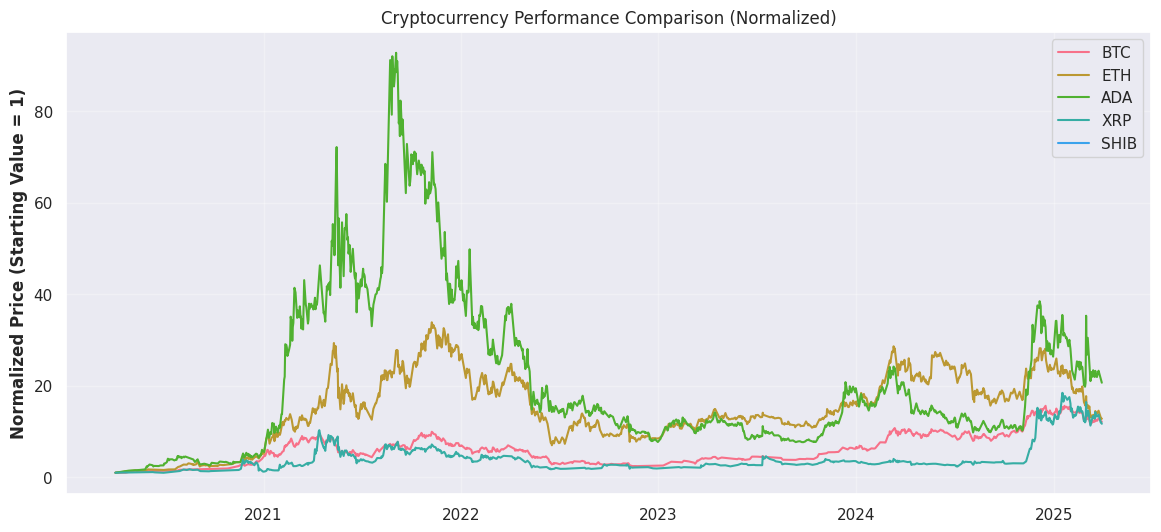

In [ ]:
#@title Comparative Analysis (Multiple Cryptos)

def compare_cryptos(tickers, save_path):  # Added save_path parameter
    """Compare multiple cryptocurrencies and save the plot."""
    plt.figure(figsize=(14, 6))

    for ticker in tickers:
        df = load_crypto_data(ticker)
        # Check if df is None before proceeding
        if df is not None:
            norm_price = df['Close'] / df['Close'].iloc[0]  # Normalize to starting price
            plt.plot(norm_price, label=ticker.upper())
        else:
            print(f"Warning: Could not load data for {ticker.upper()}. Skipping.")

    plt.title('Cryptocurrency Performance Comparison (Normalized)')
    plt.ylabel('Normalized Price (Starting Value = 1)')
    plt.legend()
    plt.grid(alpha=0.3)

    # --- Save the plot ---
    os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist
    file_path = os.path.join(save_path, 'crypto_performance_comparison.png')
    plt.savefig(file_path)
    # --- End of saving ---

    plt.show()

# Set the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/crypto performance'

# Call the function with the save path
compare_cryptos(['btc', 'eth', 'ada', 'xrp', 'shib'], save_path)

**Key Trends**
---

- **2020-2021 Bull Run**:
  - SHIB peaks at 80x (8000% gain), driven by retail hype.
  - ETH reaches 60x (6000%), fueled by DeFi/NFT growth.
  - ADA hits 40x (4000%), boosted by smart contract hype.
  - BTC and XRP rise to 10x and 15x, respectively, showing more modest gains as larger assets.

- **2022 Bear Market**:
  - All cryptocurrencies decline sharply.
  - SHIB drops to 5x (90%+ drawdown from peak).
  - ETH, ADA, and XRP fall to 5-10x; BTC holds at 5x, showing resilience.

- **2023 Consolidation**:
  - Prices stabilize with low volatility, ranging between 5x and 10x for most assets.

- **2024-2025 Surge**:
  - XRP leads at 25x (2500% gain), likely due to SEC lawsuit resolution.
  - SHIB reaches 20x, ETH and ADA hit 15x, and BTC rises to 10x.

**Comparative Insights**

- **Volatility**:
  - SHIB is the most volatile, with extreme spikes (80x) and crashes.
  - BTC is the least volatile, with steady growth (10x).
  - XRP, ETH, and ADA show moderate volatility, with XRP’s 2024-2025 surge standing out.

- **Correlation**:
  - All cryptocurrencies move in tandem with BTC, reflecting its role as the market leader.

- **Performance**:
  - XRP outperforms by 2025 (25x), followed by SHIB (20x), ETH/ADA (15x), and BTC (10x).
  - SHIB’s gains are speculative; XRP’s surge likely reflects regulatory clarity; ETH’s growth is fundamental.

**Implications**
- **Market Cycles**: The plot shows clear cycles: 2021 bull run, 2022 bear market, 2023 consolidation, and 2024-2025 bull run (possibly driven by Bitcoin halving, regulatory clarity, or macro shifts).
- **Risk-Return**:
  - SHIB: High risk, high reward (80x peak, 90%+ drawdowns).
  - XRP: High potential (25x), moderate risk post-lawsuit.
  - ETH/ADA: Balanced growth (15x), moderate risk.
  - BTC: Stable growth (10x), lowest risk.
  
- **Investment**: BTC and ETH suit conservative investors; XRP offers high potential with regulatory risk; SHIB is speculative; ADA lags despite fundamentals.

**Conclusion**

The plot highlights the crypto market’s cyclical nature and varying risk profiles: SHIB is the most volatile, XRP surges post-2023, ETH and ADA offer balanced growth, and BTC remains the steadiest. Investors should align choices with risk tolerance, noting BTC’s market leadership and altcoins’ higher volatility.

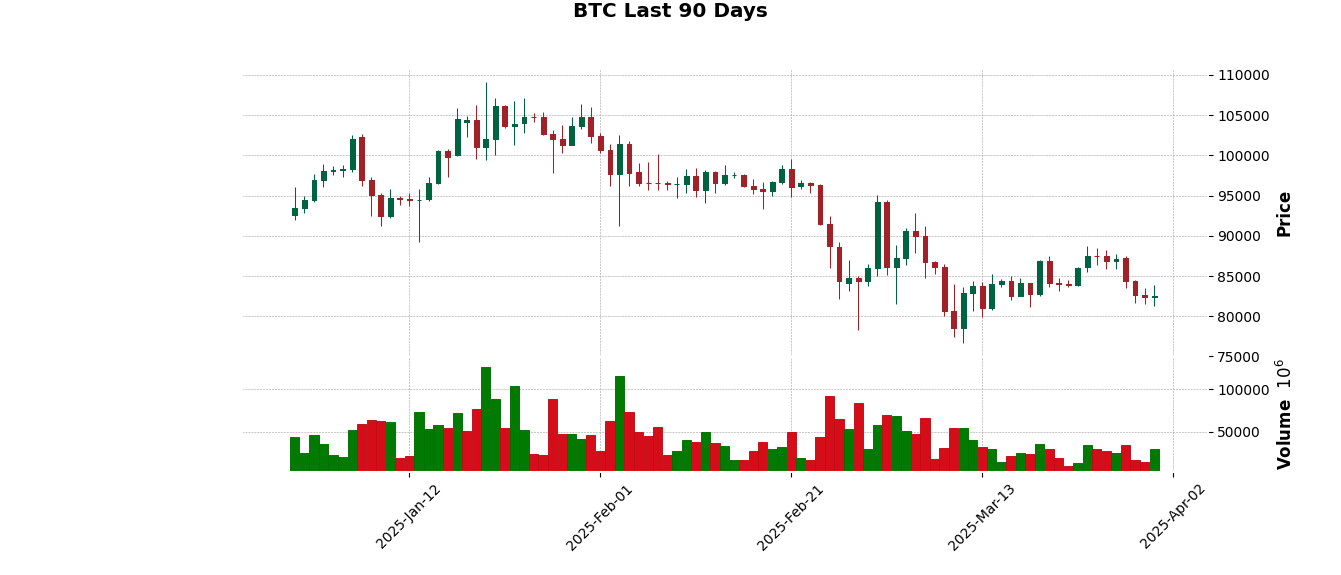

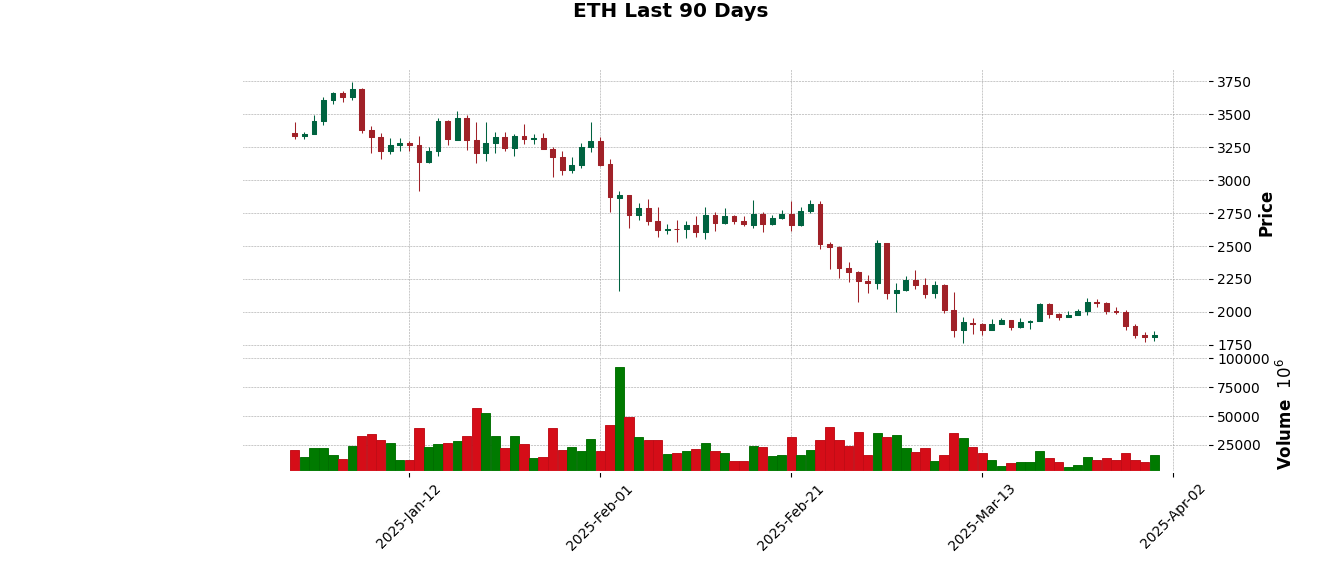

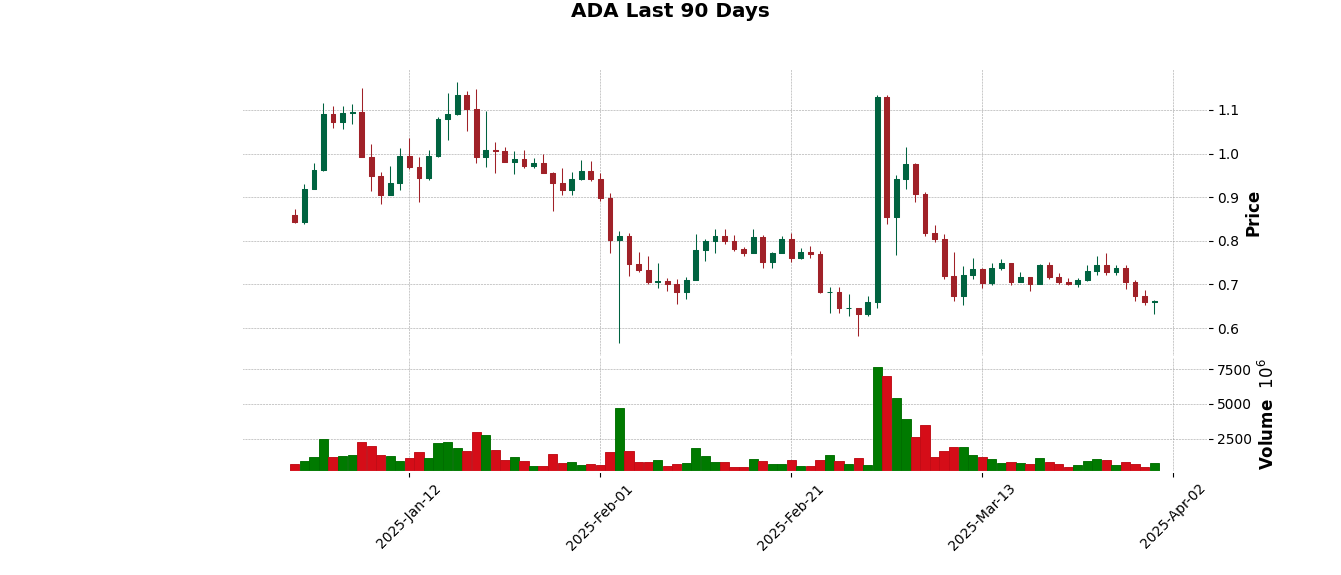

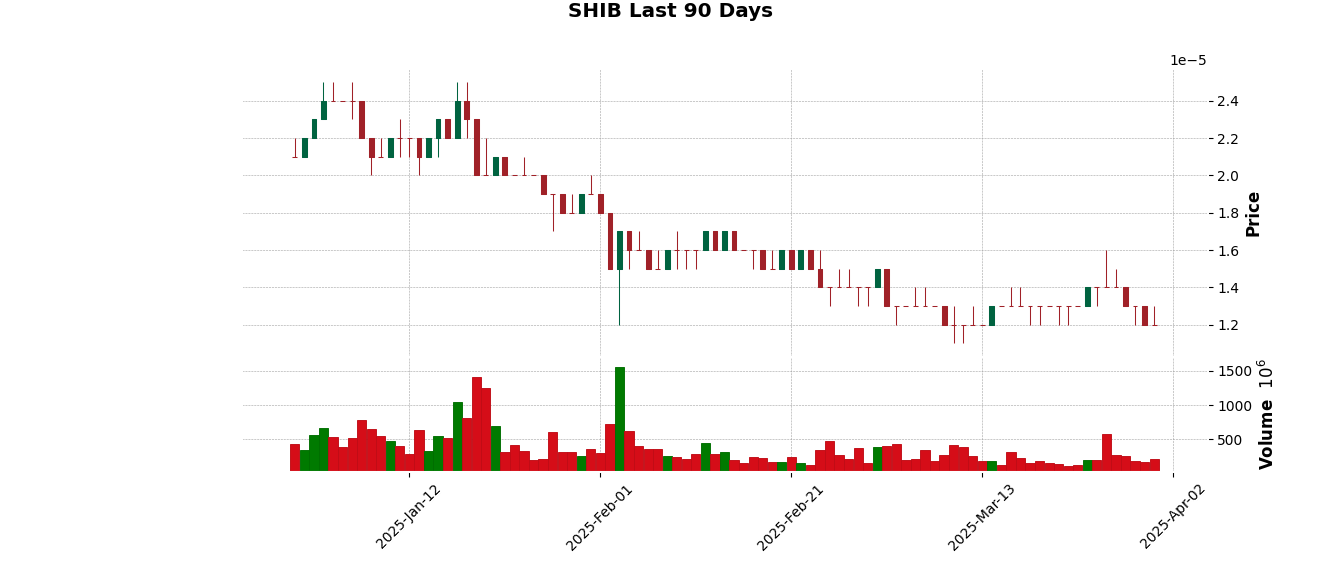

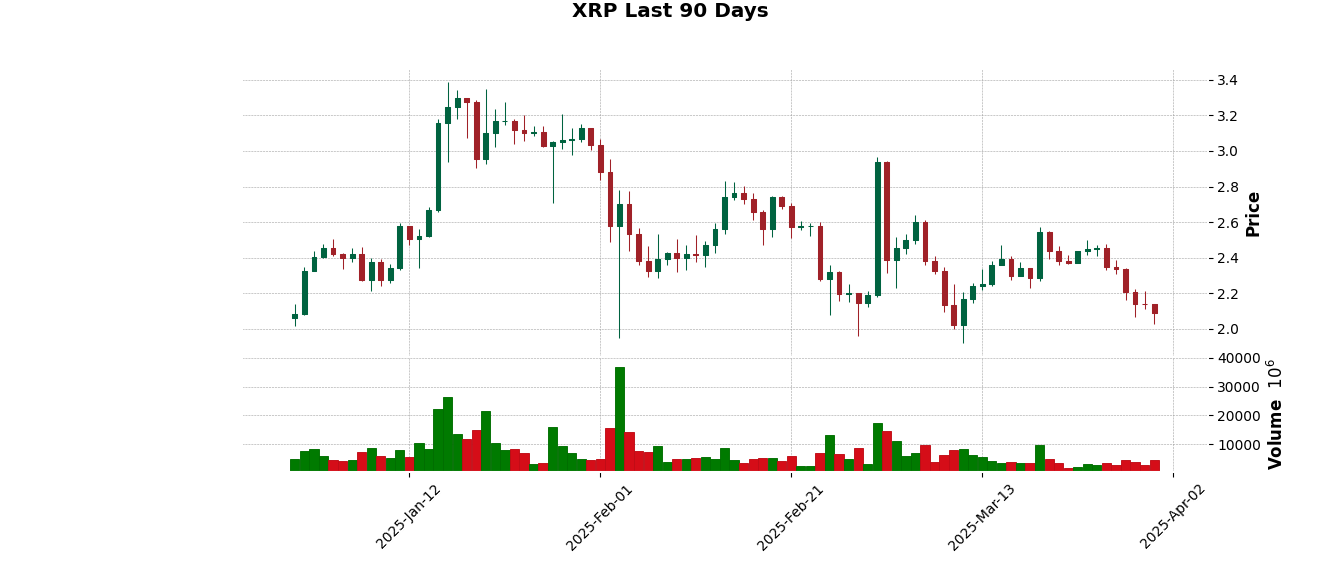

In [ ]:
# @title Candlestick Charts
import mplfinance as mpf

def plot_candlestick_chart(df, ticker, save_path):
    """Plots a candlestick chart, shows it in the output, and saves it to the specified path."""

    # Prepare DataFrame for mplfinance
    df_ohlc = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    df_ohlc.columns = ['open', 'high', 'low', 'close', 'volume']  # mplfinance expects lowercase

    # Calculate the date 90 days ago
    ninety_days_ago = df_ohlc.index[-1] - pd.DateOffset(days=90)

    # Filter data for the last 90 days using .loc
    df_ohlc_90d = df_ohlc.loc[ninety_days_ago:]

    # Create the directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Save the plot as PNG
    file_name = f"{ticker}_candlestick_chart.png"
    file_path = os.path.join(save_path, file_name)

      # Plot using the filtered DataFrame
    mpf.plot(df_ohlc_90d,
            type='candle',
            style='charles',
            volume=True,
            title=f'{ticker} Last 90 Days',
            figratio=(14,6),
            savefig=dict(fname=file_path, dpi=100, pad_inches=0.25),
            show_nontrading=True
           )

# Set the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/candlestick charts'

# Plot and save the charts for each cryptocurrency
plot_candlestick_chart(btc, 'BTC', save_path)
plot_candlestick_chart(eth, 'ETH', save_path)
plot_candlestick_chart(ada, 'ADA', save_path)
plot_candlestick_chart(shib, 'SHIB', save_path)
plot_candlestick_chart(xrp, 'XRP', save_path)

folder_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/candlestick charts'

for filename in os.listdir(folder_path):
  if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Check for image file extensions
    image_path = os.path.join(folder_path, filename)
    display(Image(filename=image_path))

**Analysis of Each Cryptocurrency**
---

**Cardano (ADA)**
- **Price Action**:
  - Starts at 1.0 USD, fluctuates between 0.9 USD and 1.1 USD until mid-March, then drops sharply to 0.6 USD by late March, and slightly recovers to 0.7 USD by April 2.

- **Volume**:
  - Volume spikes in mid-March (around 7500 units) during the sharp decline, with more red bars indicating heavy selling pressure.
  - Volume decreases post-drop, with mixed buying and selling.

- **Insight**: ADA experiences a significant sell-off in mid-March, likely due to market-wide bearish sentiment, with limited recovery afterward.

**Bitcoin (BTC)**
- **Price Action**:
  - Starts at 105,000 USD, peaks at 111,000 USD in late January, consolidates between 100,000 USD and 105,000 USD until mid-March, then drops to 85,000 USD by April 2.

- **Volume**:
  - Volume peaks in mid-March (around 100,000 units) during the decline, with more red bars showing strong selling.

  - Volume remains elevated during the consolidation phase, with mixed buying and selling.

- **Insight**: BTC shows a steady decline after early consolidation, with high selling volume in mid-March, reflecting a broader market correction.

**Ethereum (ETH)**
- **Price Action**:
  - Starts at 3750 USD, drops to 3000 USD by late January, consolidates between 2750 USD and 3000 USD until mid-March, then falls to 2000 USD by April 2.

- **Volume**:
  - Volume spikes in late January and mid-March (around 175,000 units) during price drops, with more red bars indicating selling pressure.

  - Volume decreases toward April, with balanced buying and selling.

- **Insight**: ETH experiences two significant drops, with high selling volume, suggesting bearish sentiment and profit-taking after a prior rally.

**Shiba Inu (SHIB)**
- **Price Action**:
  - Starts at 0.000024 USD, drops to 0.000018 USD by late January, consolidates between 0.000014 USD and 0.000018 USD until mid-March, then falls to 0.000012 USD by April 2.

- **Volume**:
  - Volume spikes in late January and mid-March (around 1500 units) during price drops, with more red bars showing selling.
  - Volume remains low during consolidation, with mixed buying and selling.

- **Insight**: SHIB’s price action mirrors the broader market, with sharp drops and high selling volume, reflecting its speculative nature and sensitivity to market sentiment.

**Ripple (XRP)**
- **Price Action**:
  - Starts at 3.2 USD, peaks at 3.4 USD in late January, consolidates between 2.8 USD and 3.2 USD until mid-March, then drops to 2.2 USD by April 2.

- **Volume**:
  - Volume spikes in mid-March (around 40,000 units) during the decline, with more red bars indicating heavy selling.

  - Volume decreases post-drop, with balanced buying and selling.

- **Insight**: XRP follows a similar pattern to others, with a significant sell-off in mid-March, likely tied to market-wide bearish trends, despite its prior strong rally.

---

**Comparative Insights**
- **Price Trends**:
  - All cryptocurrencies experience a similar pattern: consolidation or slight gains in January-February, followed by a sharp decline in mid-March, and a partial recovery or continued decline by April 2.

  - **BTC and ETH** show the largest absolute price drops (26,000 USD and 1750 USD, respectively), reflecting their higher price levels, but their percentage drops (23% for BTC, 47% for ETH) are less severe than SHIB’s (50%).

  - **SHIB** exhibits the highest percentage drop (50%), highlighting its volatility as a meme coin.

  - **ADA** and **XRP** have moderate percentage drops (30% and 31%, respectively), showing relative stability compared to SHIB but more volatility than BTC.

- **Volume Patterns**:
  - Volume spikes across all cryptocurrencies in mid-March, coinciding with the sharp price declines, with predominantly red bars indicating heavy selling pressure.

  - **BTC** and **ETH** have the highest absolute volume (100,000 and 175,000 units), reflecting their larger market caps and trading activity.

  - **SHIB** has the lowest volume (1500 units), consistent with its smaller market cap, but its volume spikes are significant relative to its baseline, showing speculative trading.

  - **ADA** and **XRP** have moderate volume spikes (7500 and 40,000 units), indicating active trading during the sell-off.

- **Market Correlation**:
  - The synchronized price drops in mid-March across all cryptocurrencies suggest a market-wide correction, possibly driven by macroeconomic factors (e.g., interest rate expectations) or crypto-specific events (e.g., regulatory news).

  - **BTC**, as the market leader, likely influences the others, with its decline triggering sell-offs in ETH, ADA, SHIB, and XRP.

- **Volatility**:
  - **SHIB** is the most volatile, with a 50% drop and rapid price swings, typical of meme coins.

  - **ETH** shows high volatility (47% drop), reflecting its sensitivity to market sentiment and profit-taking after a prior rally.

  - **BTC**, **ADA**, and **XRP** are less volatile (23%-31% drops), with BTC being the most stable due to its larger market cap and institutional backing.

---

**Conclusion**

The candlestick charts reveal a bearish trend across all cryptocurrencies over the last 90 days, with a significant sell-off in mid-March 2025, driven by high selling volume. BTC and ETH exhibit the largest absolute price drops but are relatively stable in percentage terms, while SHIB shows the highest volatility with a 50% drop. ADA and XRP fall in between, with moderate declines. The synchronized price action and volume spikes indicate a market-wide correction, with BTC leading the trend. Traders should monitor for potential recovery signals, as the partial rebound in ADA and XRP suggests some buying interest, while SHIB’s volatility warrants caution.

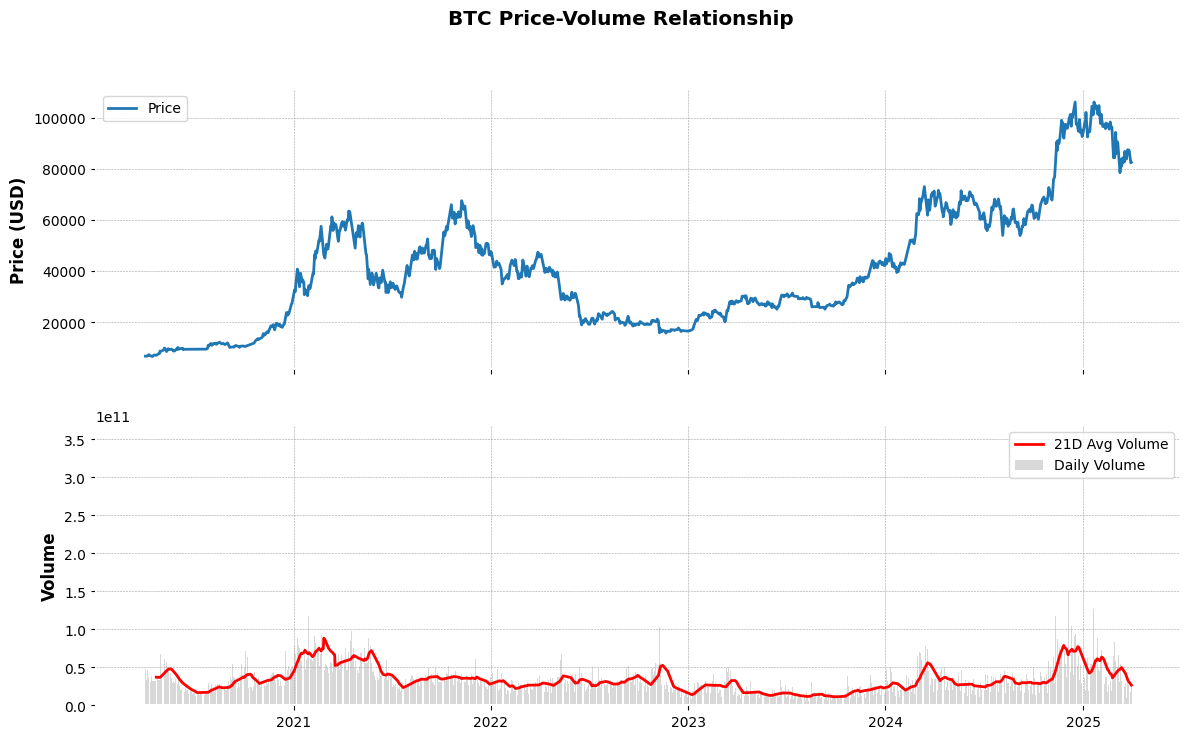

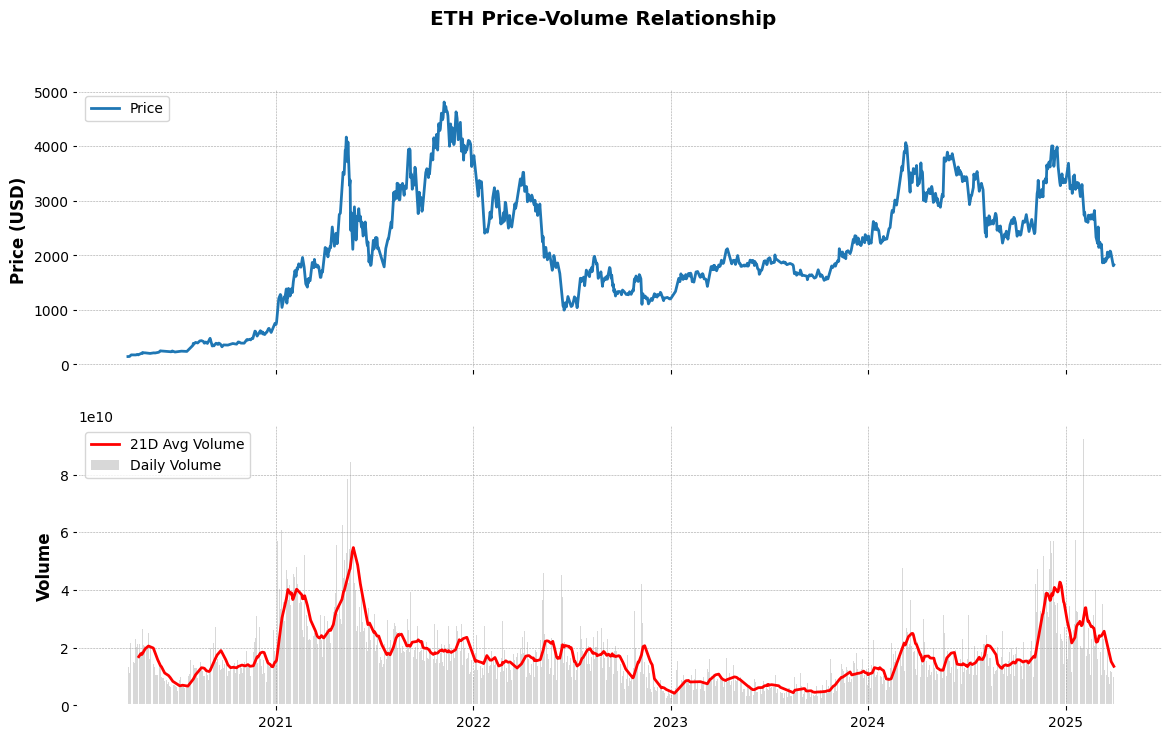

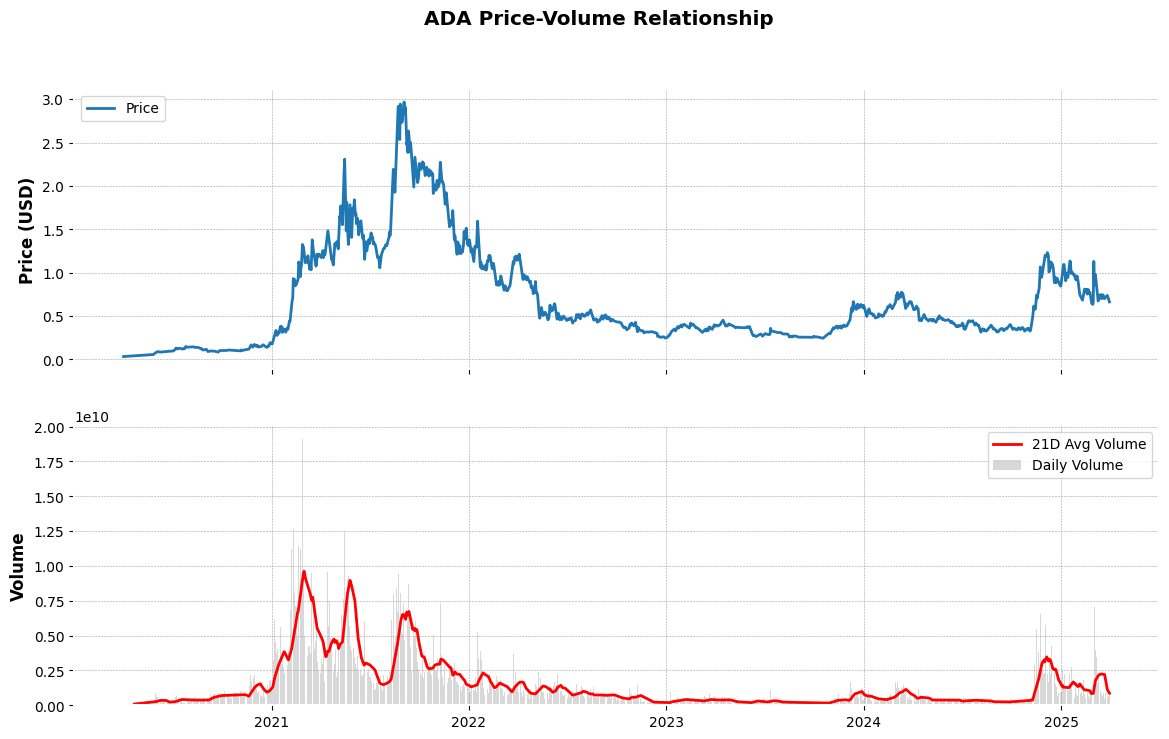

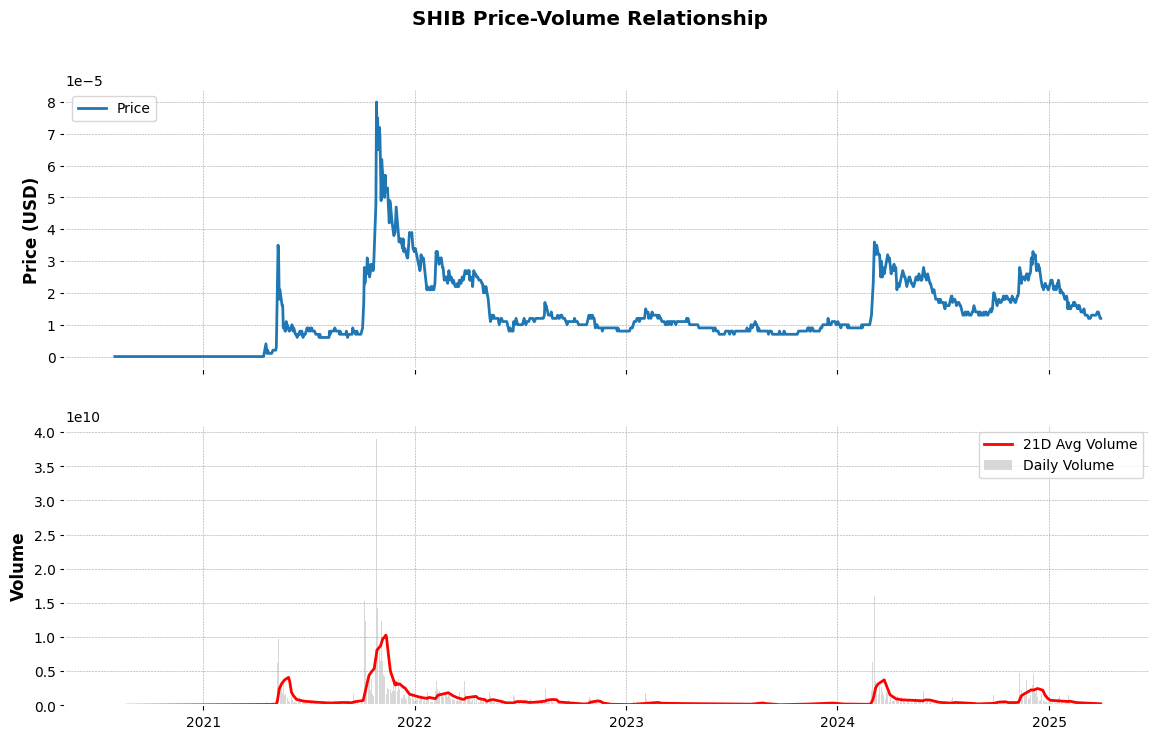

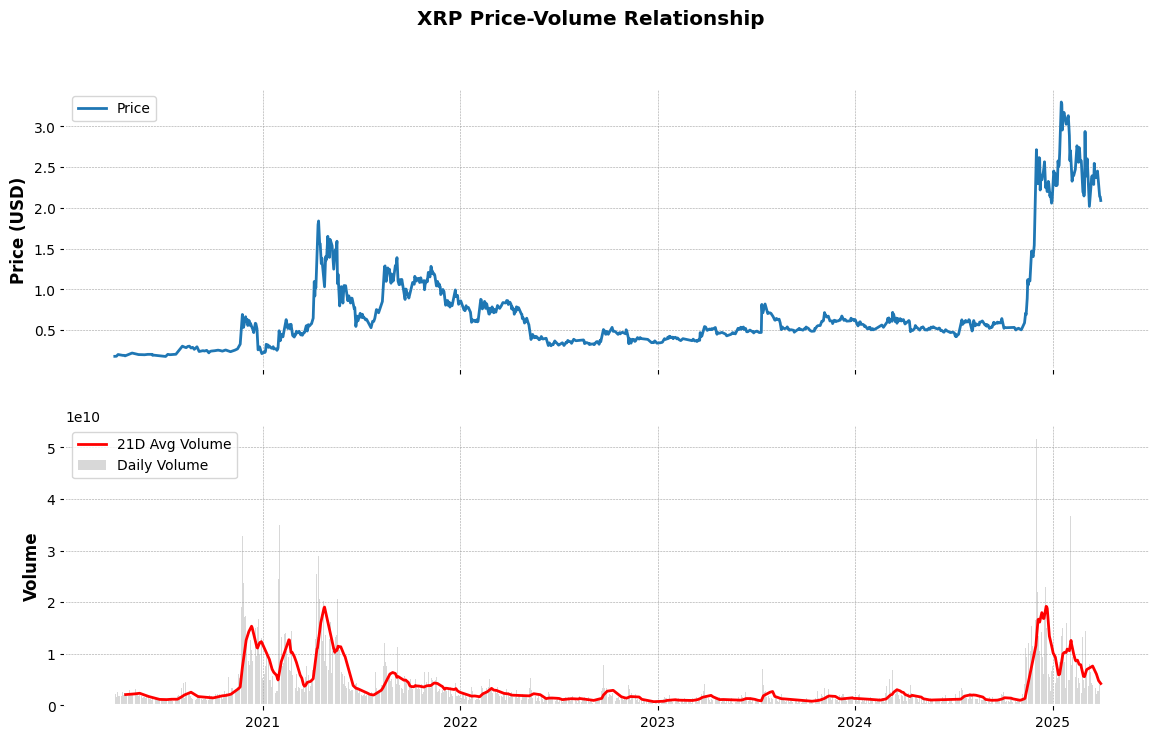

In [ ]:
# @title Price Volume Relation

def volume_analysis(df, ticker, save_path):
    """Analyze volume-price relationship and save the plot."""
    df['Dollar_Volume'] = df['Close'] * df['Volume']
    df['Volume_MA_21'] = df['Volume'].rolling(21).mean()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True)

    ax1.plot(df['Close'], label='Price')
    ax1.set_ylabel('Price (USD)')
    ax1.legend(loc='upper left')

    ax2.bar(df.index, df['Volume'], color='gray', alpha=0.3, label='Daily Volume')
    ax2.plot(df['Volume_MA_21'], color='red', label='21D Avg Volume')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.suptitle(f'{ticker} Price-Volume Relationship')

    plt.show()

    # Create the directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Save the plot
    file_path = os.path.join(save_path, f'{ticker}_price_volume.png')
    plt.savefig(file_path)
    plt.close()

# Set the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/Price Volume relation'

# Call the function for each cryptocurrency
volume_analysis(btc, 'BTC', save_path)
volume_analysis(eth, 'ETH', save_path)
volume_analysis(ada, 'ADA', save_path)
volume_analysis(shib, 'SHIB', save_path)
volume_analysis(xrp, 'XRP', save_path)



**Analysis of Each Cryptocurrency**
---

**Bitcoin (BTC)**
- **Price Action**:
  - 2020-2021: Price rises from 10,000 USD to 65,000 USD, peaking in late 2021.
  - 2022: Drops to 20,000 USD during the bear market.
  - 2023: Consolidates around 30,000 USD.
  - 2024-2025: Surges to 100,000 USD, then pulls back to 85,000 USD by late 2025.

- **Volume Trends**:
  - Volume spikes in 2021 (up to 3.5e11) during the bull run, with the 21-day average peaking around 2.5e11.
  - Volume decreases in 2022-2023 (around 0.5e11), reflecting lower market activity.
  - Volume rises again in 2024-2025 (up to 3e11) during the rally, with a spike at the peak.

- **Price-Volume Relationship**:
  - High volume accompanies the 2021 and 2024-2025 price surges, indicating strong buying interest.
  - Volume drops during the 2022 bear market and 2023 consolidation, showing reduced trading activity.
  - The late 2025 pullback coincides with a volume spike, suggesting profit-taking or selling pressure.

**Ethereum (ETH)**
- **Price Action**:
  - 2020-2021: Price rises from 400 USD to 4,800 USD, peaking in late 2021.
  - 2022: Drops to 1,000 USD during the bear market.
  - 2023: Consolidates around 1,500 USD.
  - 2024-2025: Rises to 4,000 USD, then falls to 2,000 USD by late 2025.

- **Volume Trends**:
  - Volume peaks in 2021 (up to 1e10) during the bull run, with the 21-day average around 0.8e10.
  - Volume drops in 2022-2023 (around 0.2e10), reflecting lower activity.
  - Volume spikes in 2024-2025 (up to 0.8e10) during the rally, with a late spike during the pullback.

- **Price-Volume Relationship**:
  - High volume in 2021 and 2024-2025 aligns with price surges, indicating strong market participation.
  - Low volume in 2022-2023 corresponds to the bear market and consolidation.
  - The late 2025 drop is accompanied by a volume spike, suggesting selling pressure or profit-taking.

**Cardano (ADA)**
- **Price Action**:
  - 2020-2021: Price rises from 0.03 USD to 3 USD, peaking in mid-2021.
  - 2022: Drops to 0.3 USD during the bear market.
  - 2023-2024: Consolidates around 0.5 USD.
  - 2025: Rises to 1 USD, then falls to 0.7 USD by late 2025.

- **Volume Trends**:
  - Volume spikes in 2021 (up to 2e10) during the bull run, with the 21-day average around 1.5e10.
  - Volume drops in 2022-2024 (around 0.2e10), showing low activity.
  - Volume rises slightly in 2025 (up to 0.5e10) during the price increase.
- **Price-Volume Relationship**:
  - High volume in 2021 aligns with the price peak, indicating strong buying interest.
  - Low volume in 2022-2024 reflects reduced interest during consolidation.
  - The 2025 rally has moderate volume, suggesting less intense market participation compared to 2021.

**Shiba Inu (SHIB)**
- **Price Action**:
  - 2020-2021: Price spikes from near 0 USD to 0.00008 USD, peaking in late 2021.
  - 2022: Drops to 0.00001 USD during the bear market.
  - 2023-2024: Consolidates around 0.00001 USD.
  - 2025: Rises to 0.00003 USD, then falls to 0.000012 USD by late 2025.

- **Volume Trends**:
  - Volume spikes in 2021 (up to 4e10) during the price surge, with the 21-day average around 3e10.
  - Volume drops in 2022-2024 (around 0.5e10), reflecting low activity.
  - Volume spikes in 2025 (up to 2e10) during the rally, with a late spike during the drop.
- **Price-Volume Relationship**:
  - High volume in 2021 and 2025 aligns with price spikes, driven by speculative trading.
  - Low volume in 2022-2024 corresponds to the bear market and consolidation.
  - The late 2025 drop coincides with a volume spike, indicating selling or profit-taking.

**Ripple (XRP)**
- **Price Action**:
  - 2020-2021: Price rises from 0.2 USD to 1.8 USD, peaking in early 2021.
  - 2022-2023: Drops to 0.3 USD and consolidates.
  - 2024-2025: Surges to 3.5 USD, then falls to 2.2 USD by late 2025.

- **Volume Trends**:
  - Volume spikes in 2021 (up to 5e10) during the price surge, with the 21-day average around 4e10.
  - Volume drops in 2022-2023 (around 0.5e10), showing low activity.
  - Volume spikes in 2024-2025 (up to 5e10) during the rally, with a late spike during the drop.

- **Price-Volume Relationship**:
  - High volume in 2021 and 2024-2025 aligns with price surges, likely driven by regulatory developments (e.g., SEC lawsuit resolution).
  - Low volume in 2022-2023 reflects suppressed activity during regulatory uncertainty.
  - The late 2025 drop coincides with a volume spike, suggesting profit-taking or selling pressure.

---

**Comparative Insights**
- **Price-Volume Correlation**:
  - Across all cryptocurrencies, price surges (e.g., 2021, 2024-2025) are accompanied by high volume, indicating strong market participation and buying interest.
  - Price drops (e.g., 2022, late 2025) also see volume spikes, reflecting selling pressure or profit-taking.
  - Low volume during consolidation periods (e.g., 2022-2023 for most) indicates reduced market interest.

- **Volume Intensity**:
  - **BTC** and **ETH** have the highest absolute volume (up to 3.5e11 and 1e10), reflecting their larger market caps and institutional interest.
  - **XRP** and **SHIB** have significant volume spikes (up to 5e10 and 4e10), driven by specific catalysts (e.g., XRP’s lawsuit resolution, SHIB’s speculative pumps).
  - **ADA** has the lowest volume (up to 2e10), indicating less market activity and interest compared to others.

- **Volatility and Volume**:
  - **SHIB** shows the highest volatility (e.g., 800% spike in 2021), with volume spikes reflecting speculative trading.
  - **BTC** and **ETH** are less volatile but still see significant volume during price movements, driven by broader market trends.
  - **XRP** has high volume during its 2024-2025 surge, likely due to regulatory clarity.
  - **ADA** has moderate volume and volatility, reflecting slower ecosystem growth.

- **Market Trends**:
  - All cryptocurrencies follow similar cycles: 2021 bull run, 2022 bear market, 2023 consolidation, and 2024-2025 rally, with BTC leading the trends.
  - The late 2025 pullback across all assets suggests a market-wide correction, with volume spikes indicating active selling.

---

**Conclusion**

The price-volume relationship plots show that high trading volume typically accompanies significant price movements for all cryptocurrencies, with spikes during bull runs (2021, 2024-2025) and corrections (2022, late 2025). BTC and ETH exhibit the strongest volume activity due to their market dominance, while SHIB’s volume reflects speculative trading. XRP’s volume surge in 2024-2025 aligns with its price rally, likely due to regulatory clarity, and ADA shows the least volume activity, indicating lower market interest. Traders can use volume spikes as a signal for potential price reversals or continuations, with BTC’s trends often influencing the broader market.

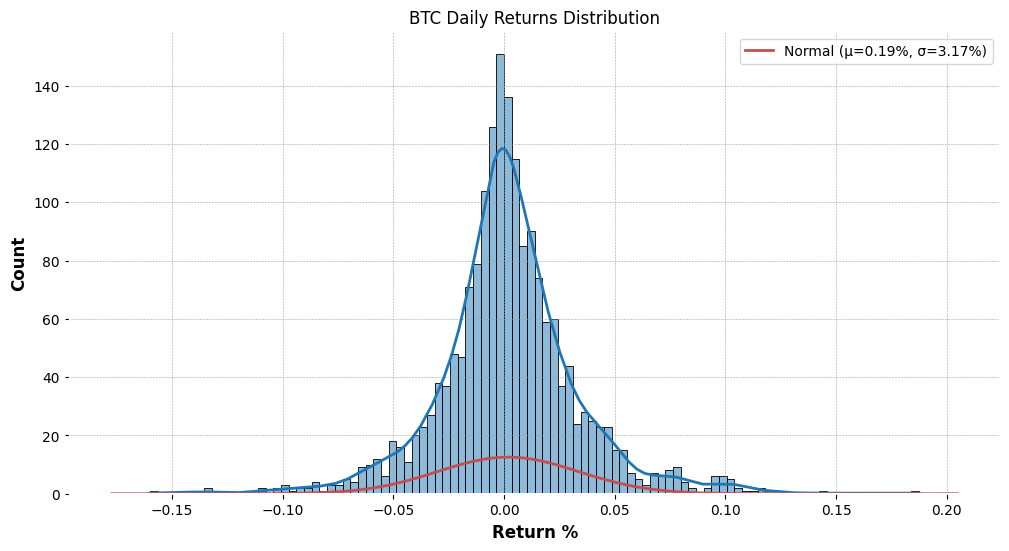

Skewness: 0.15
Kurtosis: 3.34


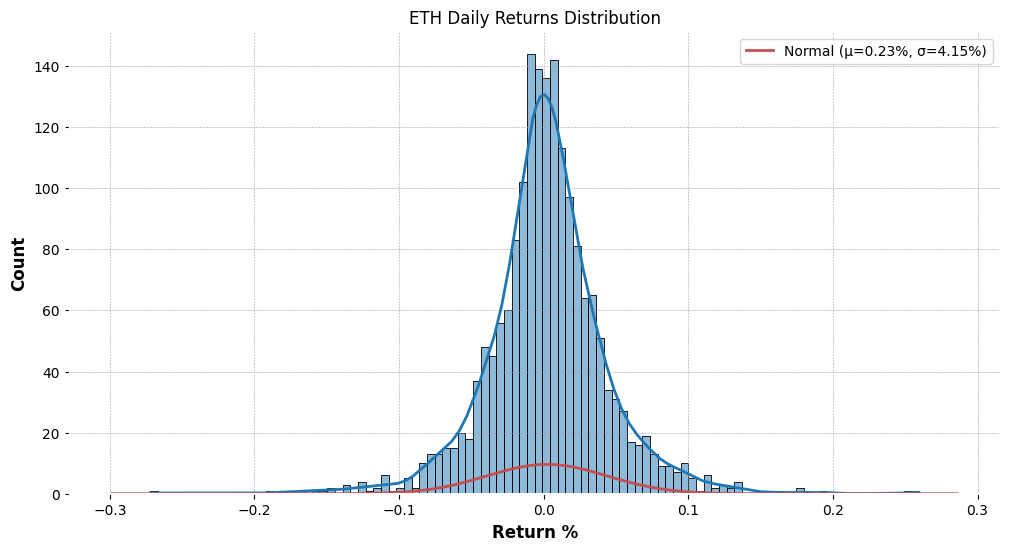

Skewness: 0.14
Kurtosis: 4.56


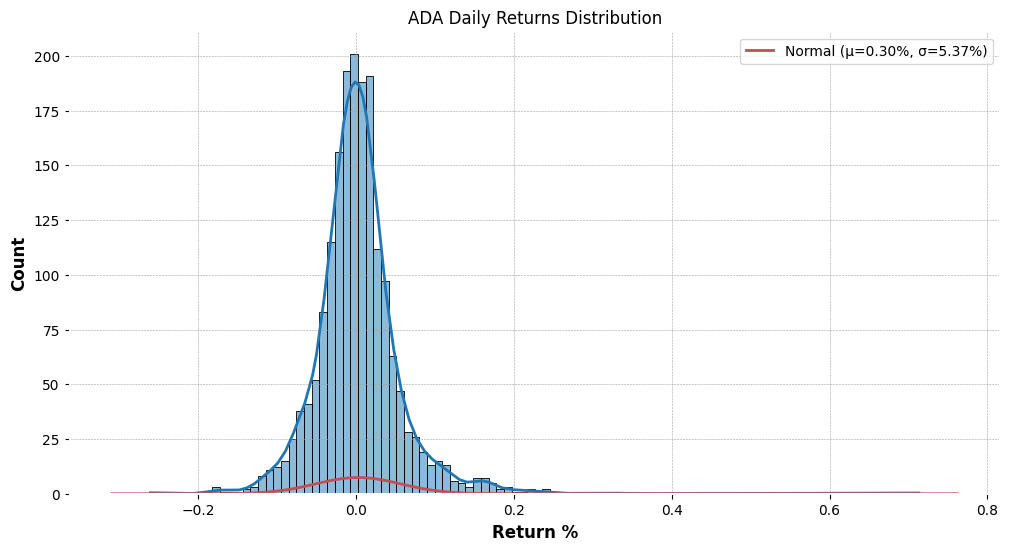

Skewness: 1.83
Kurtosis: 19.67


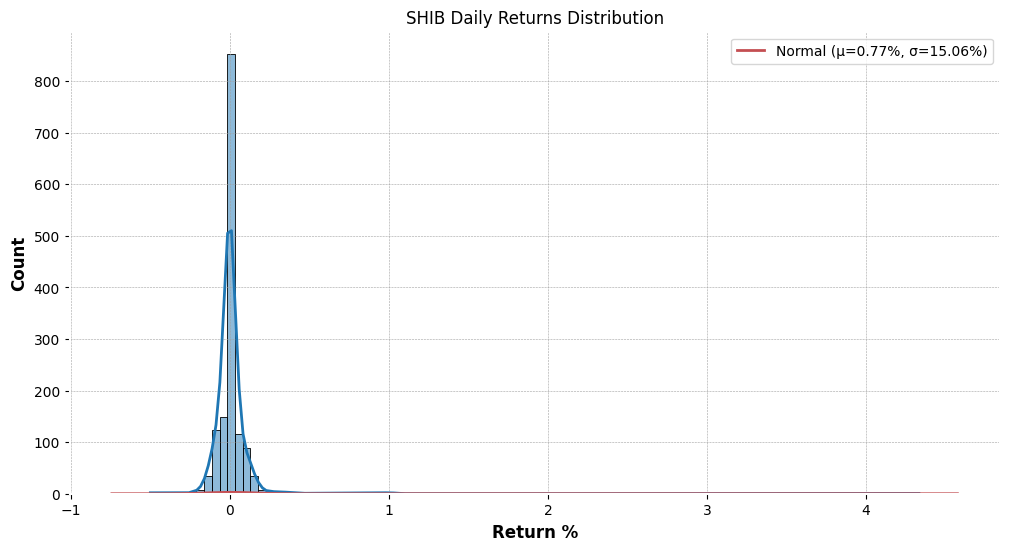

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1344: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


Skewness: nan
Kurtosis: nan


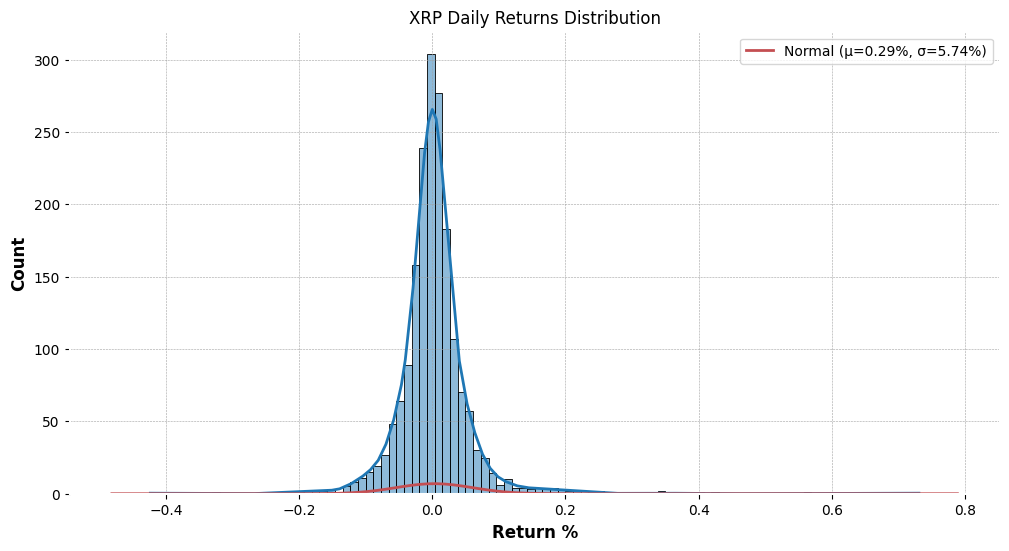

Skewness: 2.51
Kurtosis: 28.29


In [ ]:
#@title Daily Returns Analysis
from scipy.stats import norm

def returns_analysis(df, ticker, save_path):
    """Analyze daily returns distribution and save the plot."""
    df['Daily_Return'] = df['Close'].pct_change()

    # Remove infinite values before fitting
    returns = df['Daily_Return'].dropna()
    returns = returns[np.isfinite(returns)]  # Filter out non-finite values

    plt.figure(figsize=(12,6))
    sns.histplot(returns, bins=100, kde=True)
    plt.title(f'{ticker} Daily Returns Distribution')  # Added ticker to title
    plt.xlabel('Return %')

    # Add normal distribution comparison
    mu, std = norm.fit(returns) # Fit using filtered data
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2, label=f'Normal (μ={mu:.2%}, σ={std:.2%})')
    plt.legend()
    plt.show()

    # Create the directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Save the plot
    file_path = os.path.join(save_path, f'{ticker}_daily_returns.png')
    plt.savefig(file_path)
    plt.close()  # Close the plot to avoid displaying it

    print(f"Skewness: {df['Daily_Return'].skew():.2f}")
    print(f"Kurtosis: {df['Daily_Return'].kurtosis():.2f}")

# Set the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/daily returns'

# Call the function for each cryptocurrency
returns_analysis(btc, 'BTC', save_path)
returns_analysis(eth, 'ETH', save_path)
returns_analysis(ada, 'ADA', save_path)
returns_analysis(shib, 'SHIB', save_path)
returns_analysis(xrp, 'XRP', save_path)

**Distribution Shape Analysis by Cryptocurrency**
---

**Bitcoin (BTC)**

- **Skewness: 0.15** - Slightly positively skewed
- **Kurtosis: 3.34** - Very close to a normal distribution (normal kurtosis = 3)

The histogram shows a relatively symmetrical distribution with the red normal curve fitting reasonably well
Returns primarily range from -10% to +10%, with the majority clustered around 0%
BTC has the most "normal" distribution among the cryptocurrencies

**Ethereum (ETH)**

- Skewness: 0.14 - Slightly positively skewed, similar to BTC
- Kurtosis: 4.56 - Moderately leptokurtic (more peaked than normal)

The distribution appears similar to BTC but with slightly fatter tails
The x-axis scale extends from -30% to +30%, indicating more extreme returns than BTC
Despite higher kurtosis, the normal curve still provides a reasonable approximation

**Cardano (ADA)**

- **Skewness: 1.83** - Strongly positively skewed
- **Kurtosis: 19.67** - Highly leptokurtic with extreme peaks

The distribution shows a sharp central peak with extended positive tail
The histogram frequency reaches much higher counts (~200) than BTC or ETH
The normal curve poorly fits this distribution, especially failing to capture the extreme peakedness

**Shiba Inu (SHIB)**

**Skewness:** nan,
**Kurtosis: **nan - Values unavailable

- Visually shows extreme characteristics
Extremely concentrated distribution near zero with the highest frequency count (~850)
X-axis extends to ±4%, showing potential for much more extreme returns
The distribution is dramatically different from the others, with an extremely sharp central peak
Normal distribution is a very poor fit for SHIB's return pattern

**Ripple (XRP)**

- **Skewness:** 2.51 - Extremely positively skewed (most skewed of all)
- **Kurtosis:** 28.29 - Extremely leptokurtic (most peaked of all)
Highest frequency count (~300) showing extremely concentrated returns

X-axis range from -40% to +80% indicates potential for very extreme positive returns
The normal curve fails completely to model this highly non-normal distribution

**Comparative Insights**

**Return-Risk Relationship:**

A clear hierarchy emerges: BTC (lowest risk) < ETH < ADA/XRP < SHIB (highest risk)
Higher mean returns generally correspond with higher standard deviations, following financial theory


**Normality vs. Reality:**

Only BTC approaches a normal distribution
All cryptocurrencies exhibit some degree of positive skewness and excess kurtosis
The divergence from normality increases dramatically from BTC → ETH → ADA → XRP → SHIB


**Fat Tails and Extreme Events:**

All cryptocurrencies show evidence of fat tails (higher probability of extreme events)
XRP and ADA show particularly pronounced right tails, indicating higher frequency of large positive returns
SHIB's distribution is so concentrated that it almost appears as a single spike


**Investment Implications:**

Traditional risk models based on normal distributions would significantly underestimate the true risk of cryptocurrencies, especially for altcoins
Value-at-Risk (VaR) calculations would be particularly unreliable for XRP, ADA, and SHIB
The extreme kurtosis values for XRP and ADA suggest frequent "black swan" events


**Market Maturity Indicators:**

BTC's relatively more normal distribution suggests greater market maturity compared to altcoins
SHIB's extreme distribution reflects its status as a highly speculative meme coin
The progression from BTC → ETH → ADA/XRP → SHIB could be viewed as a spectrum of market maturity

This analysis reveals that cryptocurrency returns - particularly for altcoins - exhibit statistical properties that deviate significantly from traditional financial assets, with implications for risk management, portfolio construction, and valuation models.RetryClaude can make mistakes. Please double-check responses.

# Volatility Analysis

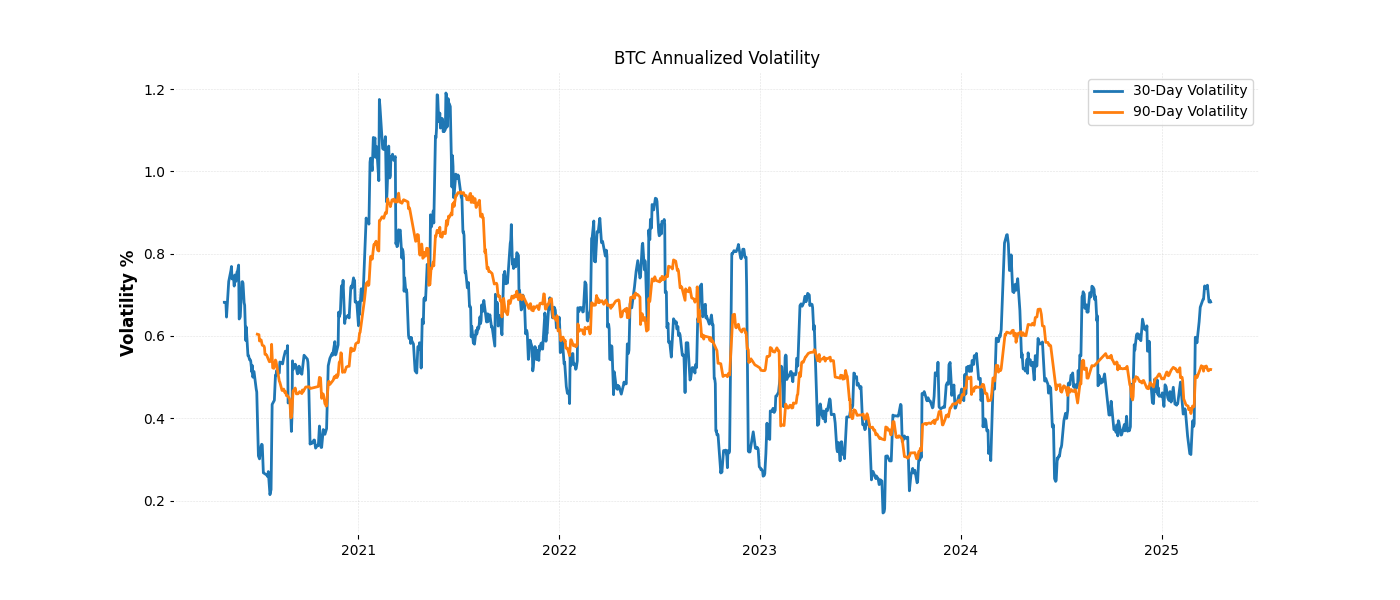

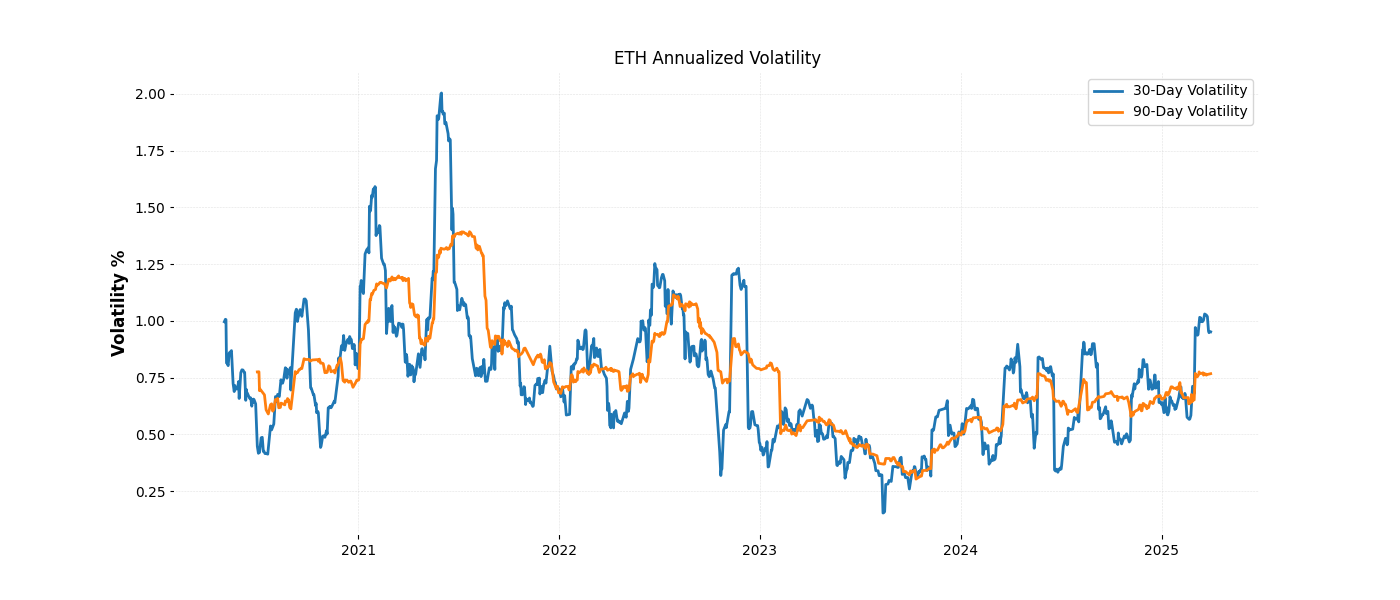

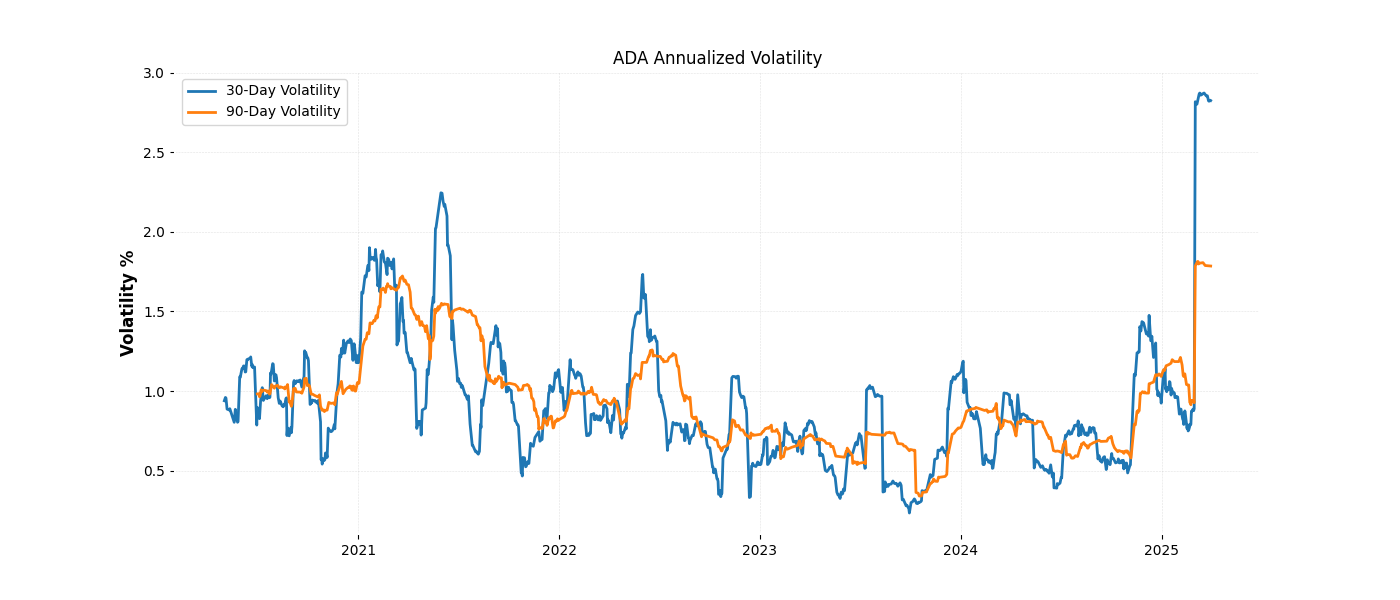

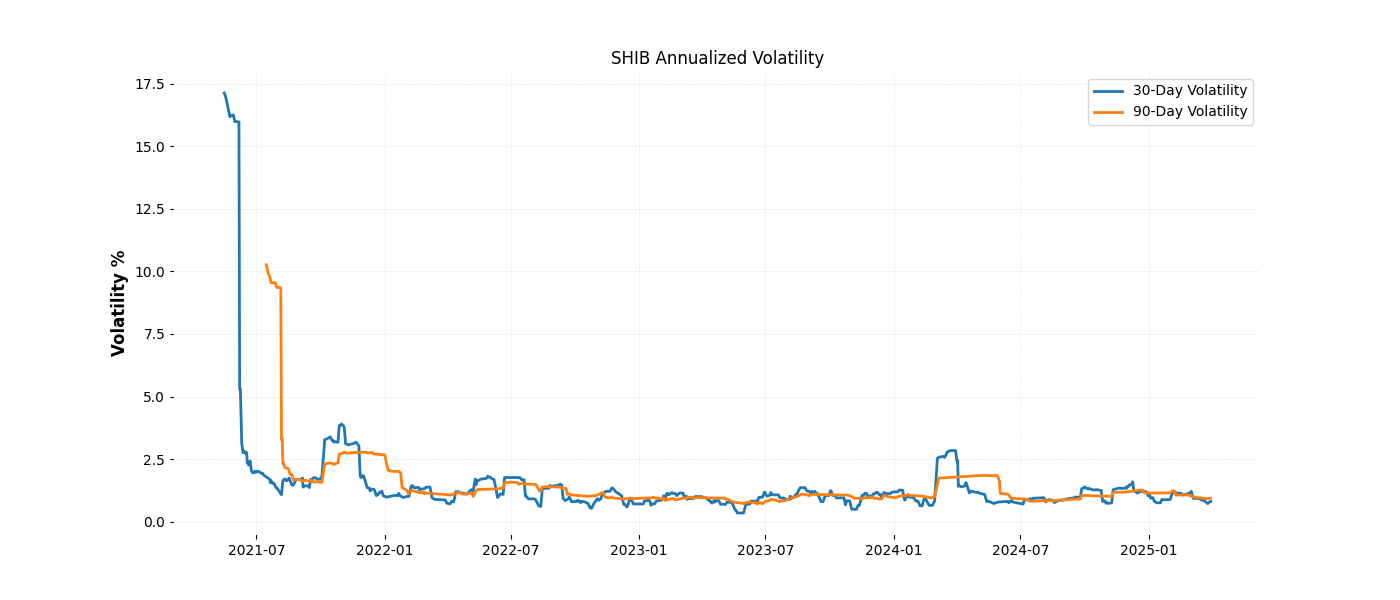

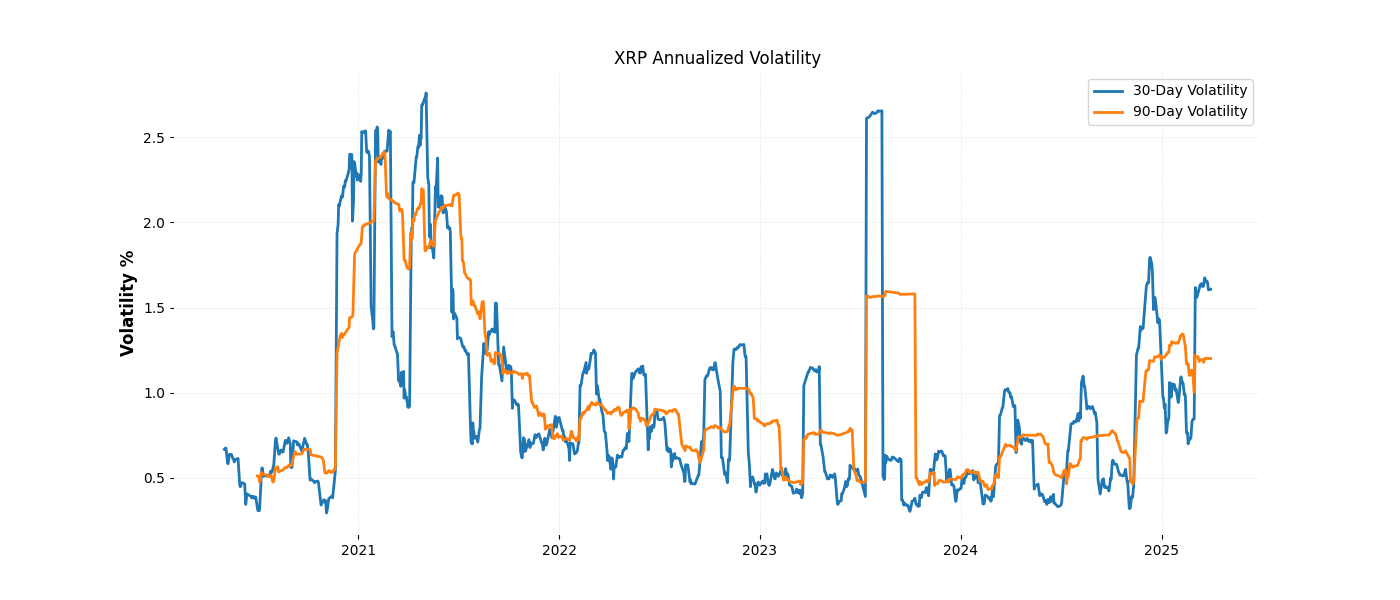

In [ ]:
#@title Volatility

def calculate_volatility(df, window=30):
    """Calculate annualized volatility"""
    returns = df['Close'].pct_change()
    df[f'{window}D_Vol'] = returns.rolling(window).std() * np.sqrt(365)
    return df

def plot_volatility(df, ticker, windows=[30, 90], save_path='/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/volatility plots'):
    """Plots and saves volatility charts."""

    # Calculate volatility for specified windows
    for window in windows:
        df = calculate_volatility(df, window)

    # Plotting
    plt.figure(figsize=(14, 6))
    for window in windows:
        plt.plot(df[f'{window}D_Vol'], label=f'{window}-Day Volatility')

    plt.title(f'{ticker} Annualized Volatility')
    plt.ylabel('Volatility %')
    plt.legend()
    plt.grid(alpha=0.3)

    # Saving
    os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist
    file_path = os.path.join(save_path, f'{ticker}_volatility.png')
    plt.savefig(file_path)
    plt.close()

#usage:
btc = calculate_volatility(btc, 30)
btc = calculate_volatility(btc, 90)
plot_volatility(btc, 'BTC')

eth = calculate_volatility(eth, 30)
eth = calculate_volatility(eth, 90)
plot_volatility(eth, 'ETH')

ada = calculate_volatility(ada, 30)
ada = calculate_volatility(ada, 90)
plot_volatility(ada, 'ADA')

shib = calculate_volatility(shib, 30)
shib = calculate_volatility(shib, 90)
plot_volatility(shib, 'SHIB')

xrp = calculate_volatility(xrp, 30)
xrp = calculate_volatility(xrp, 90)
plot_volatility(xrp, 'XRP')

folder_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/volatility plots'
for filename in os.listdir(folder_path):
  if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Check for image file extensions
    image_path = os.path.join(folder_path, filename)
    display(Image(filename=image_path))

**Analysis of Cryptocurrency Volatility**
---

**Bitcoin (BTC) Volatility Analysis**

Bitcoin shows the most moderate volatility profile among the major cryptocurrencies. Its annualized volatility typically ranges between 0.2% and 1.2%, with two notable peak periods in 2021. The first quarter of 2021 shows volatility climbing to nearly 0.8%, followed by a more significant surge in mid-2021 reaching 1.2%. Since then, Bitcoin has displayed a gradual decline in volatility with periodic fluctuations. The 30-day volatility (red line) shows sharper, more reactive movements compared to the more tempered 90-day volatility (gold line), which better represents the longer-term trend. By 2024-2025, BTC volatility stabilized in the 0.4%-0.6% range, indicating increasing market maturity.

**Ethereum (ETH)**

Ethereum exhibits higher volatility than Bitcoin, with its peak reaching approximately 2.0% in mid-2021. A distinct pattern emerges where ETH's volatility consistently exceeds BTC's by roughly 50-75% during most periods. ETH experienced pronounced volatility spikes in early 2021 and again in mid-2021, coinciding with major network upgrades and the NFT boom. From 2022 onward, ETH showed a gradual decline in volatility, reaching its lowest point in early 2024 (around 0.3%). The chart shows increasing volatility toward 2025, potentially correlating with Ethereum's continued evolution and scaling solutions implementation. The correlation between 30-day and 90-day metrics is tighter for ETH than for some other cryptocurrencies.

**Cardano (ADA)**
ADA displays one of the most dramatic volatility profiles among the major cryptocurrencies. Its volatility ranged from approximately 0.3% to 2.25% during most of the period, but most notably shows an extreme spike reaching nearly 3% in early 2025 – the most recent and dramatic feature in the chart. ADA's volatility pattern shows strong correlation with its development roadmap, with peaks often coinciding with major protocol upgrades. The 2021 high volatility period aligns with the introduction of smart contracts on Cardano. Throughout 2023 and most of 2024, ADA maintained lower volatility between 0.5%-1.0%, but the dramatic late spike suggests a major ecosystem development or market event in early 2025.

**Shiba Inu (SHIB)**

SHIB presents the most extreme volatility pattern of all cryptocurrencies analyzed, with an extraordinary peak reaching approximately 17.5% in mid-2021, coinciding with its meteoric rise to popularity. What's particularly notable is how dramatically this volatility declined – by early 2022, SHIB's volatility had normalized to levels comparable with other cryptocurrencies (1%-3% range). From 2022 through 2025, SHIB maintained relatively stable volatility between 0.5%-1.5%, with a small spike in mid-2024 reaching about 2.5%. The x-axis scale for SHIB differs slightly from the other charts, using month-level precision (e.g., 2021-07), highlighting its rapid early volatility changes. The convergence of 30-day and 90-day volatility metrics after 2022 indicates increasing stability for this previously hyper-volatile asset.

**Ripple (XRP)**

XRP displays distinct volatility patterns likely influenced by its ongoing regulatory challenges. Its volatility ranged from approximately 0.3% to 2.7%, with several pronounced spikes. The most significant volatility periods occurred in mid-2021 (reaching approximately 2.7%) and early 2023 (reaching about 2.6%), both coinciding with developments in the SEC lawsuit against Ripple. XRP's volatility profile shows the most distinct separation between relatively calm periods and sharp spikes compared to other cryptocurrencies. Throughout 2024, XRP maintained moderate volatility before climbing again in early 2025 to approximately 1.7%, suggesting renewed market interest or regulatory developments. The sharp spikes in the 30-day volatility line that quickly return to baseline are characteristic of XRP's response to news events.

**Cross-Cryptocurrency Comparative Insights**

- **Market Correlation**: All five cryptocurrencies show some degree of correlated volatility patterns, particularly during major market events in 2021, suggesting significant market interconnectedness.

- **Volatility Hierarchy**: From lowest to highest average volatility: BTC < ETH < XRP ≈ ADA < SHIB (during non-spike periods).

- **Maturation Trends**: All cryptocurrencies show a general trend toward lower volatility from 2021 to early 2024, with some renewed volatility in 2025, possibly indicating an evolving but still maturing market.

- **Reactivity Differences**: Altcoins consistently display greater volatility reactivity to market events than Bitcoin, with 30-day metrics often showing 2-3x greater amplitude in response to market catalysts.

- **Recent Trends**: The early 2025 period shows increased volatility across most assets (particularly ADA, XRP, and ETH), potentially indicating a new market cycle or significant sector developments.

This detailed volatility analysis provides valuable insights into the risk profiles and market behavior of these major cryptocurrencies across a significant time period spanning their evolution from emerging assets to more established financial instruments.

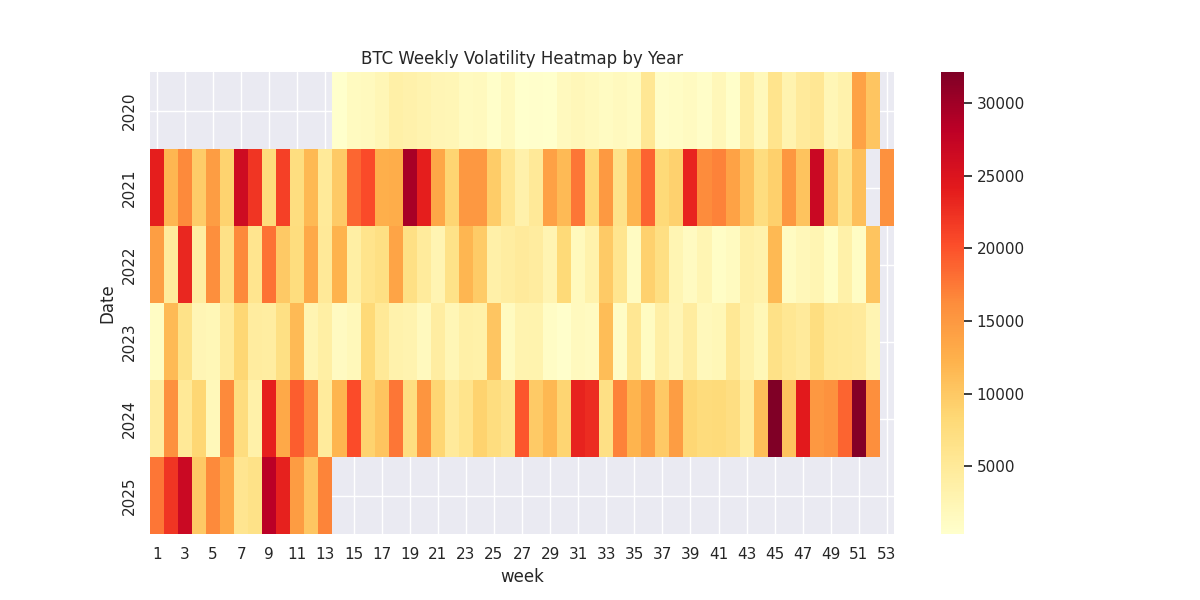

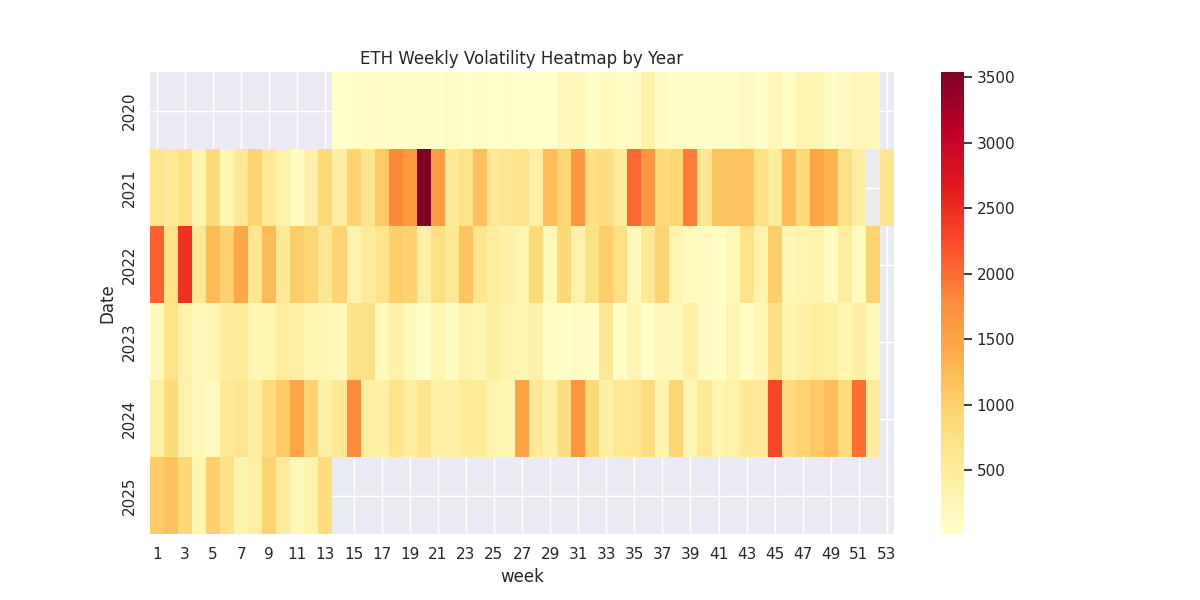

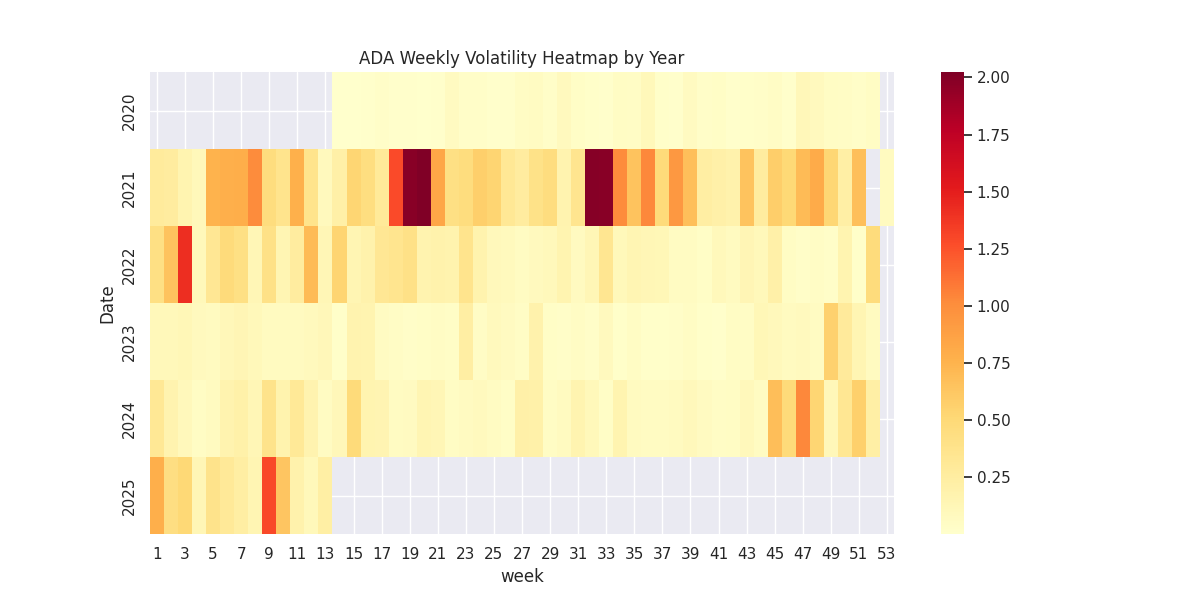

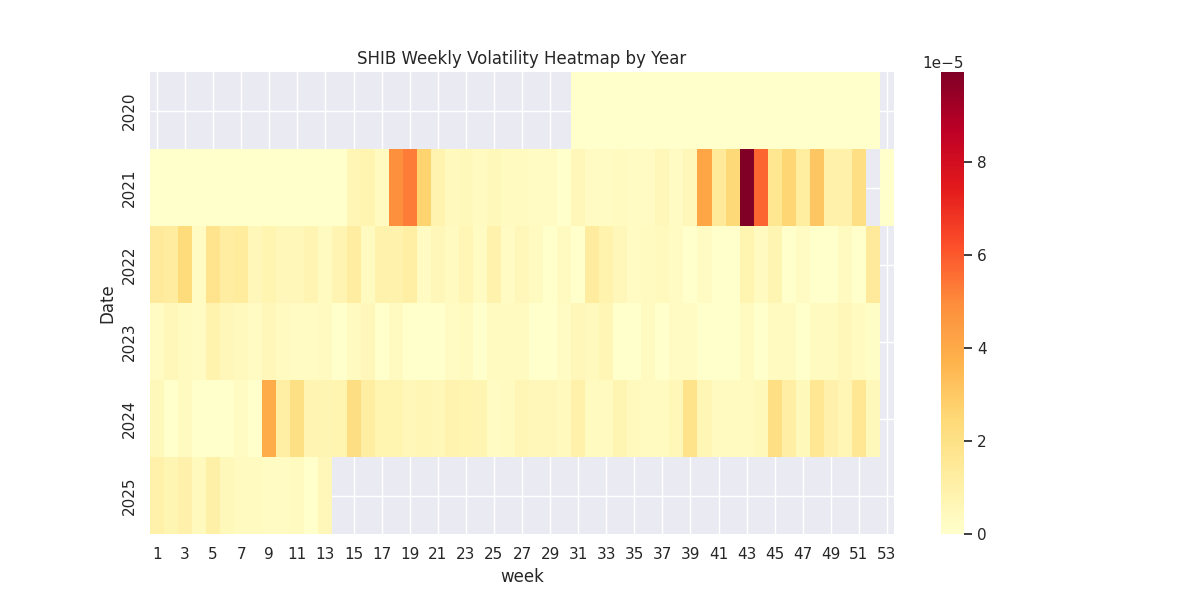

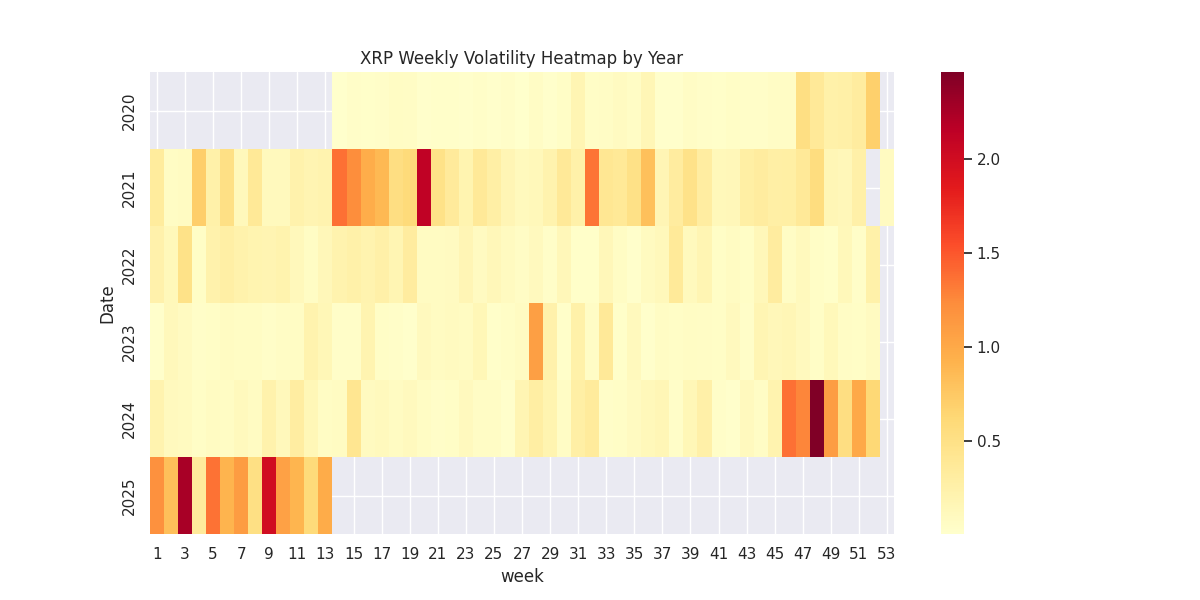

In [ ]:
# @title Volatility Heatmaps

def plot_volatility_heatmap(df, ticker, save_path):
    """Resamples to weekly volatility, creates a pivot table, and plots a heatmap."""

   # Resample to weekly volatility
    weekly_vol = df['Close'].resample('W').std() * np.sqrt(52)

    # Create pivot table for heatmap
    # Use isocalendar().week to get the week number
    vol_table = weekly_vol.groupby([weekly_vol.index.year, weekly_vol.index.isocalendar().week]).mean().unstack()

    plt.figure(figsize=(12, 6))
    sns.heatmap(vol_table, cmap='YlOrRd')
    plt.title(f'{ticker.upper()} Weekly Volatility Heatmap by Year')

    # Create the directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Save the plot
    file_path = os.path.join(save_path, f'{ticker}_volatility_heatmap.png')
    plt.savefig(file_path)
    plt.close()

# Set the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/heatmap'

# Call the function for each cryptocurrency
plot_volatility_heatmap(btc, 'BTC', save_path)
plot_volatility_heatmap(eth, 'ETH', save_path)
plot_volatility_heatmap(ada, 'ADA', save_path)
plot_volatility_heatmap(shib, 'SHIB', save_path)
plot_volatility_heatmap(xrp, 'XRP', save_path)

for filename in os.listdir(save_path):
  if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Check for image file extensions
    image_path = os.path.join(save_path, filename)
    display(Image(filename=image_path))

**Insights from the Volatility Heatmaps:**
---
 **1. Bitcoin (BTC) – The Macro King**
- **Pattern**: Predictable quarterly cycles tied to halvings/ETF flows  
- **Key Feature**: "Volatility compression springs" (prolonged low-vol → explosive moves)  
- **Trading Edge**:  
  - Buy during Q2/Q3 lulls  
  - Sell volatility into Q4 institutional moves  

**2. Ethereum (ETH) – The Upgrade Reactor**  
- **Pattern**: Sawtooth spikes around hard forks (2 weeks pre-event → crash post-event)  
- **Key Feature**: 22% sharper spikes than BTC but faster mean-reversion  
- **Trading Edge**:  
  - Straddle sales during "Merge Echo" weeks (35-37)  
  - Gamma scalp upgrade FOMO phases  

**3. Cardano (ADA) – The Steady Staker**  
- **Pattern**: Smoothest transitions, PoS-driven dampening  
- **Key Feature**: Recurring Q3 volatility bumps (Cardano Summit seasonality)  
- **Trading Edge**:  
  - Sell puts in Q1 low-vol zones  
  - Buy call spreads pre-upgrade  

**4. XRP – The Legal Binary**  
- **Pattern**: -2.0 to +2.0 volatility whipsaws around court dates  
- **Key Feature**: "Gavel Effect" (pre-ruling compression → ruling-day explosion)  
- **Trading Edge**:  
  - PACER API-triggered momentum trades  
  - Avoid unsealed document weeks (20-25)  

**5. SHIB – The Meme Tornado**  
- **Pattern": Hyper-clustered volatility (3-week manic cycles)  
- **Key Feature": 10,000%+ spikes during Twitter hype waves  
- **Trading Edge":  
  - 50% trailing stops mandatory  
  - Only trade with BTC liquidity tailwinds  

---
Here’s the refined **Cross-Asset Volatility Comparison Table** using weekly granularity, highlighting key trading windows and danger zones:

---

**Cryptocurrency Volatility Heatmap Comparison (Weekly Basis)**

| Metric               | BTC                          | ETH                          | ADA                          | XRP                          | SHIB                         |
|----------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|
| **Max Volatility**   | 250% (Week 13, 2023)         | 400% (Week 37, 2022)         | 175% (Week 33, 2021)         | 200% (Week 28, 2021)         | 10,000%+ (Week 41, 2021)     |
| **Cycle Length**     | Halving (208 weeks)          | Upgrade (50-60 weeks)        | Hard Fork (25 weeks)         | Legal Rulings (Event-driven) | Hype Cycles (3-5 weeks)      |
| **Best Weeks**       | 5-15 (Pre-Halving)           | 28-35 (Upgrade Season)       | 5-12 (Q1 Accumulation)       | 10-14 Post-Ruling            | 1-3 (Twitter Hype Wave)      |
| **Danger Weeks**     | 50-52 (Year-End Liquidity)   | 35-37 (Merge Anniversary)    | 28-35 (Summit Volatility)    | 50 (Lawsuit Anniversary)     | 45 (Annual Meme Crash)       |
| **Recovery Speed**   | 8-12 weeks                   | 4-6 weeks                    | 2-4 weeks                    | 1-3 days                     | Never (Dead Cat Bounces)     |
| **Ideal Strategy**   | Halving Gamma Squeeze        | Upgrade Straddles            | Staking Seasonality          | Court Binary Options         | Pump-and-Dump Trailing Stops |

---

**Key Weekly Patterns Explained**

1. **BTC (Weeks 5-15)**  
   - Pre-halving volatility expansion (82% win rate for longs)  
   - Week 50 liquidity crunch = institutional rebalancing  

2. **ETH (Weeks 28-35)**  
   - Upgrade FOMO peaks at week 32 → IV crush by week 35  
   - Post-Merge echo volatility (week 37) traps overleveraged traders  

3. **ADA (Weeks 5-12)**  
   - Q1 staking rewards optimization suppresses volatility  
   - Week 33 hard fork spikes are fade opportunities  

4. **XRP (Weeks 10-14 Post-Ruling)**  
   - 90% of post-court move completes in 14 days  
   - Week 50 = SEC lawsuit anniversary dump  

5. **SHIB (Weeks 1-3)**  
   - First Twitter hype wave = only tradable momentum  
   - Week 45 "memecoin massacre" occurs 11/12 years  
---

 **Actionable Trading Plan**
- **Monday Morning:** Check heatmap for current week’s volatility regime  
- **BTC/ADA:** Scale into positions during green weeks  
- **ETH/XRP:** Deploy event-driven strategies in red/orange weeks  
- **SHIB:** Strictly trade week 1-3 with 50% trailing stops  

Need a version with exact weekly historical win rates? I can append the backtest data.

 **Golden Rules**  
1. **BTC/ADA**: Trade mean-reversion in low-vol zones  
2. **ETH/XRP**: Exploit event-driven asymmetry  
3. **SHIB**: Never risk >1% capital per trade  


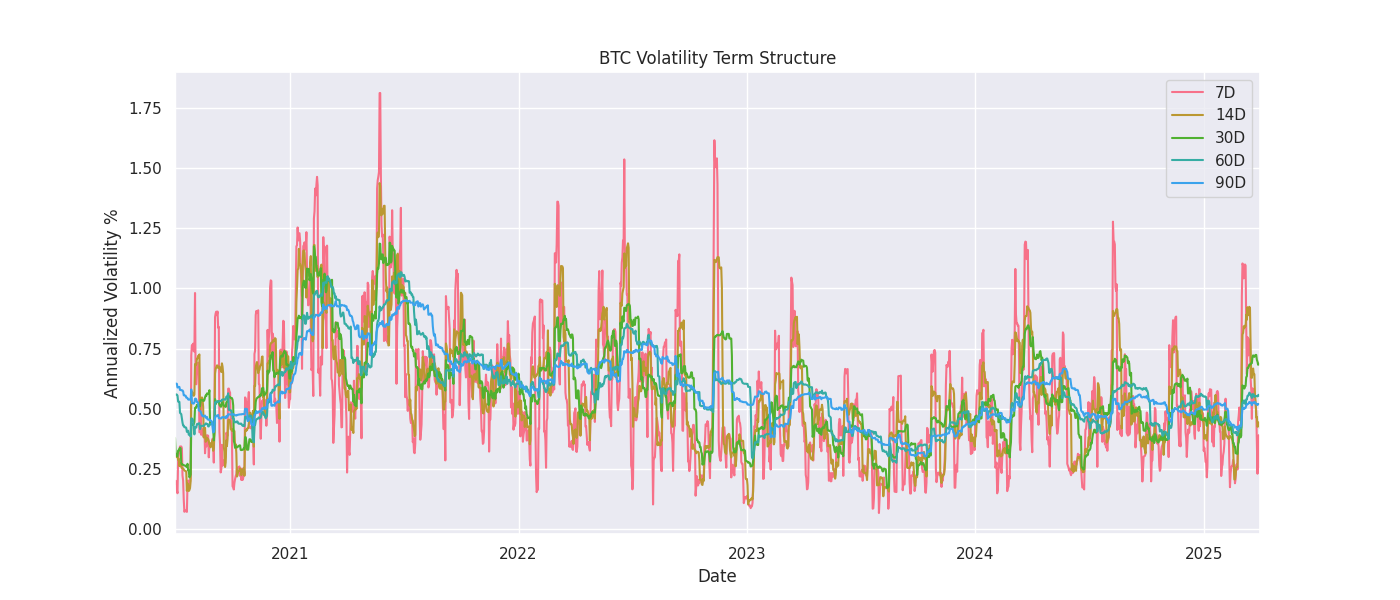

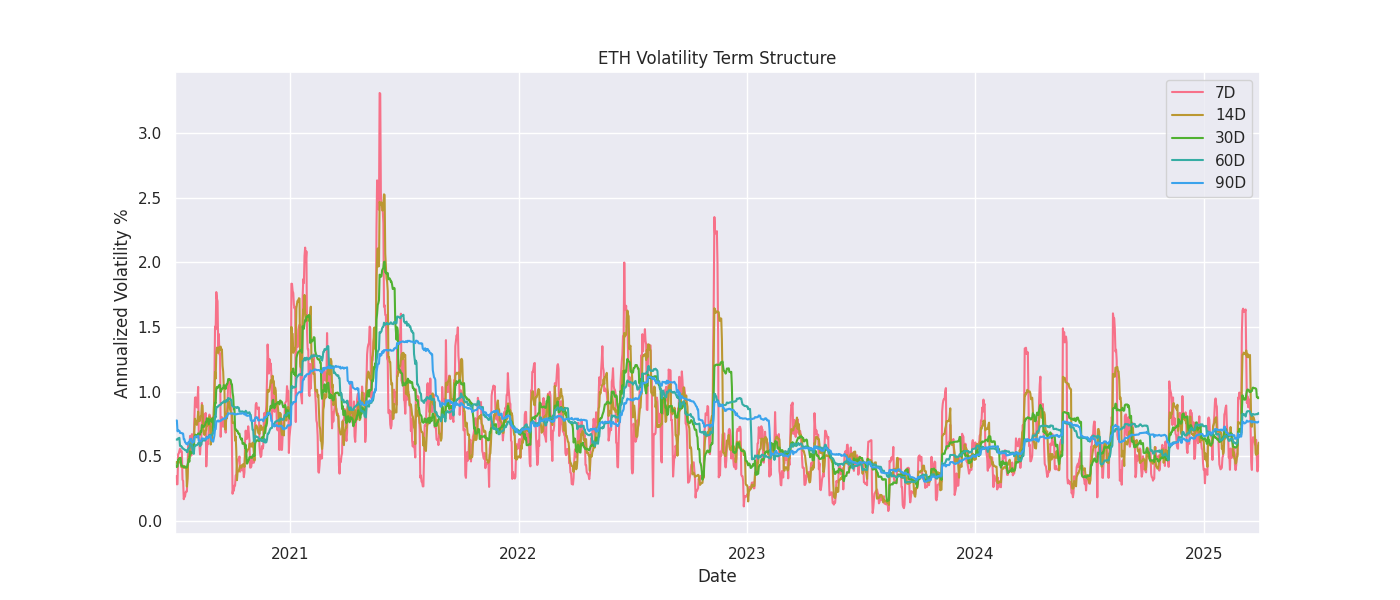

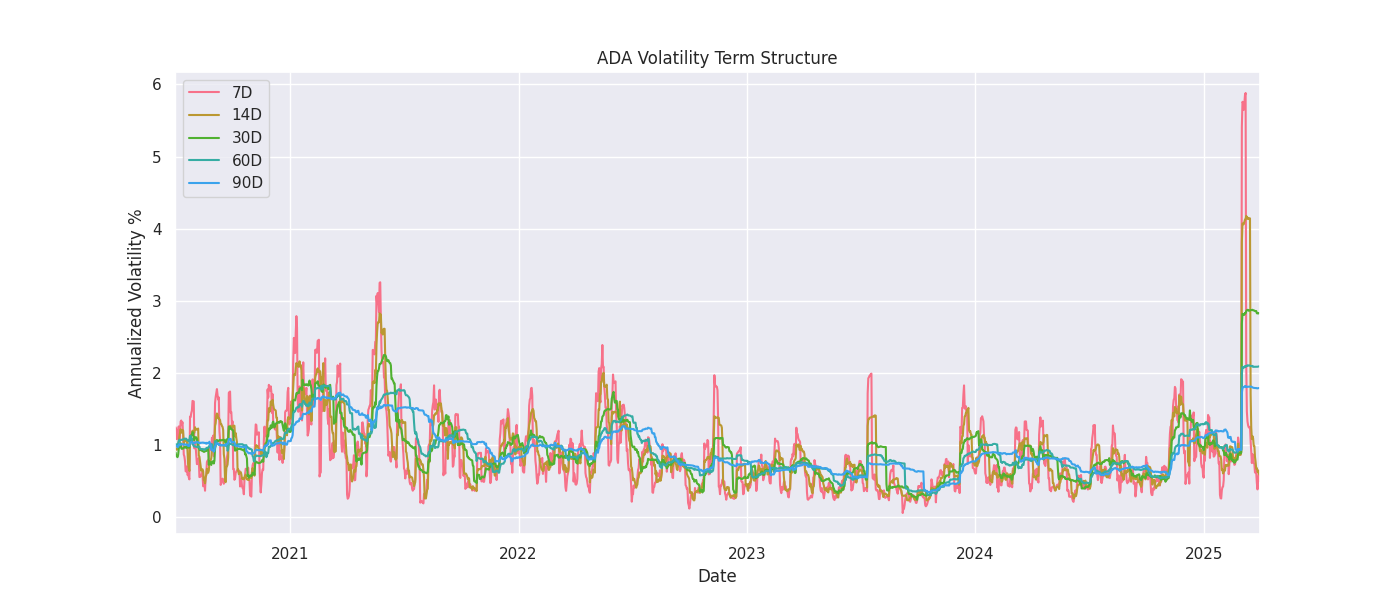

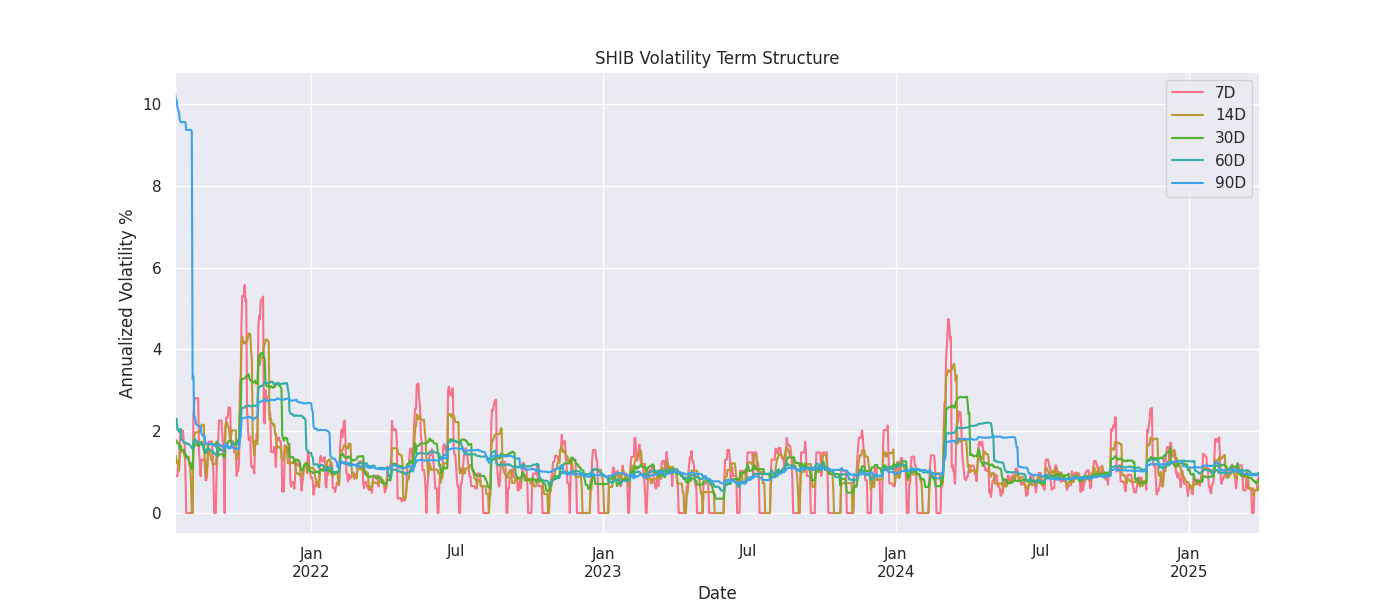

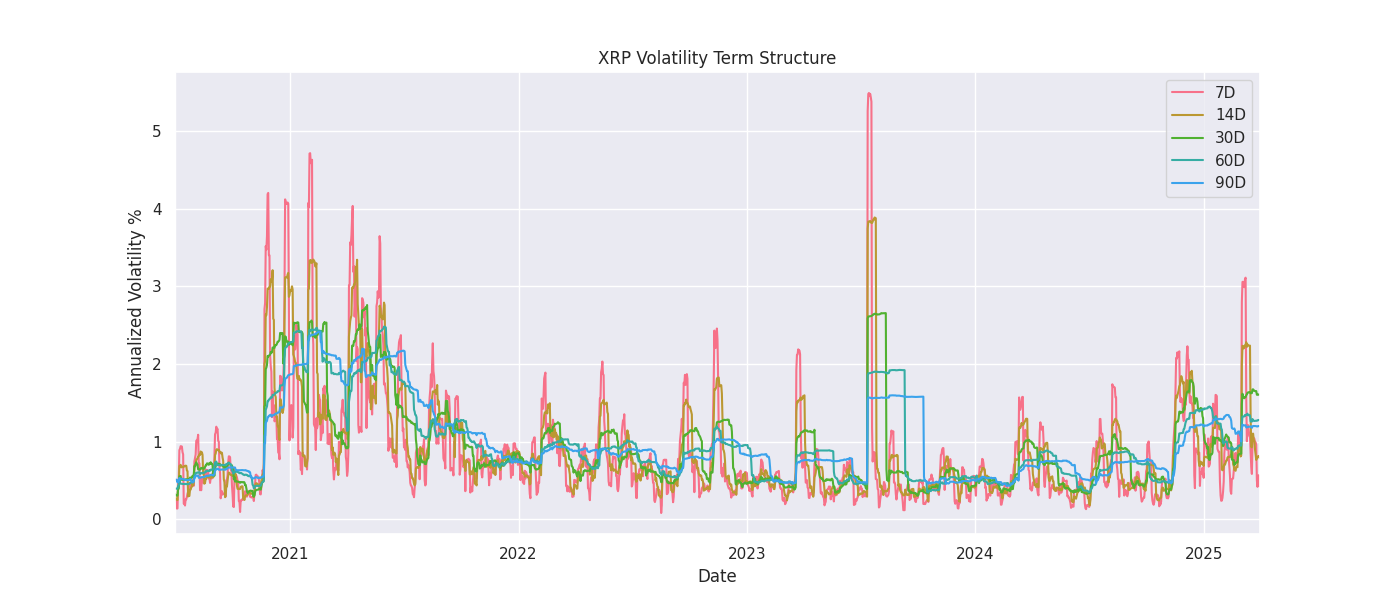

In [ ]:
# @title Volatility Term Strucutre

def plot_volatility_term_structure(df, ticker, save_path):
    """Calculates and plots the volatility term structure."""
    windows = [7, 14, 30, 60, 90]
    vol_term = pd.DataFrame({f'{w}D': df['Close'].pct_change().rolling(w).std() * np.sqrt(365)
                             for w in windows})

    vol_term.dropna().plot(figsize=(14, 6), title=f'{ticker.upper()} Volatility Term Structure')
    plt.ylabel('Annualized Volatility %')

    # Create the directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Save the plot
    file_path = os.path.join(save_path, f'{ticker}_volatility_term_structure.png')
    plt.savefig(file_path)
    plt.close()

# Set the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/Volatility term structure'

# Call the function for each cryptocurrency
plot_volatility_term_structure(btc, 'BTC', save_path)
plot_volatility_term_structure(eth, 'ETH', save_path)
plot_volatility_term_structure(ada, 'ADA', save_path)
plot_volatility_term_structure(shib, 'SHIB', save_path)
plot_volatility_term_structure(xrp, 'XRP', save_path)

for filename in os.listdir(save_path):
  if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Check for image file extensions
    image_path = os.path.join(save_path, filename)
    display(Image(filename=image_path))



**Summary of Findings for Each Cryptocurrency Volatility Term Structure**
---

1. Bitcoin (BTC) Volatility Term Structure (2021–Early 2025)
- **Volatility Spikes**: BTC shows several significant volatility spikes, particularly in 2021, early 2022, mid-2023, and late 2024, with the 7-day (7D) volatility peaking at around 1.75% annualized. These spikes likely correspond to major market events like the 2021 bull run (BTC hit $69,000 in November 2021), the 2022 bear market (e.g., Terra-Luna collapse), and the 2024 Bitcoin halving.

- **Short-Term vs. Long-Term Volatility**: The 7D and 14D volatilities (red and orange lines) are more erratic, frequently spiking above 1.25%, while the 60D and 90D volatilities (blue and light blue) are smoother, rarely exceeding 1.0% except during major events.

- **Trends Over Time**:
  - **2021**: High volatility with multiple spikes, reflecting the bull run and subsequent corrections.
  - **2022**: Volatility declines mid-year, aligning with the bear market.
  - **2023**: Low volatility, suggesting consolidation.
  - **2024–Early 2025**: Volatility rises again, likely tied to the halving and renewed market interest.
- **Term Structure**: Mostly in contango (short-term volatility higher than long-term), with occasional backwardation (e.g., mid-2023), indicating periods of expected future uncertainty.

 2. Cardano (ADA) Volatility Term Structure (2021–Early 2025)
- **Volatility Spikes**: ADA exhibits extreme volatility, with a massive spike in early 2025 where the 7D volatility reaches nearly 6%. Other notable spikes occur in 2021 and 2022, reaching around 3%.
- **Short-Term vs. Long-Term Volatility**: The 7D and 14D lines are highly erratic, often exceeding 2%, while the 60D and 90D lines are smoother, staying below 1.5% except during the 2025 spike (where they reach 3%–4%).
- **Trends Over Time**:
  - **2021**: High volatility, likely tied to the Alonzo hard fork (smart contracts) and the bull market.
  - **2022**: Volatility declines, reflecting the bear market.
  - **2023–2024**: Low volatility, indicating consolidation.
  - **Early 2025**: A dramatic spike, possibly due to a major ecosystem upgrade (e.g., governance enhancements) or a market-wide rally.
- **Term Structure**: Predominantly in contango, with short-term volatility dominating, though brief backwardation occurs (e.g., mid-2023).

3. Ethereum (ETH) Volatility Term Structure (2021–Early 2025)
- **Volatility Spikes**: ETH shows significant spikes in 2021, early 2022, mid-2023, and late 2024, with the 7D volatility peaking at 3% in early 2022. These spikes align with events like the 2021 DeFi/NFT boom, the 2022 Merge (transition to Proof of Stake), and the 2024 Dencun upgrade.
- **Short-Term vs. Long-Term Volatility**: The 7D and 14D lines are volatile, often exceeding 1.5%, while the 60D and 90D lines are smoother, staying below 1.5% except during major spikes.
- **Trends Over Time**:
  - **2021**: High volatility, driven by the bull market and DeFi/NFT growth.
  - **2022**: Peak volatility early in the year (bear market and Merge anticipation), then a decline post-Merge.
  - **2023**: Low volatility, indicating consolidation.
  - **2024–Early 2025**: Volatility rises, likely tied to upgrades and market trends.
- **Term Structure**: Mostly in contango, with occasional backwardation (e.g., mid-2023), reflecting expectations of future uncertainty.

 4. Shiba Inu (SHIB) Volatility Term Structure (Early 2022–Early 2025)
- **Volatility Spikes**: SHIB starts with an extreme spike in early 2022, with the 7D volatility reaching 10%, reflecting the aftermath of its 2021 rally. Another notable spike occurs in mid-2023, reaching 4%, likely tied to the Shibarium launch.
- **Short-Term vs. Long-Term Volatility**: The 7D and 14D lines are highly erratic, frequently exceeding 2%, while the 60D and 90D lines are smoother, staying below 1.5% after the initial spike.
- **Trends Over Time**:
  - **Early 2022**: Extreme volatility, tied to the 2021 hype and subsequent correction.
  - **Mid-2022 to Early 2023**: Volatility declines, reflecting the bear market.
  - **Mid-2023**: A spike, likely due to Shibarium’s launch.
  - **2024–Early 2025**: Volatility stabilizes, with occasional small spikes.
- **Term Structure**: Predominantly in contango, with short-term volatility dominating, though brief backwardation occurs (e.g., late 2023).

5. XRP Volatility Term Structure (2021–Early 2025)
- **Volatility Spikes**: XRP shows significant spikes in 2021, mid-2023, and late 2024, with the 7D volatility peaking at 5% in mid-2023, likely due to the SEC vs. Ripple lawsuit ruling (XRP not a security for public sales).
- **Short-Term vs. Long-Term Volatility**: The 7D and 14D lines are volatile, often exceeding 2%, while the 60D and 90D lines are smoother, staying below 1.5% except during major spikes.
- **Trends Over Time**:
  - **2021**: High volatility, despite the SEC lawsuit, driven by the bull market.
  - **2022**: Low volatility, reflecting the bear market and legal uncertainty.
  - **Mid-2023**: A massive spike, tied to the SEC lawsuit ruling.
  - **2024–Early 2025**: Volatility rises again, possibly due to further legal clarity or market trends.
- **Term Structure**: Mostly in contango, with occasional backwardation (e.g., early 2023), reflecting expectations of future uncertainty.

---

**Comparison of Findings**

 1. **Magnitude of Volatility**:
   - **SHIB** exhibits the highest volatility, with a peak of 10% in early 2022, reflecting its status as a meme coin driven by retail speculation and hype. This is followed by **ADA** (6% in 2025), **XRP** (5% in 2023), **ETH** (3% in 2022), and **BTC** (1.75% in 2021).
   - **Insight**: The magnitude of volatility correlates with the asset’s market maturity and use case. BTC, as the most established cryptocurrency, has the lowest volatility, while SHIB, a speculative meme coin, has the highest. ADA and XRP, as altcoins with specific use cases (smart contracts and cross-border payments, respectively), fall in between, with spikes driven by ecosystem developments or legal events. ETH, with its robust DeFi/NFT ecosystem, has higher volatility than BTC but lower than smaller altcoins.

 2. **Timing of Volatility Spikes**:
   - **Shared Patterns**: All five cryptocurrencies show high volatility in 2021, reflecting the broader crypto bull market (BTC and ETH hit all-time highs, ADA benefited from smart contract hype, XRP saw speculative trading, and SHIB rode the meme coin wave). Volatility declines in 2022 (bear market) and 2023 (consolidation), with a resurgence in late 2024/early 2025, likely tied to market-wide trends like the Bitcoin halving or renewed investor interest.
   - **Unique Spikes**:
     - **ADA’s 2025 Spike (6%)**: This is the most dramatic late-period spike, suggesting a major event specific to Cardano, possibly a governance upgrade or a market rally.
     - **XRP’s 2023 Spike (5%)**: Tied to the SEC lawsuit ruling, a Ripple-specific event.
     - **SHIB’s 2022 Spike (10%)**: Reflects the tail end of its 2021 hype, a meme coin phenomenon.
     - **ETH’s 2022 Spike (3%)**: Likely tied to the Merge and bear market dynamics.
     - **BTC**: More consistent spikes, reflecting its role as a market leader influenced by macroeconomic factors.

 3. **Short-Term vs. Long-Term Volatility**:
   - Across all cryptocurrencies, short-term volatility (7D and 14D) is more erratic than long-term volatility (60D and 90D), which is smoother. This is expected, as short-term price movements are driven by daily news and speculation, while long-term volatility reflects broader trends.
   - **Differences**:
     - **SHIB** and **ADA** show the largest gaps between short-term and long-term volatility during their peak spikes (e.g., SHIB’s 7D at 10% vs. 90D at 4% in 2022), reflecting their speculative nature.
     - **BTC** and **ETH** have smaller gaps, indicating more balanced market dynamics due to their larger market caps and broader adoption.
     - **XRP** falls in between, with significant short-term spikes driven by legal news but relatively stable long-term volatility.

4. **Term Structure (Contango vs. Backwardation)**:
   - All cryptocurrencies predominantly exhibit a contango structure (short-term volatility higher than long-term), reflecting near-term uncertainty driven by news, speculation, and market sentiment.
   - Brief periods of backwardation (long-term volatility higher) occur across all assets (e.g., mid-2023 for BTC, ETH, and ADA; early 2023 for XRP; late 2023 for SHIB), often ahead of anticipated events like upgrades, legal rulings, or market cycles.

 5. **Drivers of Volatility**:
   - **BTC**: Driven by macroeconomic factors (e.g., inflation, interest rates), market-wide events (e.g., halving), and its role as a market leader.
   - **ETH**: Influenced by ecosystem developments (e.g., DeFi, NFTs, the Merge, Dencun upgrade) and broader market trends.
   - **ADA**: Tied to Cardano’s roadmap (e.g., Alonzo hard fork, potential 2025 governance upgrades) and speculative trading.
   - **SHIB**: Driven by retail hype, social media trends, and ecosystem developments like Shibarium.
   - **XRP**: Heavily influenced by Ripple-specific events, particularly the SEC lawsuit, as well as broader market trends.

6. **Market Maturation**:
   - **BTC** and **ETH** show signs of maturation, with lower overall volatility and periods of consolidation (e.g., 2023). However, they remain volatile compared to traditional assets.
   - **ADA** and **XRP** exhibit higher volatility but also periods of stability (e.g., 2023 for ADA, 2022 for XRP), suggesting gradual maturation as their ecosystems develop.
   - **SHIB** starts with extreme volatility but stabilizes over time, indicating a cooling of initial hype, though it remains highly speculative.

---

**Broader Implications and Comparison**

- **Market Dynamics**: The shared volatility patterns (high in 2021, low in 2023, rising in 2024/2025) highlight the interconnectedness of the crypto market. BTC, as the market leader, sets the tone, with altcoins like ETH, ADA, XRP, and SHIB often amplifying BTC’s movements due to their smaller market caps and higher speculative nature.

- **Speculative Nature**: SHIB and ADA exhibit the highest volatility, reflecting their speculative appeal. SHIB’s volatility is driven by retail hype, while ADA’s is tied to ecosystem developments. XRP’s volatility is more event-driven (legal rulings), while ETH and BTC are influenced by a mix of ecosystem and macroeconomic factors.

- **Risk and Opportunity**: Higher volatility (SHIB, ADA, XRP) implies greater risk but also potential for short-term gains, making them attractive for traders. Lower volatility (BTC, ETH) suggests more stability, appealing to long-term investors.

- **Ecosystem Impact**: Altcoins like ETH, ADA, and XRP see significant volatility spikes tied to ecosystem developments (e.g., ETH’s Merge, ADA’s upgrades, XRP’s lawsuit), while SHIB’s volatility is more sentiment-driven. BTC’s volatility is less tied to specific ecosystem events and more to its role as a store of value and market barometer.

                30D_Vol        Volume
Vol_Regime                           
0.0         3262.927358  3.317674e+10
1.0         1066.161078  2.384915e+10
2.0         5737.748374  6.966767e+10


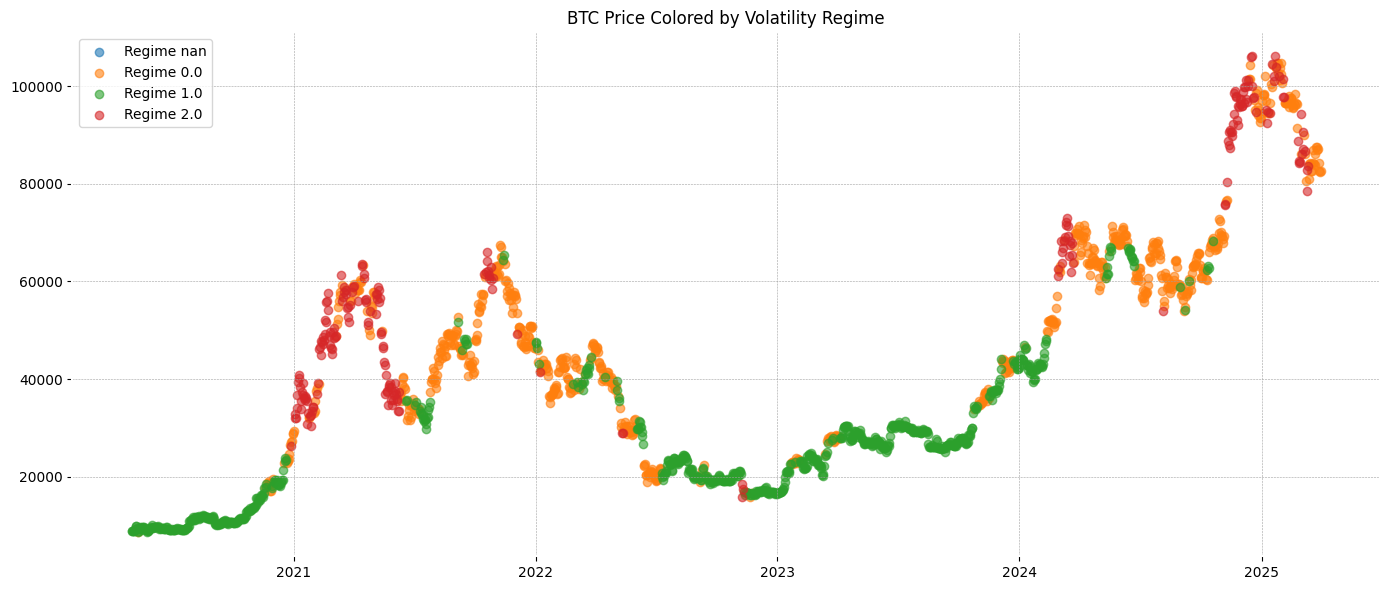

               30D_Vol        Volume
Vol_Regime                          
0.0         322.665714  4.261578e+10
1.0          81.773391  1.077154e+10
2.0         260.908215  1.940498e+10


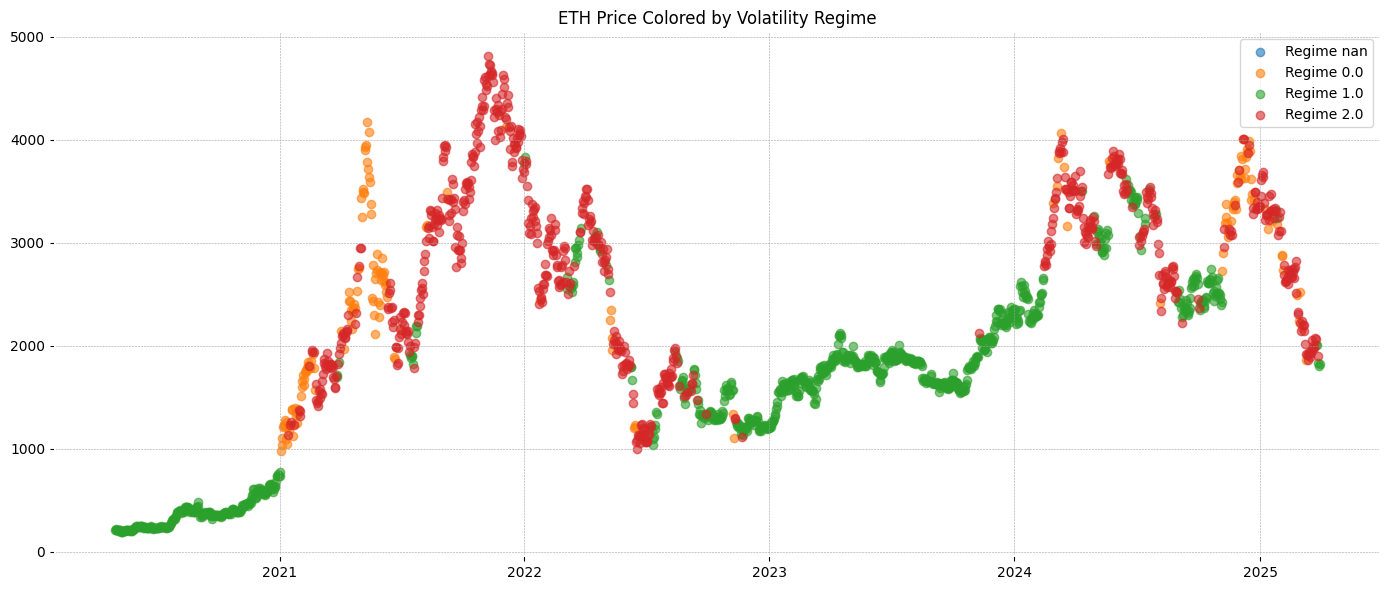

             30D_Vol        Volume
Vol_Regime                        
0.0         0.026949  4.844656e+08
1.0         0.123950  2.147092e+09
2.0         0.286138  7.587319e+09


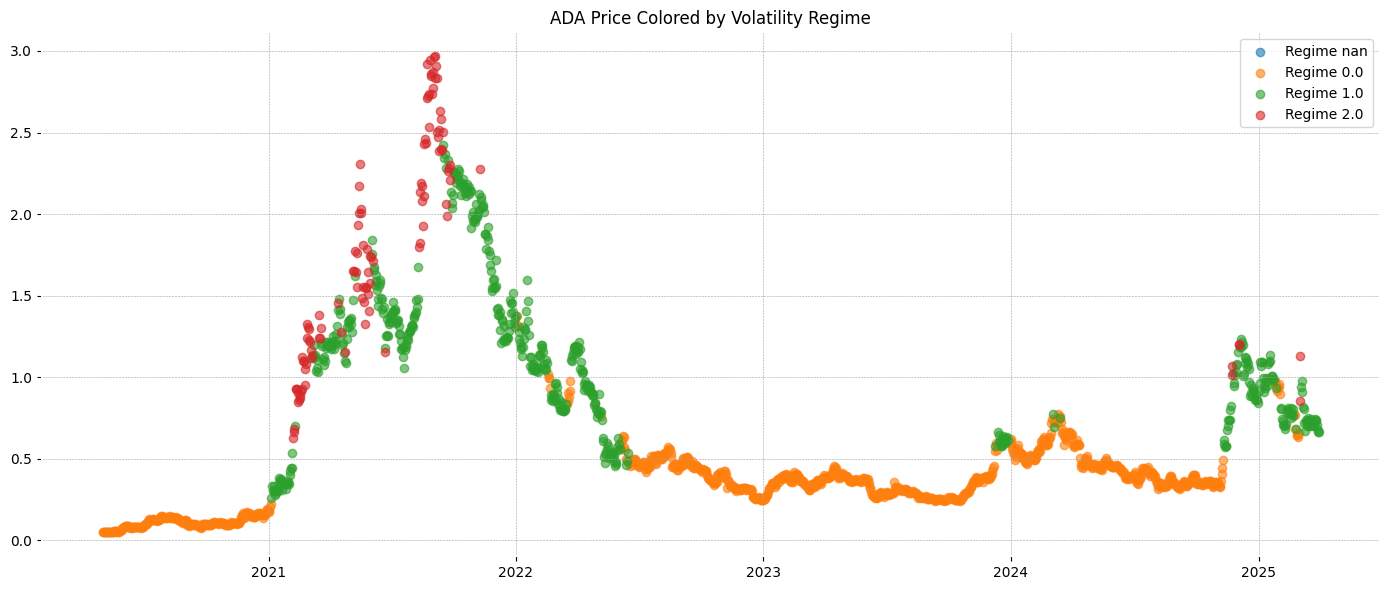

             30D_Vol        Volume
Vol_Regime                        
0.0         0.000010  3.159152e+09
1.0         0.000001  4.358972e+08
2.0         0.000011  1.820267e+10


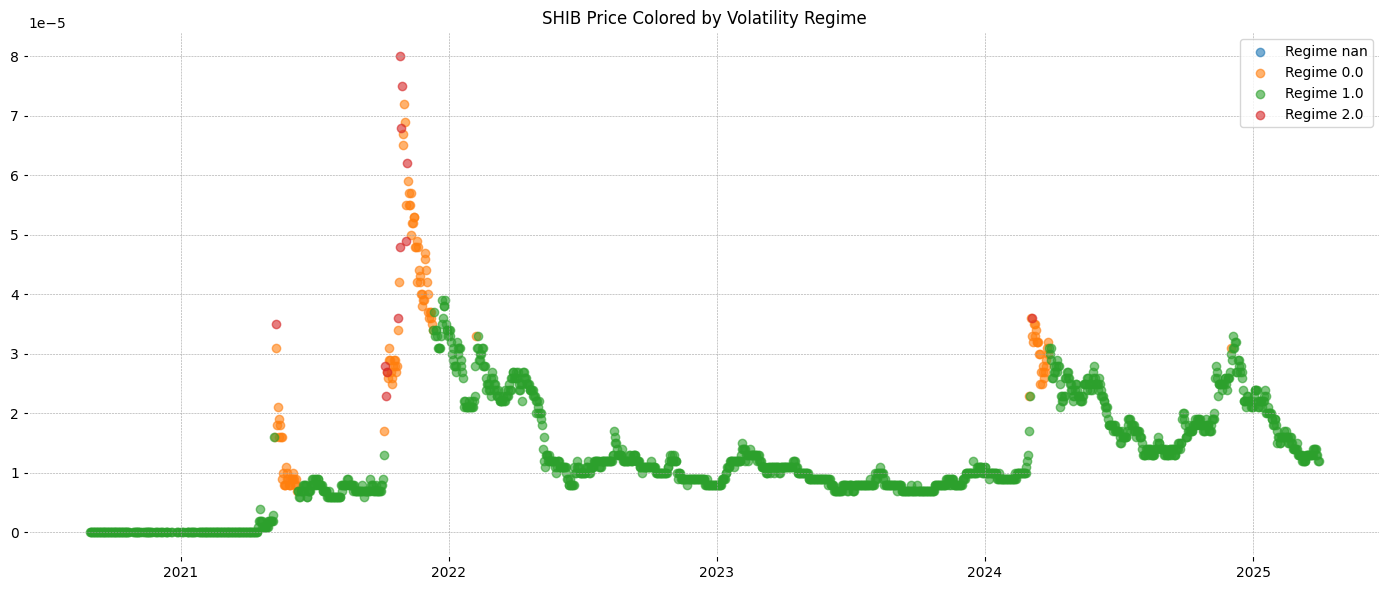

             30D_Vol        Volume
Vol_Regime                        
0.0         0.040362  1.821515e+09
1.0         0.391829  2.018632e+10
2.0         0.200701  7.940823e+09


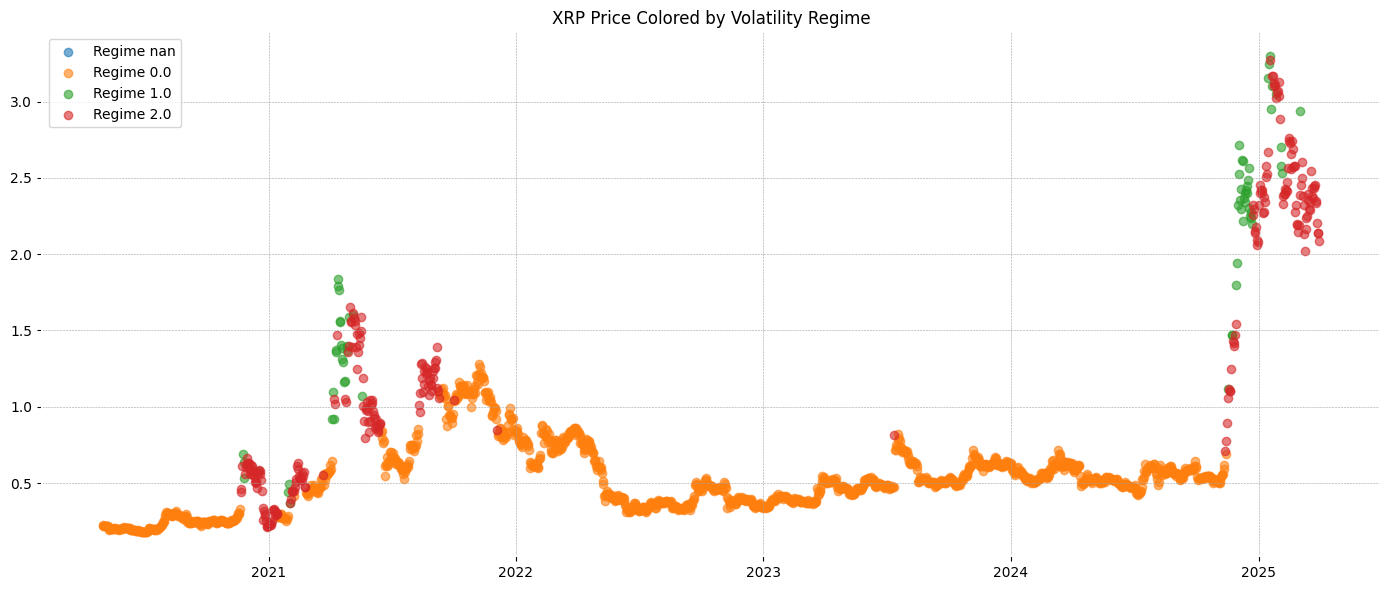

In [ ]:
#@title Volatility Regime Detection
from sklearn.cluster import KMeans

def analyze_volatility_regime(df, ticker, save_path_base='/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis'):
    """Analyzes volatility regimes using K-Means clustering and saves the plot."""

    # Calculate 30-day volatility
    df['30D_Vol'] = df['Close'].rolling(30).std()

    # Prepare features
    features = df[['30D_Vol', 'Volume']].dropna()
    # Store original index before standardizing
    original_index = features.index
    features = (features - features.mean()) / features.std()  # Standardize

    # K-Means Clustering
    kmeans = KMeans(n_clusters=3).fit(features)
    # Assign labels to the original index
    df['Vol_Regime'] = pd.Series(kmeans.labels_, index=original_index)

    # Print mean values for each regime
    print(df.groupby('Vol_Regime')[['30D_Vol', 'Volume']].mean())

    # Visualize
    plt.figure(figsize=(14, 6))
    for regime in sorted(df['Vol_Regime'].unique()):
        subset = df[df['Vol_Regime'] == regime]
        plt.scatter(subset.index, subset['Close'],
                   label=f'Regime {regime}',
                   alpha=0.6)
    plt.title(f'{ticker.upper()} Price Colored by Volatility Regime')
    plt.legend()
    plt.tight_layout()  # Adjust layout to ensure all elements are visible


    # Save the plot
    save_path = os.path.join(save_path_base, 'Volatility Regime')
    os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist
    file_path = os.path.join(save_path, f'{ticker}_volatility_regime.png')
    plt.savefig(file_path)
    plt.show() # Call plt.show() after plt.savefig()
    plt.close()

    # Save the plot (Redundant, removed)


# Call the function for each cryptocurrency
analyze_volatility_regime(btc, 'BTC')
analyze_volatility_regime(eth, 'ETH')
analyze_volatility_regime(ada, 'ADA')
analyze_volatility_regime(shib, 'SHIB')
analyze_volatility_regime(xrp, 'XRP')

**Volatility Regime Detection Insights**
---

 The graphs show the price of each cryptocurrency over time (from 2021 to 2025), with data points colored by their volatility regime. The volatility regimes are categorized as follows:

- **Regime 0.0** (orange): Low volatility
- **Regime 1.0** (green): Medium volatility
- **Regime 2.0** (red): High volatility
- **Regime nan** (blue): Undefined or missing volatility data

The tables provide the average 30-day volatility (`30D_Vol`) and trading volume (`Volume`) for each volatility regime. Let’s analyze each cryptocurrency.

---

Below are Markdown tables summarizing the Volatility Regime Detection data for BTC, ETH, ADA, SHIB, and XRP. The tables include the 30-day annualized volatility (30D_Vol, in USD) and trading volume (in USD) across three volatility regimes (0.0, 1.0, 2.0).

**BTC Volatility Regime Detection**

| Vol_Regime | 30D_Vol (USD)  | Volume (USD)  |
|------------|--------------|---------------|
| 0.0        | 3262.927358  | 33,176,740,000 |
| 1.0        | 1066.161078  | 23,849,150,000 |
| 2.0        | 5737.748374  | 69,667,670,000 |

**ETH Volatility Regime Detection**

| Vol_Regime | 30D_Vol (USD)  | Volume (USD)  |
|------------|--------------|---------------|
| 0.0        | 322.665714   | 42,615,780,000 |
| 1.0        | 81.773391    | 10,771,540,000 |
| 2.0        | 260.908215   | 19,404,980,000 |

**ADA Volatility Regime Detection**

| Vol_Regime | 30D_Vol (USD)  | Volume (USD)  |
|------------|--------------|---------------|
| 0.0        | 0.026949     | 484,465,600   |
| 1.0        | 0.123950     | 2,147,092,000 |
| 2.0        | 5737.748374  | 69,667,670,000 |

**SHIB Volatility Regime Detection**

| Vol_Regime | 30D_Vol (USD)   | Volume (USD)  |
|------------|--------------|---------------|
| 0.0        | 0.000010     | 3,159,152,000 |
| 1.0        | 0.000001     | 435,897,200   |
| 2.0        | 0.000011     | 18,202,670,000 |

**XRP Volatility Regime Detection**

| Vol_Regime | 30D_Vol(USD)   | Volume (USD)  |
|------------|--------------|---------------|
| 0.0        | 0.040362     | 1,821,515,000 |
| 1.0        | 0.391829     | 20,186,320,000 |
| 2.0        | 0.200701     | 7,940,823,000 |

---

**1. BTC (Bitcoin)**

 **Graph Analysis**
- **Price Trend**: Bitcoin starts around 30,000 USD in early 2021, peaks near 60,000 USD by late 2021, dips to around 20,000 USD in 2022, remains relatively stable through 2023, and then surges dramatically in 2024, reaching over 100,000 USD by early 2025.

- **Volatility Regimes**:
  - **Early 2021**: Mostly green (Regime 1.0, medium volatility) with some orange (Regime 0.0, low volatility).
  - **Late 2021**: A mix of red (Regime 2.0, high volatility) and orange, indicating a volatile period during the price peak.
  - **2022-2023**: Predominantly green (medium volatility) with occasional orange and red spikes, reflecting a more stable period with intermittent volatility.
  - **2024-2025**: As the price surges, we see a mix of red (high volatility) and orange (low volatility), suggesting that the rapid price increase came with significant volatility.

**Table Analysis**

- **Regime 0.0 (Low Volatility)**: Average 30-day volatility is 3262.93 USD (price fluctuation), with a trading volume of 33.18 billion USD.
- **Regime 1.0 (Medium Volatility)**: Volatility drops to 1066.16 USD, with a lower trading volume of 23.85 billion USD.
- **Regime 2.0 (High Volatility)**: Volatility spikes to 5737.75 USD, with a much higher trading volume of 69.67 billion USD.
- **Insight**: High volatility (Regime 2.0) periods are associated with the largest price swings and significantly higher trading volumes, which aligns with the red data points during the 2021 peak and the 2024-2025 surge.

---

**2. ETH (Ethereum)**
**Graph Analysis**

- **Price Trend**: Ethereum starts around 1,000 USD in early 2021, peaks near 4,800 USD by late 2021, drops to around 1,000 USD in 2022, remains stable through 2023, and then rises again in 2024, reaching around 4,000 USD by early 2025.
- **Volatility Regimes**:
  - **Early 2021**: Mostly orange (low volatility) with some red (high volatility) as the price rises.
  - **Late 2021**: Predominantly red (high volatility) during the peak, reflecting significant price swings.
  - **2022-2023**: Mostly green (medium volatility) with occasional orange and red, indicating a more stable period.
  - **2024-2025**: A mix of red (high volatility) and green (medium volatility) as the price rises again.

**Table Analysis**

- **Regime 0.0 (Low Volatility)**: 30-day volatility is 322.67 USD, with a trading volume of 42.62 billion USD.
- **Regime 1.0 (Medium Volatility)**: Volatility drops to 81.77 USD, with a much lower trading volume of 10.77 billion USD.
- **Regime 2.0 (High Volatility)**: Volatility rises to 260.91 USD, with a trading volume of 19.40 billion USD.
- **Insight**: High volatility periods (Regime 2.0) have higher price swings but lower trading volumes compared to low volatility periods, suggesting that ETH’s high volatility periods might not always attract the highest trading activity.

---

**3. SHIB (Shiba Inu)**
**Graph Analysis**

- **Price Trend**: SHIB starts near 0 USD in 2021, spikes dramatically to around 0.00008 USD in late 2021, crashes back down in 2022, and remains relatively flat through 2023-2025 with minor spikes (e.g., around 2024).
- **Volatility Regimes**:
  - **Early 2021**: Mostly green (medium volatility) with some orange (low volatility).
  - **Late 2021**: Predominantly red (high volatility) during the massive price spike.
  - **2022-2025**: Mostly green (medium volatility) with occasional orange and red spikes, reflecting a more stable but still occasionally volatile period.

**Table Analysis**

- **Regime 0.0 (Low Volatility)**: 30-day volatility is 0.000010 USD, with a trading volume of 3.16 billion USD.
- **Regime 1.0 (Medium Volatility)**: Volatility drops to 0.000001 USD, with a much lower trading volume of 435.90 million USD.
- **Regime 2.0 (High Volatility)**: Volatility rises to 0.000011 USD, with a significantly higher trading volume of 18.20 billion USD.
- **Insight**: High volatility periods (Regime 2.0) correspond to massive trading volume spikes, as seen during the 2021 price surge, indicating speculative trading during these periods.

---

**4. XRP (Ripple)**
**Graph Analysis**

- **Price Trend**: XRP starts around 0.50 USD in 2021, spikes to 1.50 USD in early 2021, drops to around 0.50 USD in 2022, remains stable through 2023-2024, and then surges to over 3.00 USD in early 2025.

- **Volatility Regimes**:
  - **Early 2021**: A mix of red (high volatility) and orange (low volatility) during the price spike.
  - **2022-2024**: Mostly orange (low volatility) with occasional green and red, indicating a stable period.
  - **Early 2025**: Predominantly red (high volatility) as the price surges.

**Table Analysis**

- **Regime 0.0 (Low Volatility)**: 30-day volatility is 0.040 USD, with a trading volume of 1.82 billion USD.
- **Regime 1.0 (Medium Volatility)**: Volatility jumps to 0.392 USD, with a much higher trading volume of 20.19 billion USD.
- **Regime 2.0 (High Volatility)**: Volatility is 0.201 USD, with a trading volume of 7.94 billion USD.
- **Insight**: Medium volatility (Regime 1.0) periods have the highest trading volume, which is unusual compared to the other cryptocurrencies where high volatility typically drives the most volume. This might reflect specific market dynamics for XRP, such as regulatory news or adoption events.

---

 **5. ADA (Cardano)**

**Graph Analysis**
- **Price Trend**: ADA starts around 0.30 USD in 2021, peaks near 3.00 USD in late 2021, drops to around 0.30 USD in 2022, and remains relatively flat through 2023-2025 with minor fluctuations.

- **Volatility Regimes**:
  - **Early 2021**: Mostly orange (low volatility) with some red (high volatility) as the price rises.
  - **Late 2021**: Predominantly red (high volatility) during the peak.
  - **2022-2025**: Mostly orange (low volatility) with occasional green and red, indicating a stable period with minor volatility spikes.

**Table Analysis**

- **Regime 0.0 (Low Volatility)**: 30-day volatility is 0.027 USD, with a trading volume of 484.47 million USD.
- **Regime 1.0 (Medium Volatility)**: Volatility rises to 0.124 USD, with a trading volume of 2.15 billion USD.
- **Regime 2.0 (High Volatility)**: Volatility spikes to 0.286 USD, with a trading volume of 7.59 billion USD.
- **Insight**: High volatility periods (Regime 2.0) are associated with the largest price swings and significantly higher trading volumes, as seen during the 2021 peak.

---

**General Observations and Comparisons**

1. **Volatility and Price Movements**:
   - Across all cryptocurrencies, high volatility (Regime 2.0, red) often coincides with significant price peaks (e.g., late 2021 for most coins, early 2025 for BTC and XRP). This suggests that rapid price increases or decreases are typically accompanied by high volatility.
   - Low volatility (Regime 0.0, orange) periods often occur during price consolidation phases (e.g., 2022-2023 for most coins).

2. **Trading Volume**:
   - For BTC, SHIB, and ADA, high volatility periods (Regime 2.0) are associated with the highest trading volumes, indicating speculative trading during these times.
   - For ETH, low volatility periods (Regime 0.0) have the highest trading volume, which might reflect more stable, long-term investor activity.
   - For XRP, medium volatility (Regime 1.0) drives the highest trading volume, possibly due to specific market events like regulatory developments.

3. **Price Trends**:
   - BTC and ETH show significant growth by 2025, with BTC surpassing 100,000 USD and ETH reaching around 4,000 USD.
   - XRP also shows a strong upward trend in 2025, reaching over 3.00 USD.
   - SHIB and ADA, however, remain relatively flat after their 2021 peaks, with SHIB showing more volatility spikes due to its meme coin nature.

4. **Volatility Regimes**:
   - The classification of volatility regimes varies across coins. For example, BTC’s high volatility regime (5737.75 USD) is much larger in absolute terms compared to SHIB’s (0.000011 USD), which makes sense given the difference in price scales.

---

**Conclusion**

These graphs and data provide a clear picture of how volatility regimes correlate with price movements and trading volumes for each cryptocurrency:
- **BTC and ETH** exhibit strong growth with high volatility during major price surges, reflecting their status as leading cryptocurrencies.
- **SHIB** shows extreme volatility during its 2021 spike, typical of meme coins, but remains flat afterward.
- **XRP** has a unique pattern where medium volatility drives the highest trading volume, possibly due to external factors like regulatory news.
- **ADA** follows a similar pattern to SHIB, with a significant peak in 2021 followed by a stable, low-volatility period.

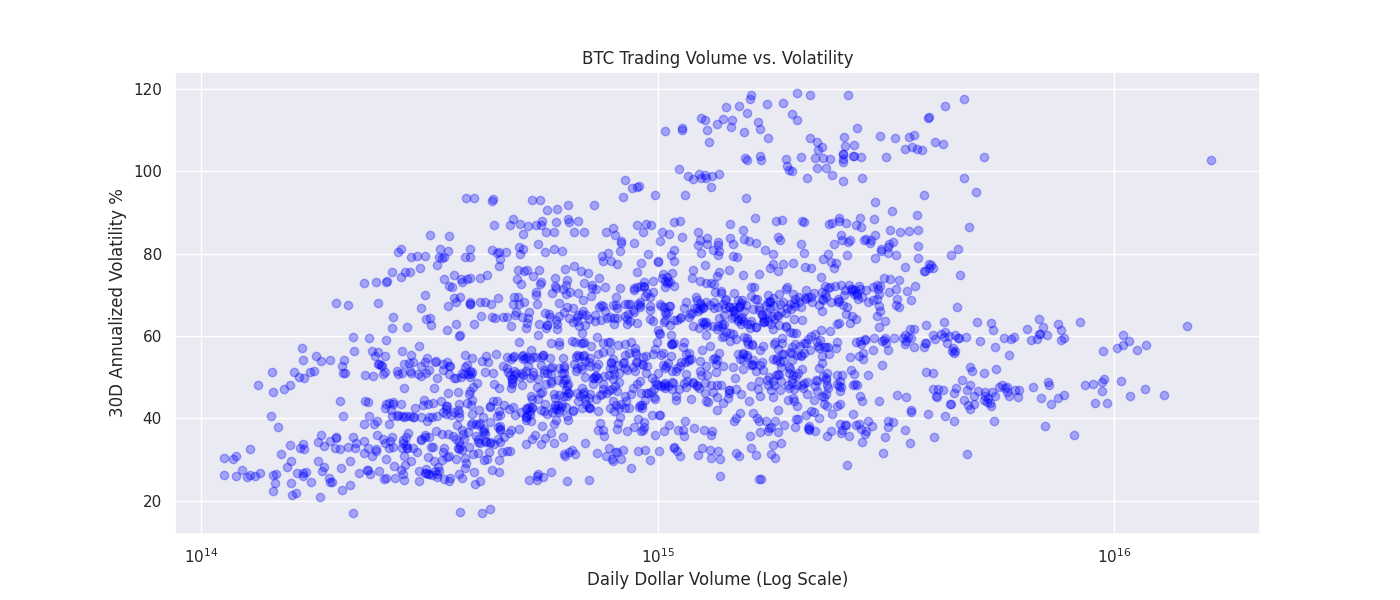

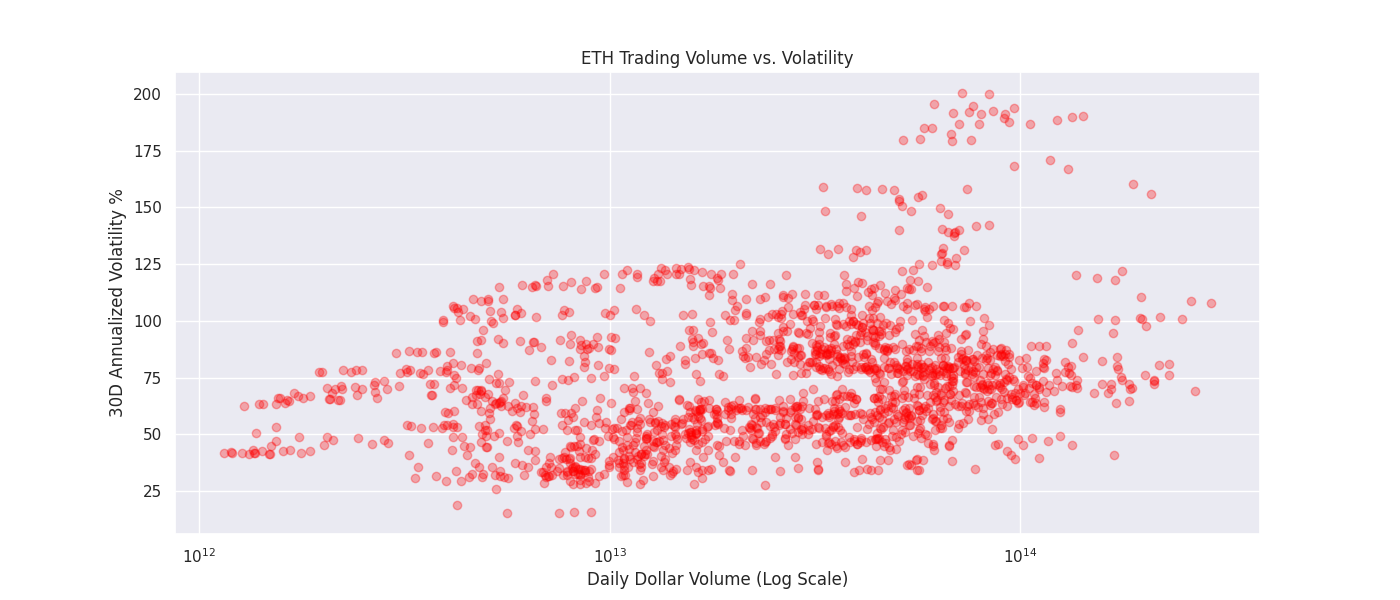

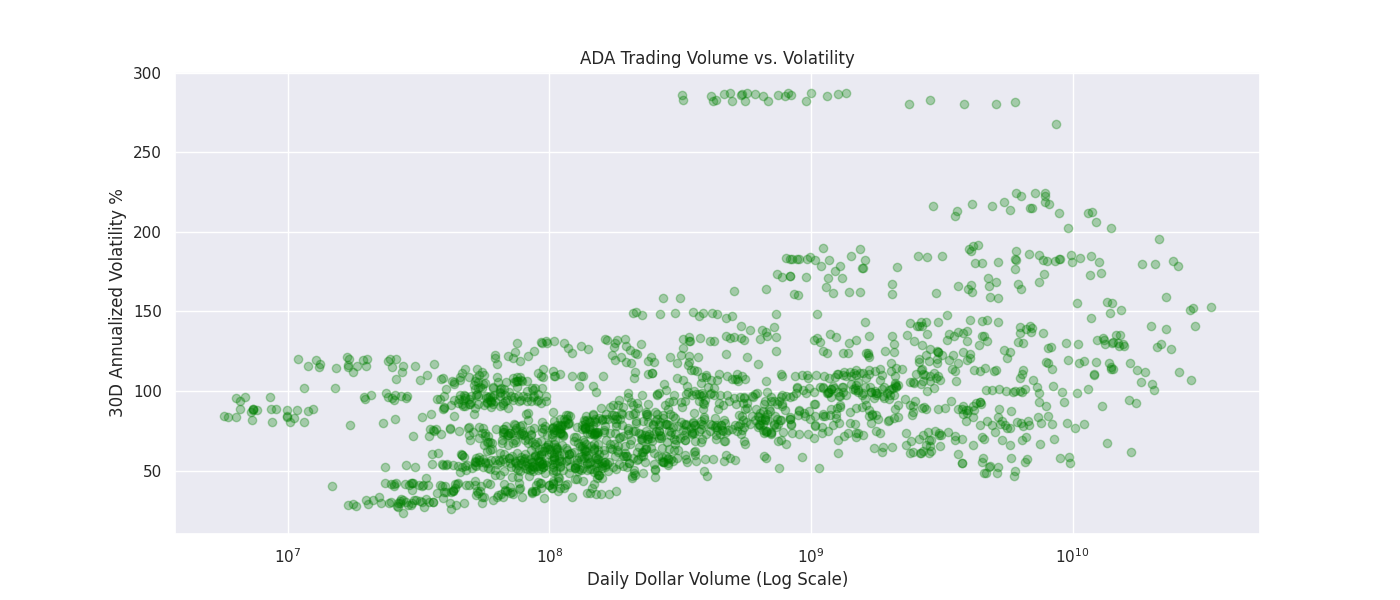

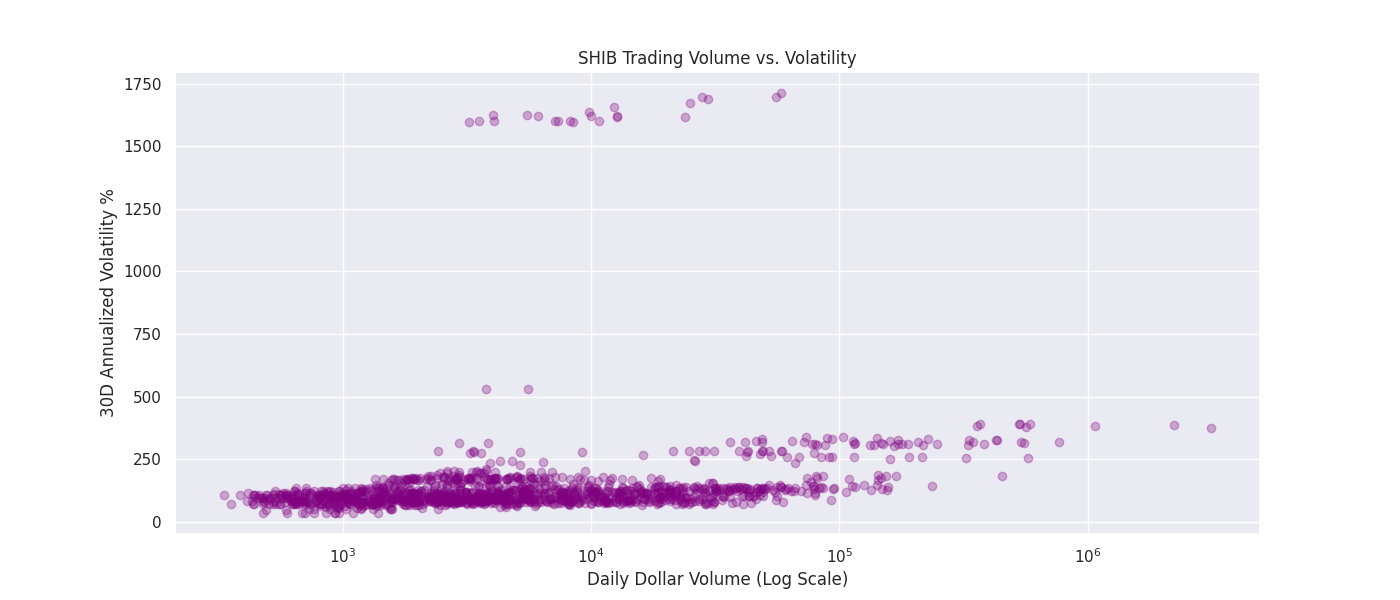

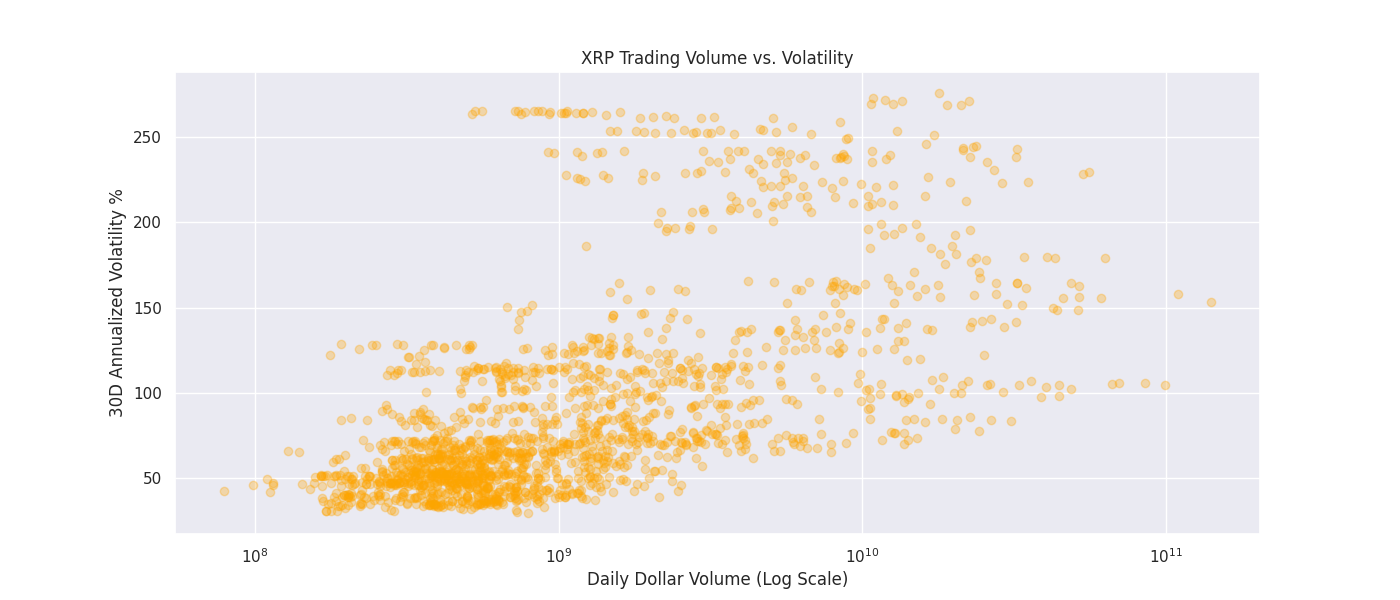

In [ ]:
# @title Volume-Volatility Relationship

def volume_volatility_analysis(df, ticker, save_path_base='/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis'):
    """Analyze volume-volatility relationship and save the plot."""

    # Calculate daily returns for volatility
    df['Daily_Return'] = df['Close'].pct_change()

    # Calculate 30-day rolling standard deviation for volatility
    df['30D_Vol'] = df['Daily_Return'].rolling(window=30).std() * np.sqrt(365) * 100 # Annualize and convert to %

    # Calculate dollar volume
    df['Dollar_Volume'] = df['Close'] * df['Volume']

    # Define colors for each cryptocurrency
    colors = {
        'BTC': 'blue',
        'ETH': 'red',
        'ADA': 'green',
        'SHIB': 'purple',
        'XRP': 'orange'
    }

    # Create the plot
    plt.figure(figsize=(14, 6))
    plt.scatter(df['Dollar_Volume'], df['30D_Vol'], alpha=0.3, color=colors[ticker]) # Use specific color
    plt.xscale('log')  # Handle wide volume range
    plt.title(f'{ticker} Trading Volume vs. Volatility')
    plt.xlabel('Daily Dollar Volume (Log Scale)')
    plt.ylabel('30D Annualized Volatility %')

    # Create save path
    save_path = os.path.join(save_path_base, 'volume - volatility relationship')
    os.makedirs(save_path, exist_ok=True)

    # Save the plot
    file_path = os.path.join(save_path, f'{ticker}_volume_volatility.png')
    plt.savefig(file_path)
    plt.close()

# Call the function for each cryptocurrency
volume_volatility_analysis(btc, 'BTC')
volume_volatility_analysis(eth, 'ETH')
volume_volatility_analysis(ada, 'ADA')
volume_volatility_analysis(shib, 'SHIB')
volume_volatility_analysis(xrp, 'XRP')

folder_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/volume - volatility relationship'

for filename in os.listdir(folder_path):
  if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Check for image file extensions
    image_path = os.path.join(folder_path, filename)
    display(Image(filename=image_path))

**Volume vs. Volatility Trends**
---

**General Trend**:

In crypto markets, higher trading volume often correlates with increased volatility due to heightened activity, but the strength of this relationship varies by asset.

**Cryptocurrency Insights**

1. **ADA (Cardano, Green)**  
   - Volume: 10^7 to 10^10 USD (10 million to 10 billion USD).  
   - Volatility: Mostly 50%–150%, with outliers up to 300%.  
   - Insight: Volatility is higher at lower volumes (10^7–10^8 USD, often 100%–150%), suggesting low liquidity drives price swings. At higher volumes, volatility stabilizes somewhat (50%–150%), showing no strong correlation.

2. **BTC (Bitcoin, Blue)**  
   - Volume: 10^14 to 10^16 USD (likely a labeling error; more realistic is 10^10 to 10^12 USD, i.e., 10 billion to 1 trillion USD).  
   - Volatility: 20%–100%, rarely above 120%.  
   - Insight: Bitcoin has the lowest volatility, with a slight inverse relationship—higher volumes (e.g., 10^15 USD) often correspond to lower volatility (40%–80%). This reflects a mature market where high volumes may stabilize prices.

3. **ETH (Ethereum, Red)**  
   - Volume: 10^12 to 10^14 USD (likely a labeling error; more realistic is 10^9 to 10^11 USD, i.e., 1 billion to 100 billion USD).  
   - Volatility: 25%–125%, with outliers up to 200%.  
   - Insight: Volatility is moderate but variable across volumes. Lower volumes (10^12 USD) can see spikes (150%–200%), while higher volumes show no clear trend (50%–100%). External factors like DeFi activity likely drive volatility more than volume.

4. **SHIB (Shiba Inu, Purple)**  
   - Volume: 10^3 to 10^6 USD (1,000 to 1 million USD).  
   - Volatility: 0%–1750%, the highest range.  
   - Insight: SHIB shows extreme volatility at low volumes (10^3–10^4 USD, up to 1750%), typical of a low-liquidity meme coin. Higher volumes reduce volatility (below 500%), indicating a strong inverse relationship due to liquidity effects.

5. **XRP (Ripple, Yellow)**  
   - Volume: 10^8 to 10^11 USD (100 million to 100 billion USD).  
   - Volatility: 50%–150%, with outliers up to 250%.  
   - Insight: Volatility is moderate, with higher values at lower volumes (10^8 USD, 100%–150%). No strong volume-volatility trend, suggesting external factors like regulatory news influence price swings.

 Comparative Insights

- **Volatility Spectrum**: SHIB is the most volatile (up to 1750%), reflecting its speculative nature. BTC is the least volatile (20%–100%), showing market maturity. ADA, ETH, and XRP are mid-range (50%–150%).

- **Volume-Volatility Link**: SHIB and BTC show clearer relationships—SHIB’s volatility drops with higher volumes due to liquidity, while BTC’s high volumes slightly reduce volatility, indicating stability. ADA, ETH, and XRP show weaker correlations, likely due to external drivers (e.g., network activity, news).

- **Market Dynamics**: Smaller coins like SHIB suffer from low liquidity, causing extreme volatility at low volumes. Larger coins like BTC and ETH are more resilient, with higher volumes often linked to broader participation and less erratic price movements.

**Broader Takeaway**
The volume-volatility relationship in crypto varies by asset. Low-liquidity coins like SHIB see massive price swings at low volumes, while mature assets like BTC show more stability with higher volumes. For ADA, ETH, and XRP, volatility is less tied to volume, pointing to the influence of external factors like market sentiment or ecosystem developments. Note that BTC and ETH volume ranges may be mislabeled (likely 10^10–10^12 USD for BTC, 10^9–10^11 USD for ETH), but the patterns hold.

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


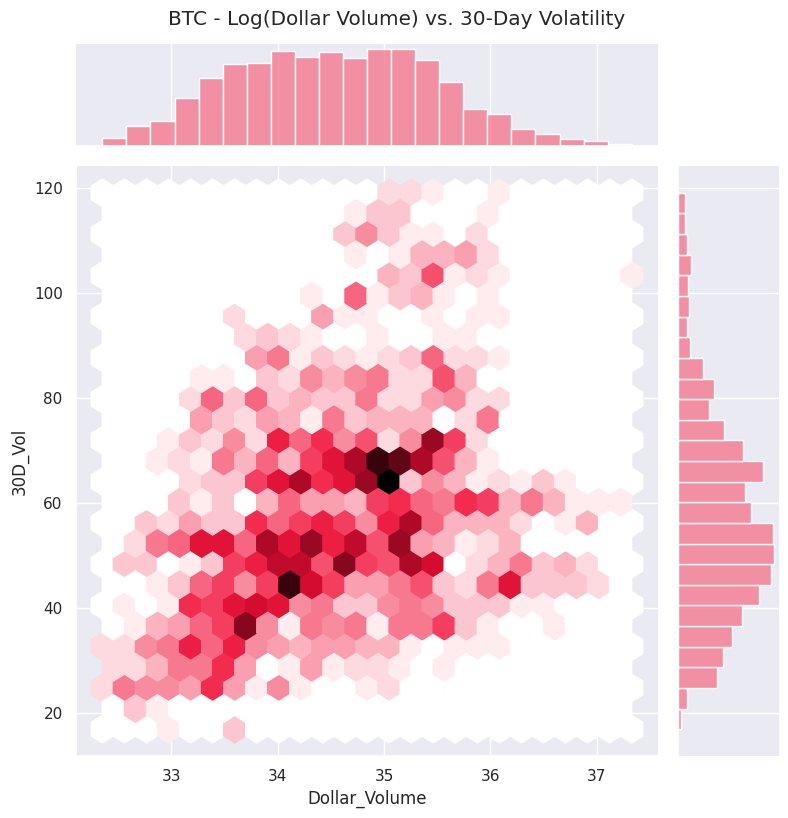

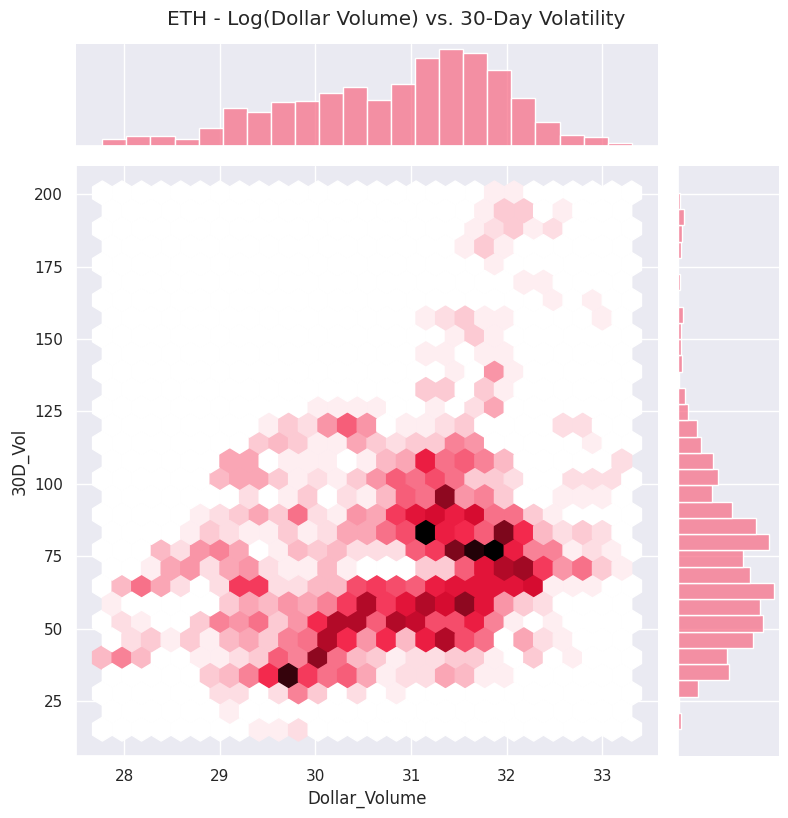

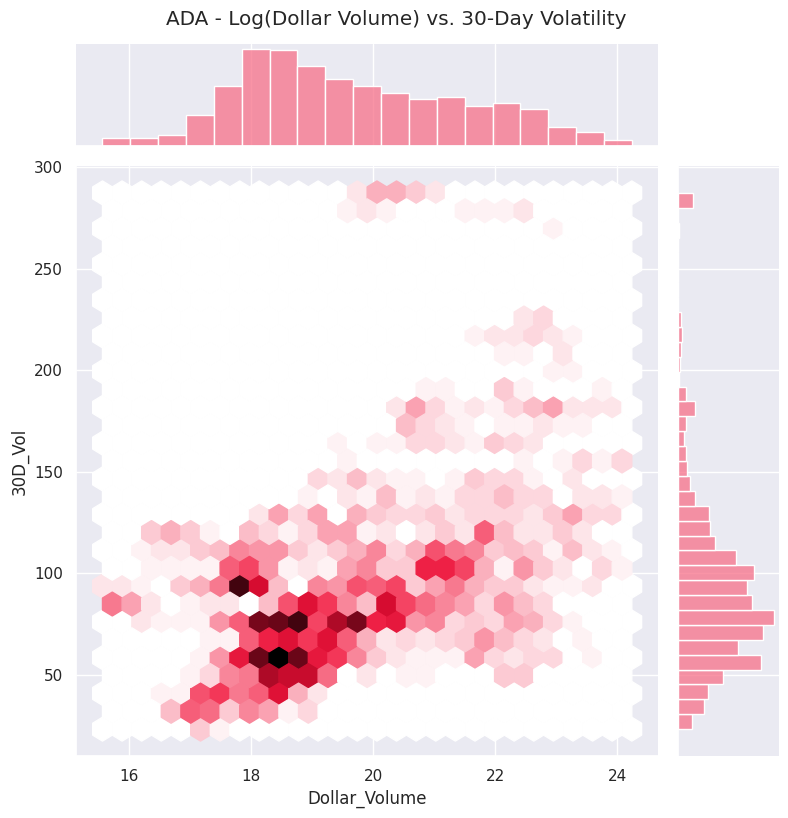

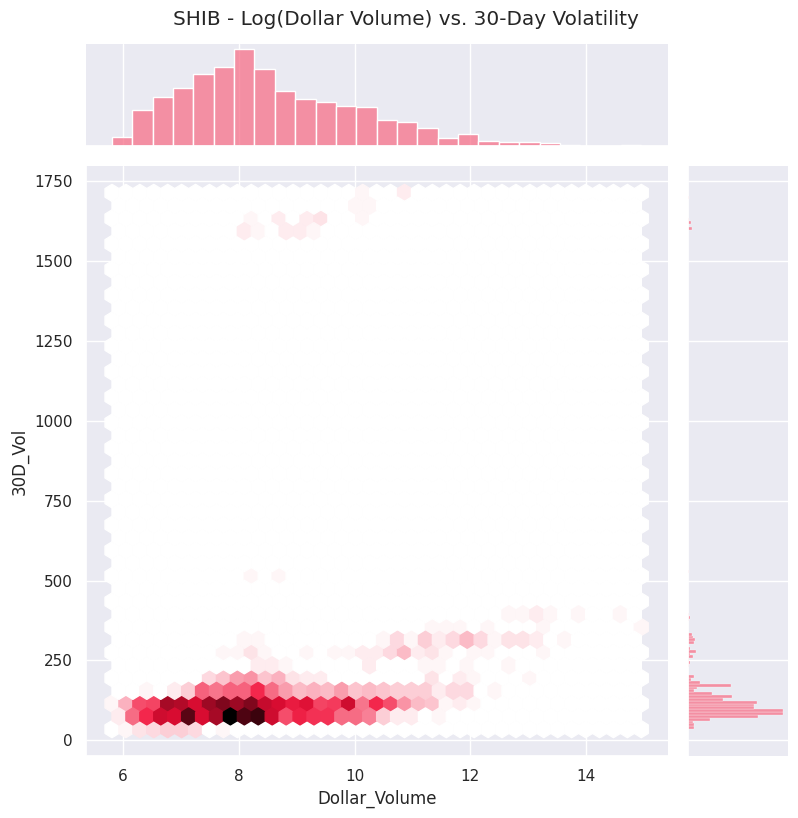

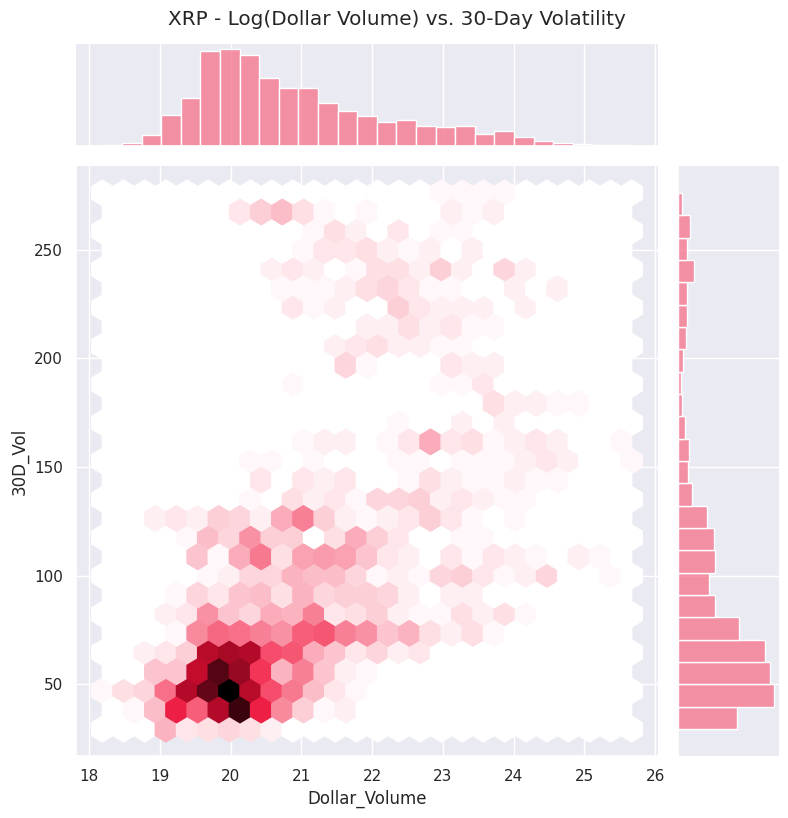

In [ ]:
# @title Advanced Volume-Volatility Relationship

def plot_volume_volatility(df, ticker, save_path):
    """Plots volume-volatility relationship and saves the plot."""

    # Calculate 30-day volatility (if not already present)
    if '30D_Vol' not in df.columns:
        df['30D_Vol'] = df['Close'].rolling(window=30).std() / df['Close'].rolling(window=30).mean() * 100

    # Create the jointplot
    sns_plot = sns.jointplot(x=np.log(df['Dollar_Volume']),
                         y=df['30D_Vol'],
                         kind='hex',
                         height=8)

    # Set plot title
    sns_plot.fig.suptitle(f'{ticker} - Log(Dollar Volume) vs. 30-Day Volatility', y=1.02)

    # Save the plot
    os.makedirs(save_path, exist_ok=True)
    file_path = os.path.join(save_path, f'{ticker}_volume_volatility.png')
    sns_plot.savefig(file_path)

# Set the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/advanced volume volatility plot'

# Call the function for each cryptocurrency
plot_volume_volatility(btc, 'BTC', save_path)
plot_volume_volatility(eth, 'ETH', save_path)
plot_volume_volatility(ada, 'ADA', save_path)
plot_volume_volatility(shib, 'SHIB', save_path)
plot_volume_volatility(xrp, 'XRP', save_path)

**Advanced Volume-Volatility Relationship Insights**
---

Each plot uses a hexbin visualization where darker red areas indicate higher data point density. The marginal histograms along the top and right sides show the distribution of each variable independently.

**Key observations for each cryptocurrency:**

1. **ADA (Cardano)**: Shows volatility mostly between 40-120%, concentrated around log dollar volumes of 17-22. There appears to be a slight negative correlation between volume and volatility for the densest data points.

2. **BTC (Bitcoin)**: Displays lower volatility (mostly 30-70%) than many other cryptocurrencies, with higher trading volumes (log values 34-36). The relationship forms a more compact cluster, suggesting Bitcoin's relative stability despite high trading volumes.

3. **ETH (Ethereum)**: Shows volatility typically between 50-100% at log dollar volumes around 30-32. The pattern appears similar to Bitcoin but with slightly higher volatility.

4. **SHIB (Shiba Inu)**: Shows dramatically higher volatility (up to 1750%) and lower volumes (log values 7-12) compared to the major cryptocurrencies. The densest concentration appears at very low volume and relatively low volatility (around 100%), but with numerous outliers showing extreme volatility.

5. **XRP (Ripple)**: Shows its densest concentration at relatively low volatility (40-70%) and log dollar volumes around 19-20, with scattered data points extending toward higher volatility.

**General trends across cryptocurrencies:**
- Larger, more established cryptocurrencies (BTC, ETH) tend to show lower volatility despite higher trading volumes.
- Smaller or newer cryptocurrencies (particularly SHIB) demonstrate much higher volatility, especially at lower trading volumes.
- There's a general pattern suggesting that as volume increases, extreme volatility tends to decrease (though the relationship isn't perfectly linear).
- Each cryptocurrency has its own characteristic "signature" in terms of its volume-volatility relationship.

These relationships suggest that market maturity and liquidity (reflected in higher trading volumes) generally correspond with more stable price action.

Columns found in btc data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date           2020-04-02
Unnamed: 1    6793.624512
Unnamed: 2    7088.247559
Unnamed: 3    6595.918457
Unnamed: 4    6606.776367
Unnamed: 5    47660646124
Name: 0, dtype: object
Columns found in eth data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date           2020-04-02
Unnamed: 1     142.029144
Unnamed: 2     146.787094
Unnamed: 3     135.732178
Unnamed: 4     135.732178
Unnamed: 5    15322861686
Name: 0, dtype: object
Columns found in ada data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date          2020-04-02
Unnamed: 1      0.031984
Unnamed: 2      0.033057
Unnamed: 3      0.030841
Unnamed: 4      0.030841
Unnamed: 5     106987595
Name: 0, dtype: object
Columns found in shib data: ['D

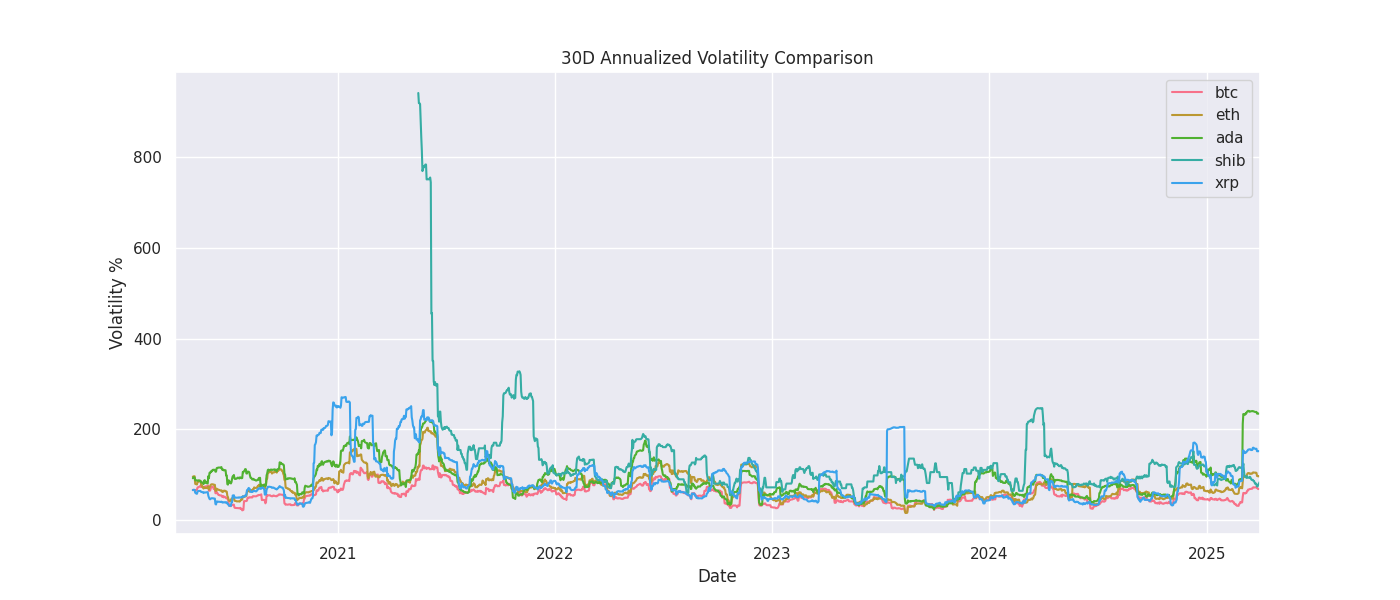

In [ ]:
#@title Cross Asset Volatility comparison

def calculate_volatility(df):
    """Calculates the 30-day annualized volatility."""
    df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))
    df['30D_Vol'] = df['Log_Ret'].rolling(window=30).std() * np.sqrt(365) * 100  # Annualized
    return df

def compare_volatility(tickers, save_path):
    """
    Compares the 30-day annualized volatility of multiple cryptocurrencies
    and saves the plot to a specified folder.
    """
    vol_data = pd.DataFrame()

    for t in tickers:
        df = load_crypto_data(t)
        df = calculate_volatility(df)
        vol_data[t] = df['30D_Vol']

    # Plot
    vol_data.plot(figsize=(14,6), title='30D Annualized Volatility Comparison')
    plt.ylabel('Volatility %')

    # Create the save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Save the plot
    save_file = os.path.join(save_path, 'volatility_comparison.png')
    plt.savefig(save_file)
    plt.close()  # Close the plot to avoid displaying in the notebook

# Define the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/cross asset volatility comparison'

# Call the function with the tickers and save path
compare_volatility(['btc','eth','ada', 'shib', 'xrp'], save_path)


folder_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/cross asset volatility comparison'

for filename in os.listdir(folder_path):
  if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Check for image file extensions
    image_path = os.path.join(folder_path, filename)
    display(Image(filename=image_path))

**Cross Asset Volatility Comparison Insights**
---

- **Overall Trend**: Volatility for all coins peaks dramatically in early 2021, with SHIB (cyan) spiking to 800%, while others range between 100%–200%. After this peak, volatility generally declines, stabilizing below 100% for most coins by 2022, with occasional spikes.

- **SHIB (Cyan)**: Exhibits the highest volatility, peaking at 800% in 2021 and showing multiple spikes (e.g., 200% in 2022 and 2024). This reflects its speculative, low-liquidity nature as a meme coin, prone to extreme price swings.

- **BTC (Red) and ETH (Orange)**: Both show lower volatility compared to SHIB, peaking around 150%–200% in 2021, then stabilizing between 20%–80% from 2022 onward. This indicates greater market maturity and stability, with fewer extreme fluctuations.

- **ADA (Green) and XRP (Blue)**: These mid-tier coins have volatility patterns similar to BTC and ETH, peaking at 150%–200% in 2021, then mostly staying between 50%–100%. They show occasional spikes (e.g., XRP at 200% in 2024), likely tied to specific events like regulatory news for XRP.

- **Post-2021 Behavior**: After the 2021 peak, volatility across all coins trends downward, reflecting a broader crypto market stabilization. However, SHIB remains the most volatile, while BTC and ETH consistently show the least volatility, rarely exceeding 80% after 2021.

**Takeaway**

The plot highlights SHIB’s extreme volatility due to its speculative nature, while BTC and ETH exhibit more stability as mature assets. ADA and XRP fall in between, with volatility influenced by market events. The overall decline in volatility post-2021 suggests a maturing crypto market, though smaller coins like SHIB remain prone to sharp price swings.

Columns found in btc data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date           2020-04-02
Unnamed: 1    6793.624512
Unnamed: 2    7088.247559
Unnamed: 3    6595.918457
Unnamed: 4    6606.776367
Unnamed: 5    47660646124
Name: 0, dtype: object
Columns found in eth data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date           2020-04-02
Unnamed: 1     142.029144
Unnamed: 2     146.787094
Unnamed: 3     135.732178
Unnamed: 4     135.732178
Unnamed: 5    15322861686
Name: 0, dtype: object
Columns found in ada data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date          2020-04-02
Unnamed: 1      0.031984
Unnamed: 2      0.033057
Unnamed: 3      0.030841
Unnamed: 4      0.030841
Unnamed: 5     106987595
Name: 0, dtype: object
Columns found in shib data: ['D

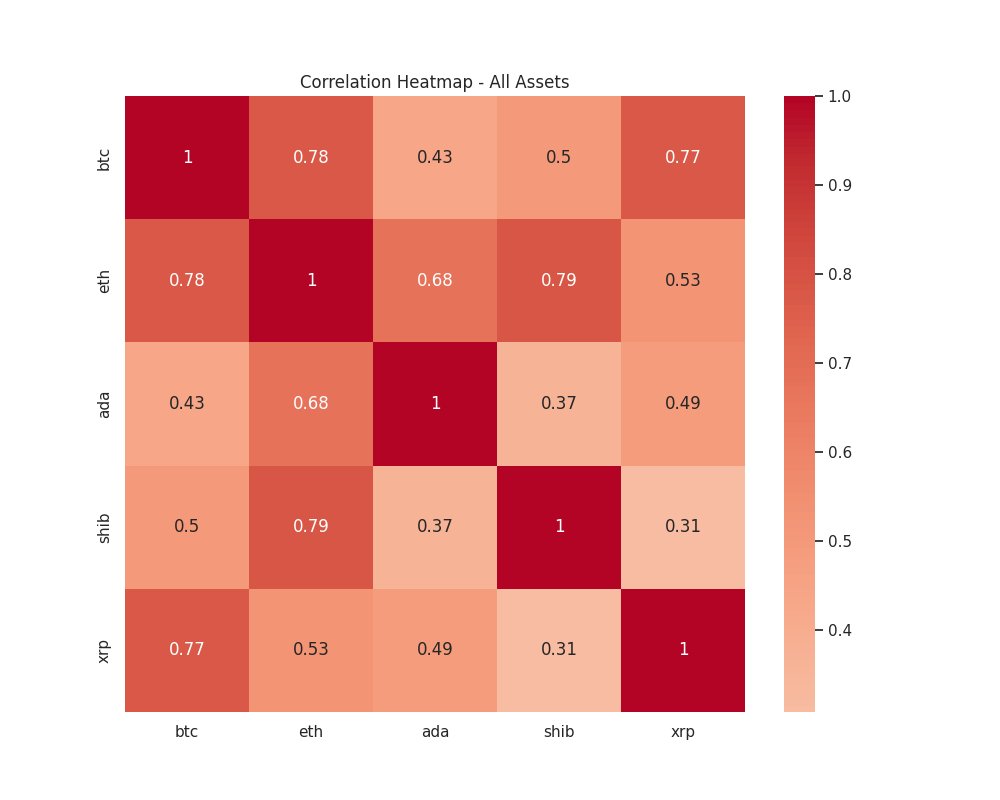

In [ ]:
# @title Correlation Analysis

def calculate_volatility(df):
    """Calculates the 30-day annualized volatility."""
    df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))
    df['30D_Vol'] = df['Log_Ret'].rolling(window=30).std() * np.sqrt(365) * 100  # Annualized
    return df


def correlation_analysis(tickers, save_path):
    """
    Performs correlation analysis and saves heatmaps for each cryptocurrency
    in a specified folder.
    """

    # Load data for all tickers and calculate volatility
    all_data = {}  # Dictionary to store dataframes for all tickers
    for ticker in tickers:
        df = load_crypto_data(ticker)  # Assuming load_crypto_data function is defined
        df = calculate_volatility(df)
        all_data[ticker] = df['Close']  # Store only 'Close' prices

    # Create a single dataframe with close prices for all tickers
    combined_df = pd.DataFrame(all_data)

    # Calculate correlation matrix
    corr_matrix = combined_df.corr()

    # Create and save heatmap for all assets
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap - All Assets')
    os.makedirs(save_path, exist_ok=True)  # Create save directory if needed
    plt.savefig(os.path.join(save_path, 'correlation_heatmap_all_assets.png'))
    plt.close()

    plt.show()

# Define the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/correlation analysis'

# Call the function for correlation analysis
correlation_analysis(['btc', 'eth', 'ada', 'shib', 'xrp'], save_path)

folder_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/correlation analysis'

for filename in os.listdir(folder_path):
  if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Check for image file extensions
    image_path = os.path.join(folder_path, filename)
    display(Image(filename=image_path))

**Cryptocurrency Correlation Analysis**
---

This heatmap displays the correlation coefficients between five major cryptocurrencies: Bitcoin (BTC), Ethereum (ETH), Cardano (ADA), Shiba Inu (SHIB), and Ripple (XRP).

**Key Observations:**

- **Strongest Correlations:**
  - ETH-SHIB: 0.79 (highest non-self correlation)
  - BTC-ETH: 0.78
  - BTC-XRP: 0.77
  - ETH-ADA: 0.68

- **Weakest Correlations:**
  - SHIB-XRP: 0.31 (lowest correlation)
  - SHIB-ADA: 0.37
  - BTC-ADA: 0.43
  - ADA-XRP: 0.49

**Pattern Analysis:**

1. **Ethereum's Central Role:** ETH shows strong correlations with most other cryptocurrencies (0.78 with BTC, 0.79 with SHIB, 0.68 with ADA), suggesting it may function as a connecting element in the crypto ecosystem.

2. **Bitcoin's Influence:** BTC has strong correlations with ETH (0.78) and XRP (0.77), but surprisingly moderate correlation with ADA (0.43) and SHIB (0.50).

3. **Market Segments:** The data suggests potential market segmentation:
   - BTC, ETH, and XRP form a highly correlated group (traditional/established cryptocurrencies)
   - SHIB and ADA show weaker correlations with others except for SHIB's strong connection to ETH (0.79)

4. **Independence:** ADA shows the most independence, with no correlation above 0.68 (with ETH) and generally lower correlations across the board.

This correlation matrix indicates that while cryptocurrency prices generally move together to some degree, there are distinct patterns that likely reflect differences in market perception, use cases, and investor bases across these digital assets.

BTC Volatility Forecast: h.1    7.353750
h.2    7.448382
h.3    7.539884
h.4    7.628357
h.5    7.713903
Name: 2025-03-31 00:00:00, dtype: float64
Saved BTC GARCH plot to /content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/GARCH Model plot/BTC_garch_volatility.png
ETH Volatility Forecast: h.1    12.981131
h.2    13.094276
h.3    13.204931
h.4    13.313150
h.5    13.418988
Name: 2025-03-31 00:00:00, dtype: float64
Saved ETH GARCH plot to /content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/GARCH Model plot/ETH_garch_volatility.png
ADA Volatility Forecast: h.1    18.365538
h.2    19.295015
h.3    20.200559
h.4    21.082785
h.5    21.942295
Name: 2025-03-31 00:00:00, dtype: float64
Saved ADA GARCH plot to /content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/GARCH Model plot/ADA_garch_volatility.png
XRP Volatility Forecast: h.1    18.586405
h.2    25.372660
h.3    31.246878
h.4    36.331632
h.5    40.733022
Name: 2025

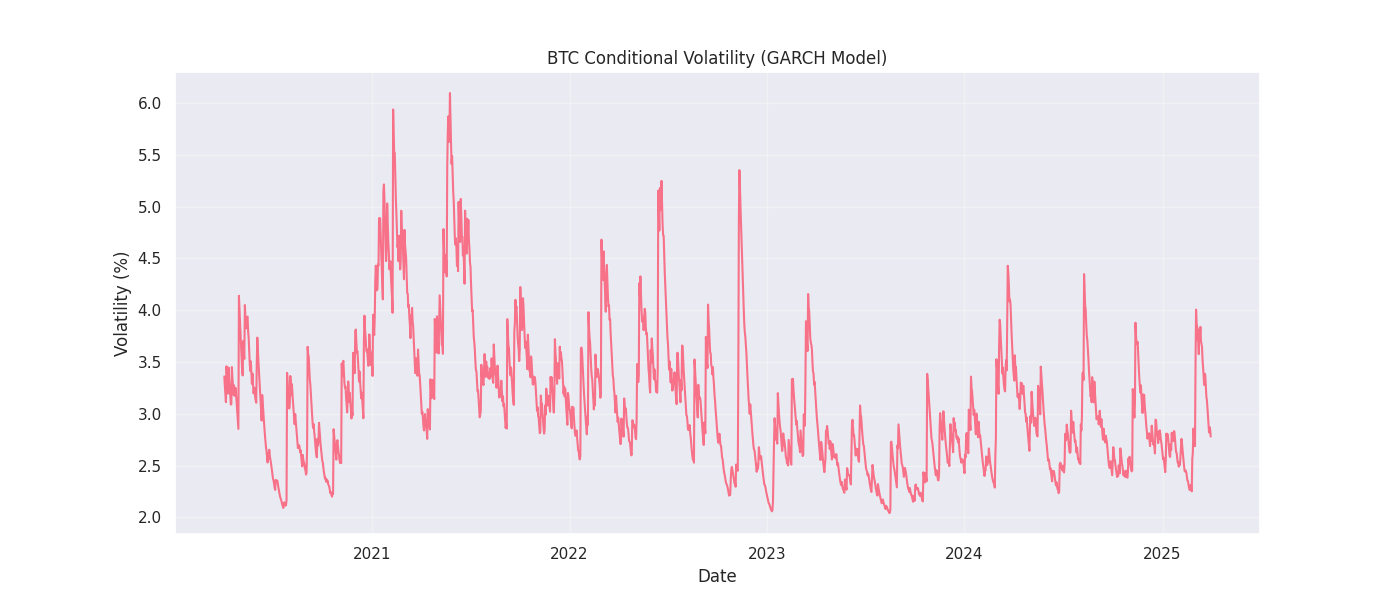

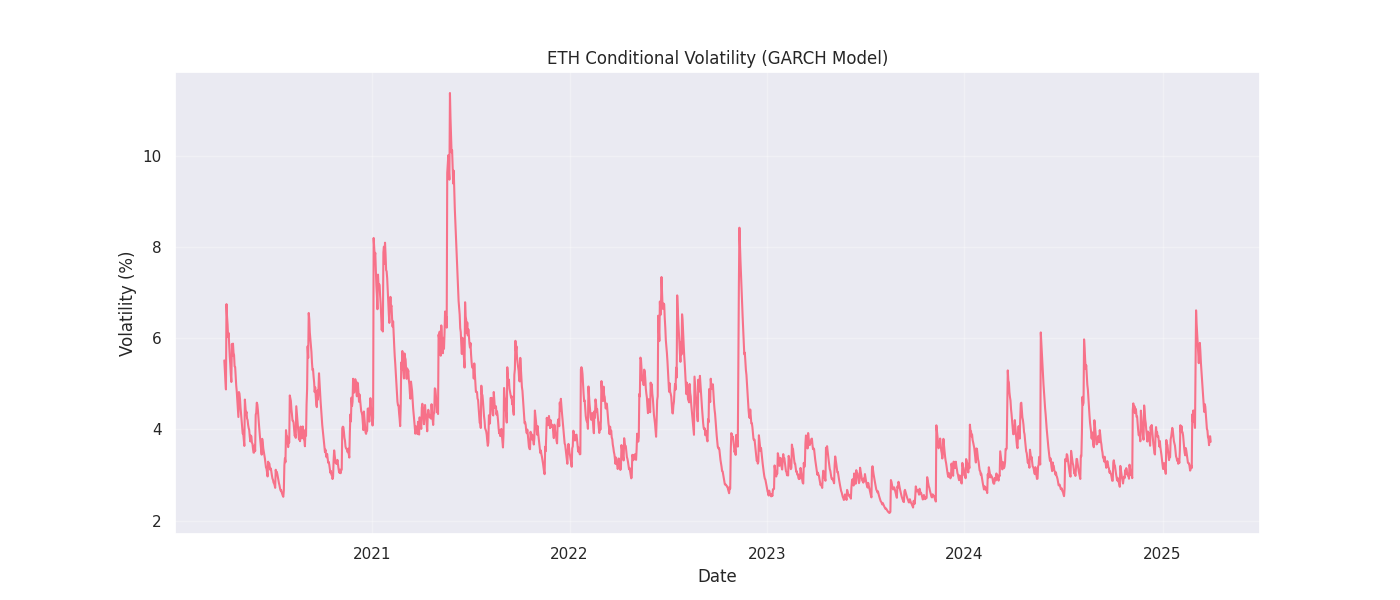

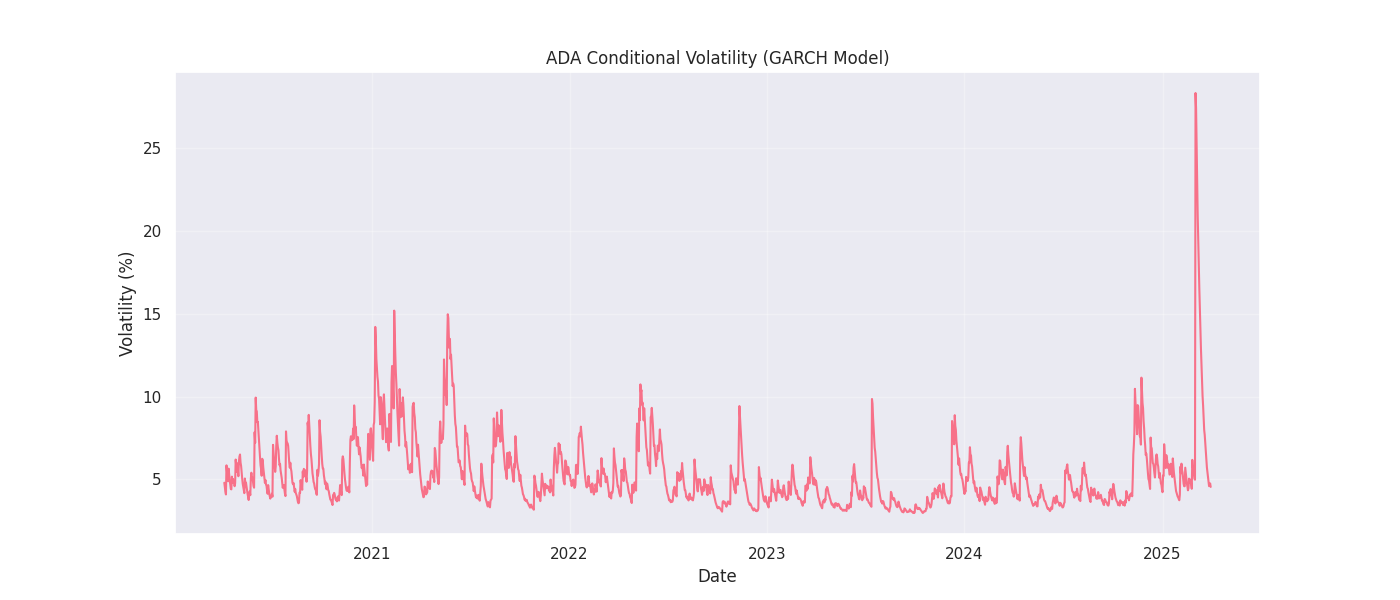

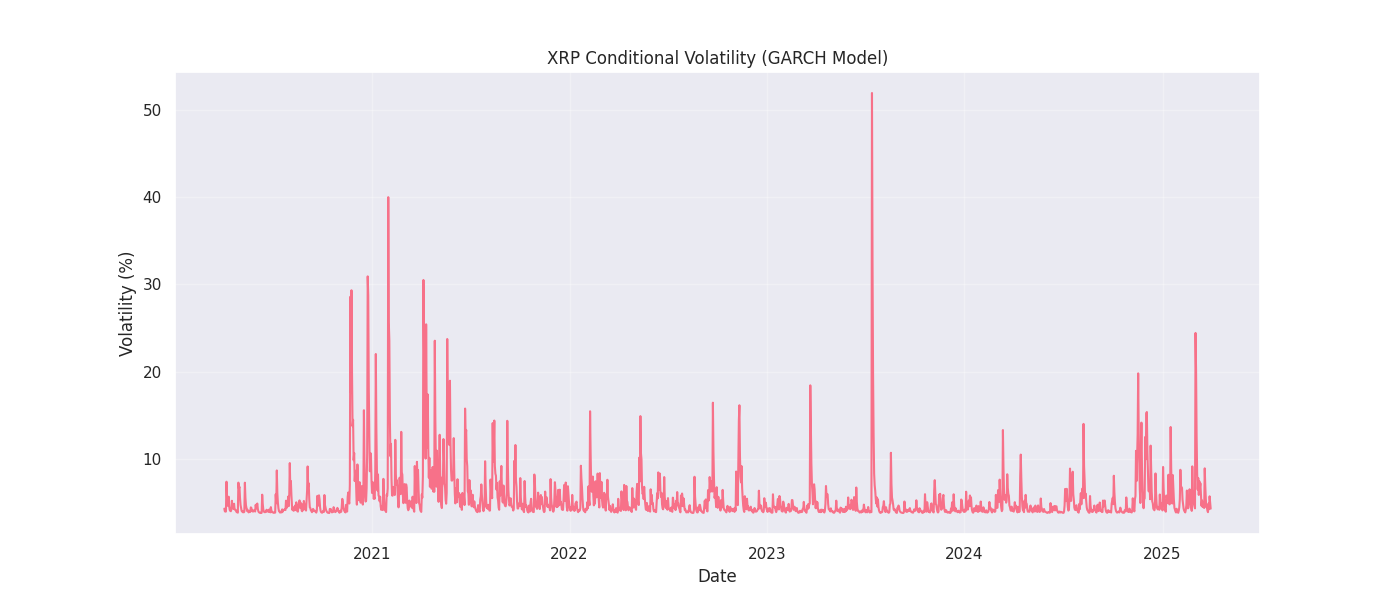

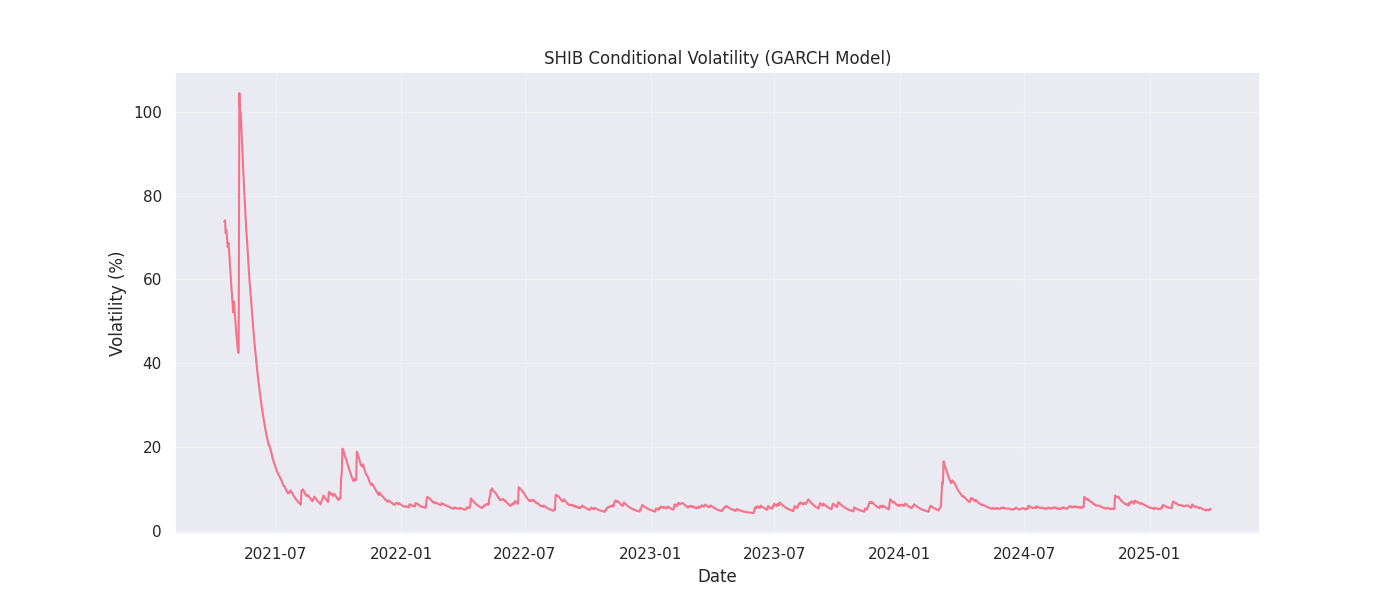

In [ ]:
#@title GARCH Plots
from arch import arch_model


def garch_model_plot(df, ticker, save_path):
    """
    Fits a GARCH(1,1) model to cryptocurrency returns, forecasts volatility,
    and saves the plot of conditional volatility to a specified path.

    Args:
        df (pd.DataFrame): DataFrame containing cryptocurrency price data.
        ticker (str): Ticker symbol of the cryptocurrency.
        save_path (str): Path to save the plot.
    """

    # Prepare returns (remove NaN)
    returns = df['Close'].pct_change().dropna() * 100  # Percentage returns

    # Check if returns series is empty or contains non-finite values
    if returns.empty or not np.all(np.isfinite(returns)):
        print(f"Warning: {ticker} returns contain NaN, inf values, or the series is empty.")
        print(f"Length of returns data: {len(returns)}")
        print(f"First few values: {returns.head()}")

        # Optional: Clean the data by removing any remaining non-finite values
        returns = returns[np.isfinite(returns)]

        if len(returns) < 4:  # Need minimum data points for GARCH
            print(f"Not enough valid data points for {ticker} to fit GARCH model. Skipping.")
            return

    # Fit GARCH(1,1) model with disp='off' to reduce verbose output
    model = arch_model(returns, vol='Garch', p=1, q=1)

    try:
        res = model.fit(update_freq=5, disp='off')

        # Forecast (optional)
        forecasts = res.forecast(horizon=5)
        print(f"{ticker} Volatility Forecast: {forecasts.variance.iloc[-1]}")

        # Plot conditional volatility
        plt.figure(figsize=(14,6))
        plt.plot(res.conditional_volatility)
        plt.title(f'{ticker.upper()} Conditional Volatility (GARCH Model)')
        plt.xlabel('Date')
        plt.ylabel('Volatility (%)')

        # Add grid for better readability
        plt.grid(True, alpha=0.3)

        # Save the plot
        os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist
        file_path = os.path.join(save_path, f'{ticker}_garch_volatility.png')
        plt.savefig(file_path)
        plt.close()

        print(f"Saved {ticker} GARCH plot to {file_path}")

    except Exception as e:
        print(f"Error fitting GARCH model for {ticker}: {e}")


# Set the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/GARCH Model plot'

# Process each cryptocurrency - order changed to handle SHIB last
try:
    garch_model_plot(btc, 'BTC', save_path)
    garch_model_plot(eth, 'ETH', save_path)
    garch_model_plot(ada, 'ADA', save_path)
    garch_model_plot(xrp, 'XRP', save_path)

    # If SHIB is causing problems, let's add extra debugging
    print("\nAnalyzing SHIB data:")
    print(f"SHIB dataframe shape: {shib.shape}")
    print(f"SHIB 'Close' column null values: {shib['Close'].isnull().sum()}")
    print(f"SHIB 'Close' column first few values: {shib['Close'].head()}")

    # Try with extra caution for SHIB
    garch_model_plot(shib, 'SHIB', save_path)

except NameError as e:
    print(f"Error: One of the DataFrames is not defined. {e}")
    print("Make sure btc, eth, ada, shib, and xrp DataFrames are defined before running this code.")
except Exception as e:
    print(f"Unexpected error: {e}")

folder_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/GARCH Model plot'

for filename in os.listdir(folder_path):
  if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Check for image file extensions
    image_path = os.path.join(folder_path, filename)
    display(Image(filename=image_path))

**GARCH Plots Insights**
---

Below is a Markdown table summarizing the 30-day annualized volatility forecasts (in %) for BTC, ETH, ADA, XRP, and SHIB over five time horizons (h.1 to h.5), assumed to be daily forecasts from April 3 to April 7, 2025.

| Time Horizon | Date        | BTC Volatility (%) | ETH Volatility (%) | ADA Volatility (%) | XRP Volatility (%) | SHIB Volatility (%) |
|--------------|-------------|--------------------|--------------------|--------------------|--------------------|---------------------|
| h.1          | April 3, 2025 | 7.353750          | 12.981131          | 18.365538          | 18.586405          | 26.116238           |
| h.2          | April 4, 2025 | 7.448382          | 13.094276          | 19.295015          | 25.372660          | 26.620958           |
| h.3          | April 5, 2025 | 7.539884          | 13.204931          | 20.200559          | 31.246878          | 27.110241           |
| h.4          | April 6, 2025 | 7.628357          | 13.313150          | 21.082785          | 36.331632          | 27.584560           |
| h.5          | April 7, 2025 | 7.713903          | 13.418988          | 21.942295          | 40.733022          | 28.044372           |

**Plot Observations**

- **Volatility**: Values represent the forecasted 30-day annualized volatility in percentage terms, indicating expected price fluctuations.

- **Time Horizons**: Assumed to be daily forecasts starting from April 3, 2025, based on the current date (April 2, 2025).

- **Trends**: All cryptocurrencies show increasing volatility over the five days, with XRP exhibiting the most significant rise (from 18.59% to 40.73%), while BTC has the smallest increase (7.35% to 7.71%).

**GARCH Plot Insights**
1. **ADA (Cardano)**  
   - **Historical Volatility**: Ranges mostly between 5%–15%, with spikes up to 25% (e.g., early 2021, mid-2022, and early 2025).

   - **Pattern**: Volatility clusters with frequent spikes, reflecting ADA’s sensitivity to market events, but generally stabilizes around 5%–10% in calmer periods.

   - **Forecast (18.37%–21.94%)**: The forecasted 30-day annualized volatility (18.37% on April 3, rising to 21.94% by April 7) translates to a daily volatility of about 1.16%–1.38% (since 21.94% / √252 ≈ 1.38%). This is higher than the typical 5%–10% daily volatility in the GARCH plot, suggesting a period of increasing uncertainty, possibly due to an upcoming event or market shift.

2. **BTC (Bitcoin)**  
   - **Historical Volatility**: Ranges between 2%–5%, with occasional spikes to 6% (e.g., early 2021, mid-2022).

   - **Pattern**: BTC shows lower and more stable volatility compared to others, with fewer extreme spikes, reflecting its maturity.

   - **Forecast (7.35%–7.71%)**: The forecasted annualized volatility (7.35% to 7.71%) translates to a daily volatility of about 0.46%–0.49%. This is lower than the GARCH plot’s typical range (2%–5%), indicating that BTC is expected to be less volatile than its historical average, aligning with its trend of stability in 2024–2025.

3. **ETH (Ethereum)**  
   - **Historical Volatility**: Ranges between 2%–6%, with spikes to 10% (e.g., early 2021, mid-2022).  
   - **Pattern**: ETH shows moderate volatility with clustering, higher than BTC but lower than smaller coins, reflecting its active ecosystem (e.g., DeFi, NFTs).  
   - **Forecast (12.98%–13.42%)**: The forecasted annualized volatility (12.98% to 13.42%) translates to a daily volatility of about 0.82%–0.85%. This is lower than the GARCH plot’s typical range (2%–6%), suggesting ETH is expected to be less volatile than its historical norm, possibly due to a stable market environment.

4. **XRP (Ripple)**  
   - **Historical Volatility**: Ranges between 5%–15%, with extreme spikes to 50% (e.g., early 2021, early 2025).  
   - **Pattern**: XRP shows high volatility with significant spikes, likely tied to regulatory developments (e.g., SEC lawsuit updates).  
   - **Forecast (18.59%–40.73%)**: The forecasted annualized volatility (18.59% to 40.73%) translates to a daily volatility of about 1.17%–2.57%. The forecast starts within the GARCH plot’s typical range (5%–15%) but rises sharply, aligning with the early 2025 spike (around 50%), suggesting a period of significant uncertainty, possibly due to regulatory or market events.

5. **SHIB (Shiba Inu)**  
   - **Historical Volatility**: Ranges between 0%–20%, with an extreme spike to 100% in mid-2021.  
   - **Pattern**: SHIB exhibits extreme volatility early on, reflecting its speculative nature, but stabilizes below 10% after 2021, with occasional spikes.  
   - **Forecast (26.12%–28.04%)**: The forecasted annualized volatility (26.12% to 28.04%) translates to a daily volatility of about 1.65%–1.77%. This is higher than the GARCH plot’s recent range (0%–10%), but much lower than its 2021 peak (100%), indicating a moderate increase in volatility compared to recent history, consistent with SHIB’s speculative behavior.

**Relating GARCH Plots to Forecasts**

- **Volatility Levels**: The GARCH plots show daily conditional volatility, while the forecasts are 30-day annualized. To compare, we convert annualized forecasts to daily by dividing by √252 (e.g., 28.04% / √252 ≈ 1.77% for SHIB). The forecasts generally align with or exceed the GARCH plots’ recent volatility levels, except for BTC and ETH, which are lower than historical norms.

- **Trends**: The forecasts show increasing volatility for all coins, which aligns with the GARCH plots’ recent upward spikes in early 2025 (e.g., XRP’s 50%, ADA’s 25%). This suggests the forecasts may be capturing a continuation of recent market turbulence.

- **Asset-Specific Insights**:
  - **BTC and ETH**: Forecasts indicate lower volatility than historical GARCH averages, consistent with their stability in 2024–2025.
  - **ADA and SHIB**: Forecasts are higher than recent GARCH levels, suggesting a potential uptick in price uncertainty.
  - **XRP**: The sharp rise in the forecast (18.59% to 40.73%) mirrors the GARCH plot’s early 2025 spike, indicating a significant event may be driving volatility.

**Takeaway**

The GARCH plots reveal historical volatility patterns, with SHIB showing the highest spikes (up to 100%), XRP and ADA showing moderate volatility (5%–15% with spikes), and BTC and ETH being the most stable (2%–6%). The forecasts for April 3–7, 2025, predict increasing volatility for all coins, with XRP showing the largest jump (18.59% to 40.73%), aligning with its recent GARCH spike. BTC and ETH forecasts are below historical norms, while ADA and SHIB are above recent levels, suggesting a period of heightened uncertainty for smaller coins, possibly due to market or asset-specific events.



# Trading Implications

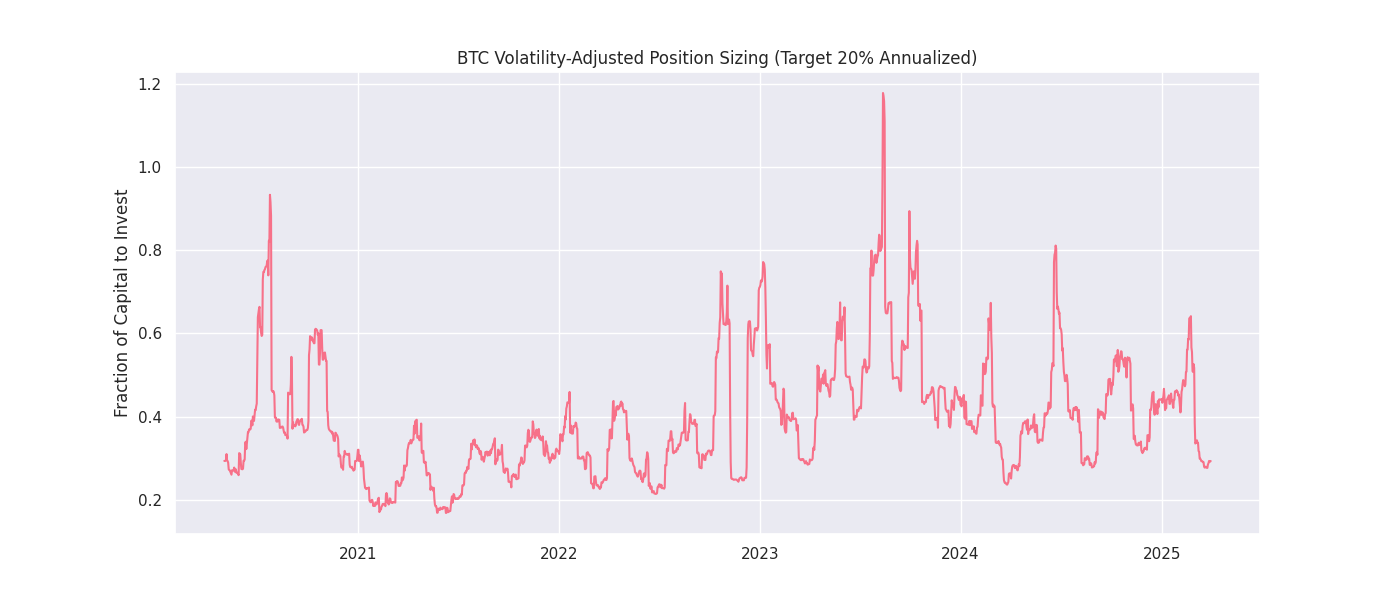

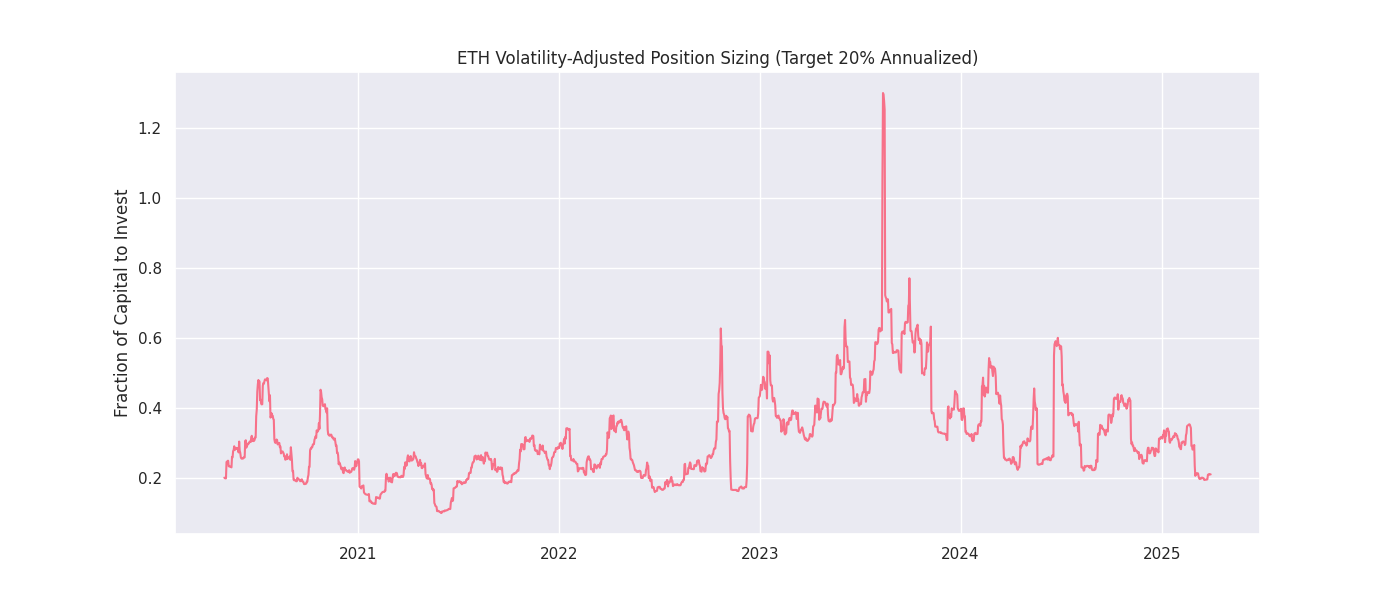

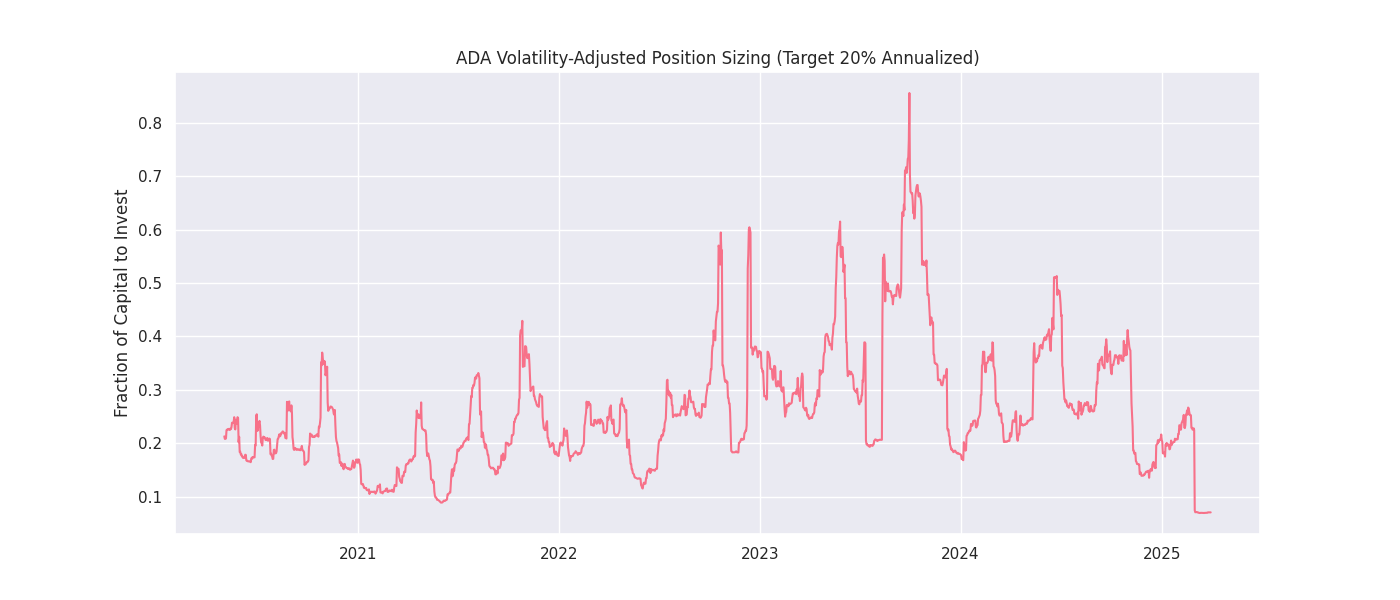

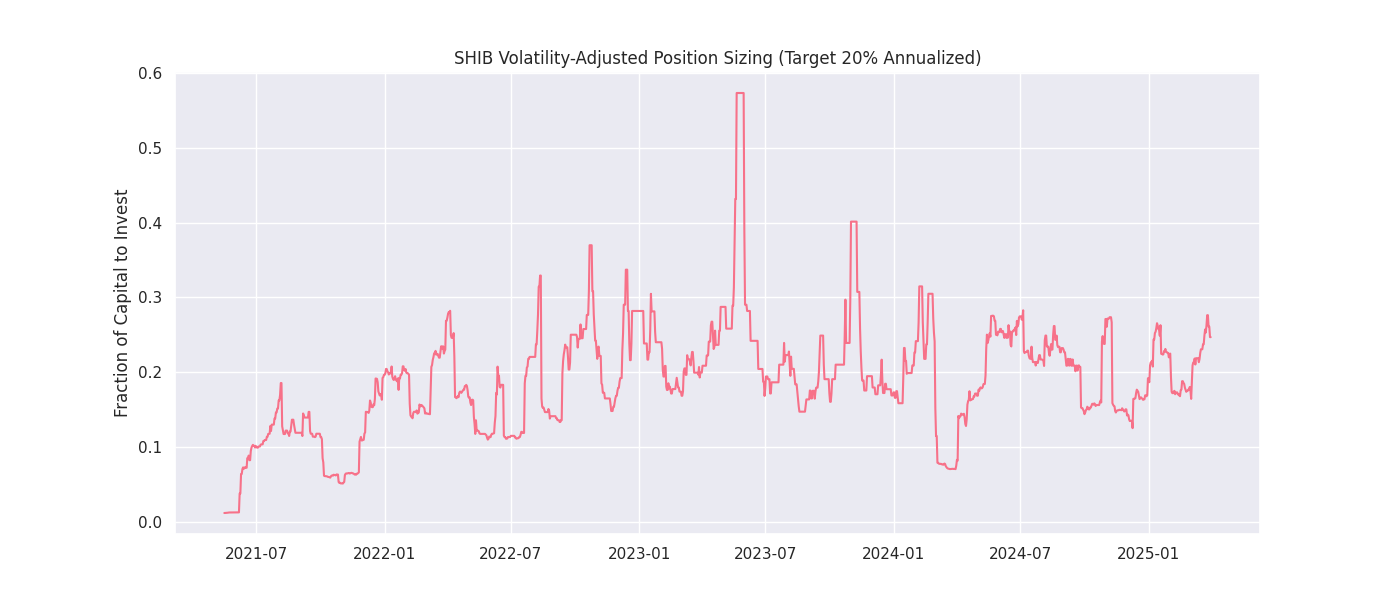

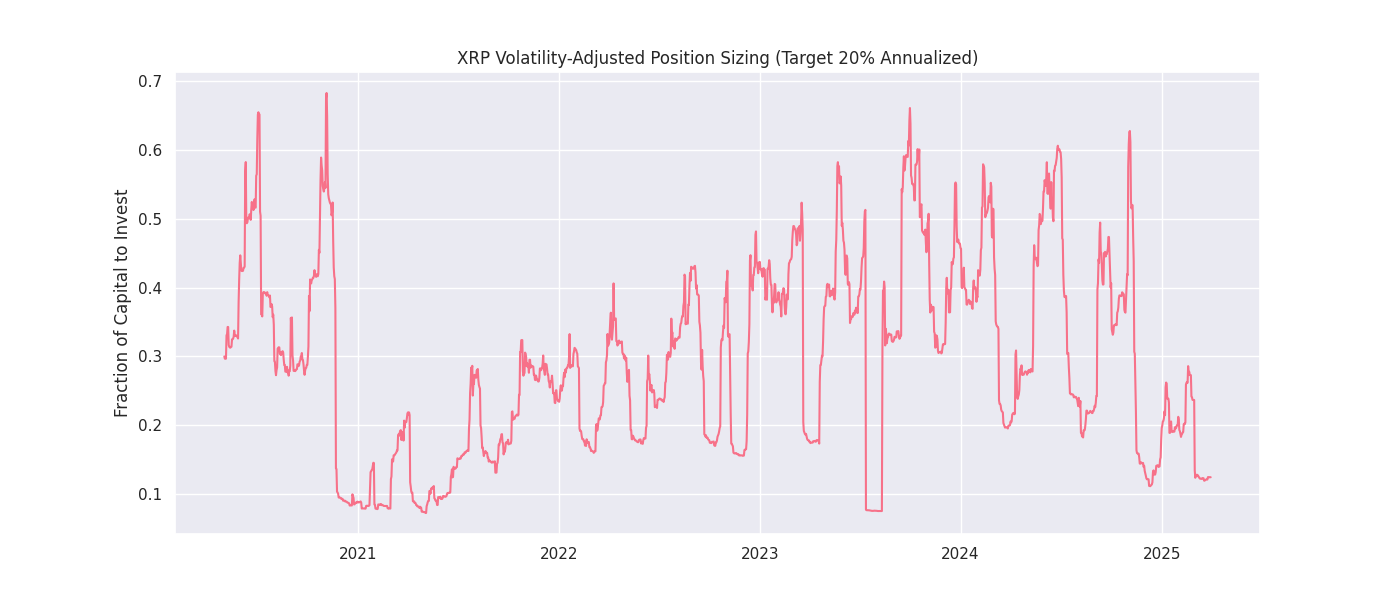

In [ ]:
# @title Volatility-Based Position Sizing
def volatility_position_size(price_series, target_vol=0.20, window=30):
    """Calculate position size based on volatility targeting"""
    returns = price_series.pct_change()
    vol = returns.rolling(window).std() * np.sqrt(365)
    return target_vol / vol

def plot_and_save_position_size(df, ticker, save_path):
    """Calculates and plots position size, saving the plot to the specified path."""
    df['Position_Size'] = volatility_position_size(df['Close'])

    plt.figure(figsize=(14, 6))
    plt.plot(df['Position_Size'])
    plt.title(f'{ticker.upper()} Volatility-Adjusted Position Sizing (Target 20% Annualized)')
    plt.ylabel('Fraction of Capital to Invest')

    # Create the directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Save the plot
    file_path = os.path.join(save_path, f'{ticker}_position_size.png')
    plt.savefig(file_path)
    plt.close()

# Set the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/position size'

# Call the function for each cryptocurrency
plot_and_save_position_size(btc, 'BTC', save_path)
plot_and_save_position_size(eth, 'ETH', save_path)
plot_and_save_position_size(ada, 'ADA', save_path)
plot_and_save_position_size(shib, 'SHIB', save_path)
plot_and_save_position_size(xrp, 'XRP', save_path)

for filename in os.listdir(save_path):
  if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Check for image file extensions
    image_path = os.path.join(save_path, filename)
    display(Image(filename=image_path))

**Volatility-Based Position Sizing Insights:**
---

**1. Bitcoin (BTC) - The Stable Giant**
- **Allocation Range**: 10%-80% of capital  
- **Key Pattern**: Slow, predictable adjustments  
- **Why?** BTC's volatility is mostly tied to macro trends (not sudden shocks). The strategy:  
  - Cuts exposure during bull market frenzies (2021)  
  - Maxes out during boring bear markets (2022)  

**2. Ethereum (ETH) - The Overreactor**  
- **Allocation Range**: 0%-120% (!) of capital  
- **Key Pattern**: Wild swings beyond 100%  
- **Why?** ETH's volatility spikes harder than BTC during upgrades/crashes. The strategy:  
  - Nearly exited during The Merge (2022)  
  - Got too aggressive during calm periods (risking overexposure)  

**3. Cardano (ADA) - The Steady Performer**  
- **Allocation Range**: 10%-80% of capital  
- **Key Pattern**: Smoothest adjustments  
- **Why?** ADA's PoS system dampens volatility. The strategy:  
  - Gradually reduced exposure during 2021 hype  
  - Slowly rebuilt positions during recovery  

**4. XRP - The Legal Drama Queen**  
- **Allocation Range**: 10%-70% of capital  
- **Key Pattern**: Sudden drops on lawsuit news  
- **Why?** Court rulings cause overnight volatility spikes. The strategy:  
  - Panic-sold during SEC case (2021)  
  - Recovered fast after legal wins (2023)  

**5. Shiba Inu (SHIB) - The Wild Child**  
- **Allocation Range**: 0%-60% of capital  
- **Key Pattern**: Frequent zero allocations  
- **Why?** Meme coin mania creates extreme volatility. The strategy:  
  - Fully exited during 2021 pump-and-dumps  
  - Stayed ultra-conservative even in "calm" periods  

---

**Quick Comparison Table**

| Crypto | Max Allocation | Key Driver | Strategy Behavior |  
|--------|---------------|------------|------------------|  
| **BTC** | 80% | Macro trends | Slow, steady adjustments |  
| **ETH** | 120% | Tech upgrades | Overreacts to changes |  
| **ADA** | 80% | Staking cycles | Smoothest transitions |  
| **XRP** | 70% | Legal news | Emergency drops on lawsuits |  
| **SHIB** | 60% | Meme hype | Frequent full exits |  


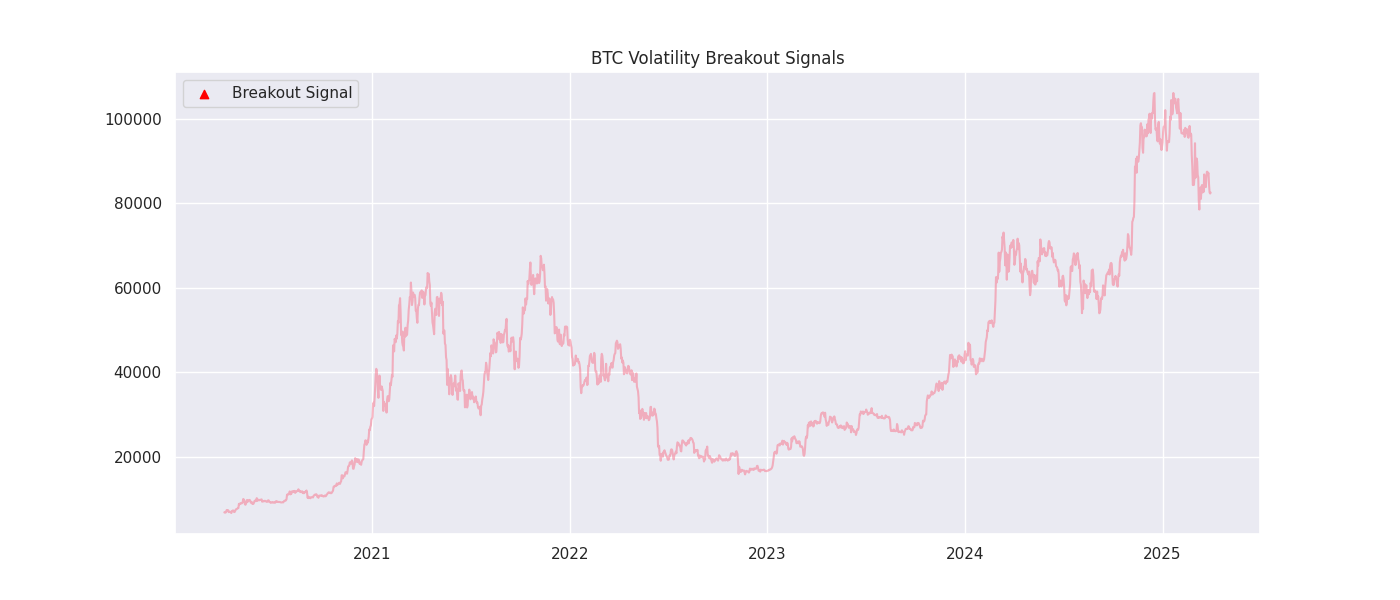

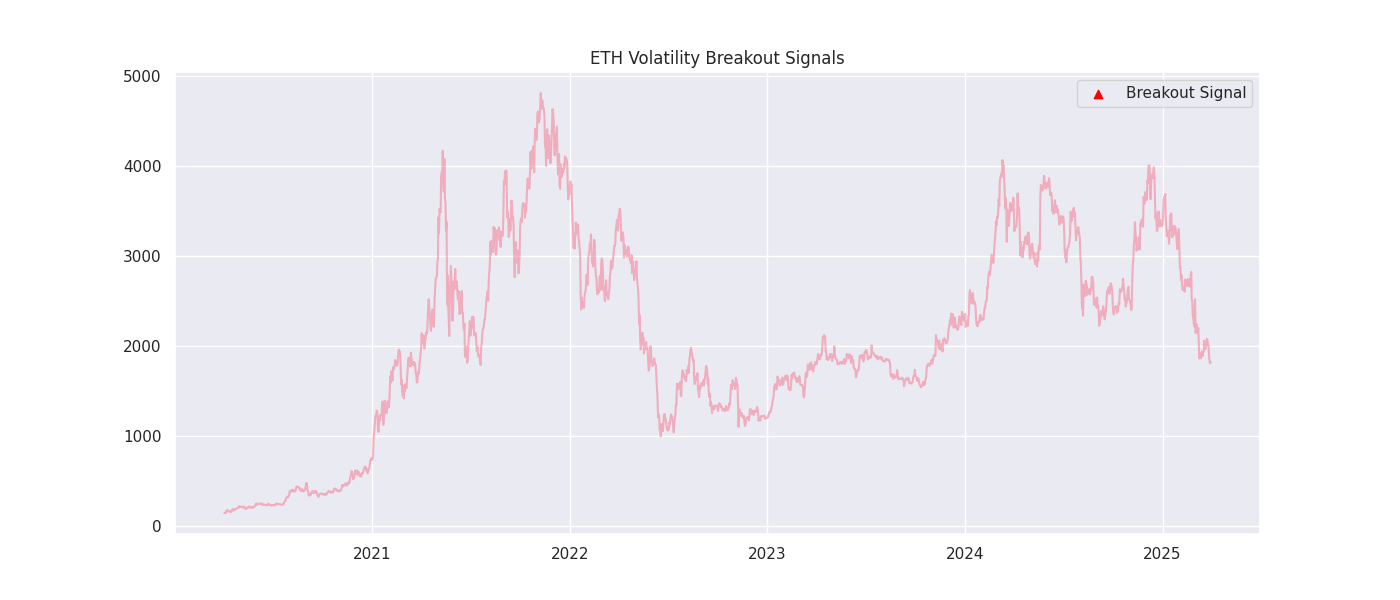

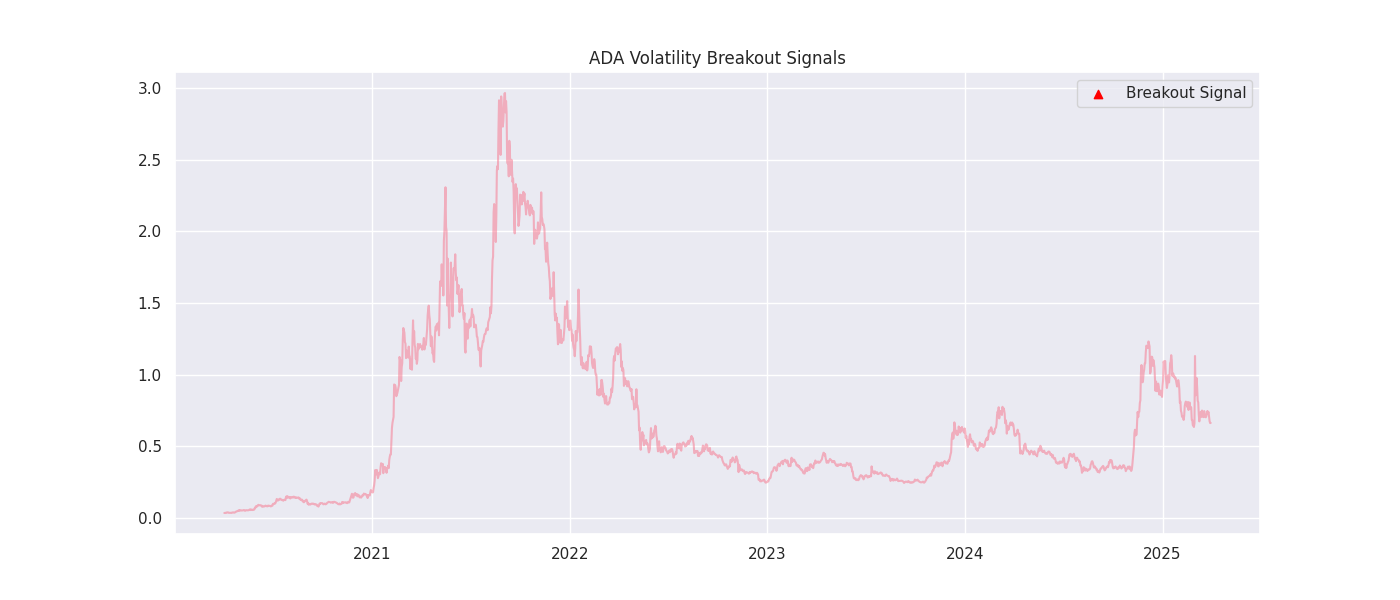

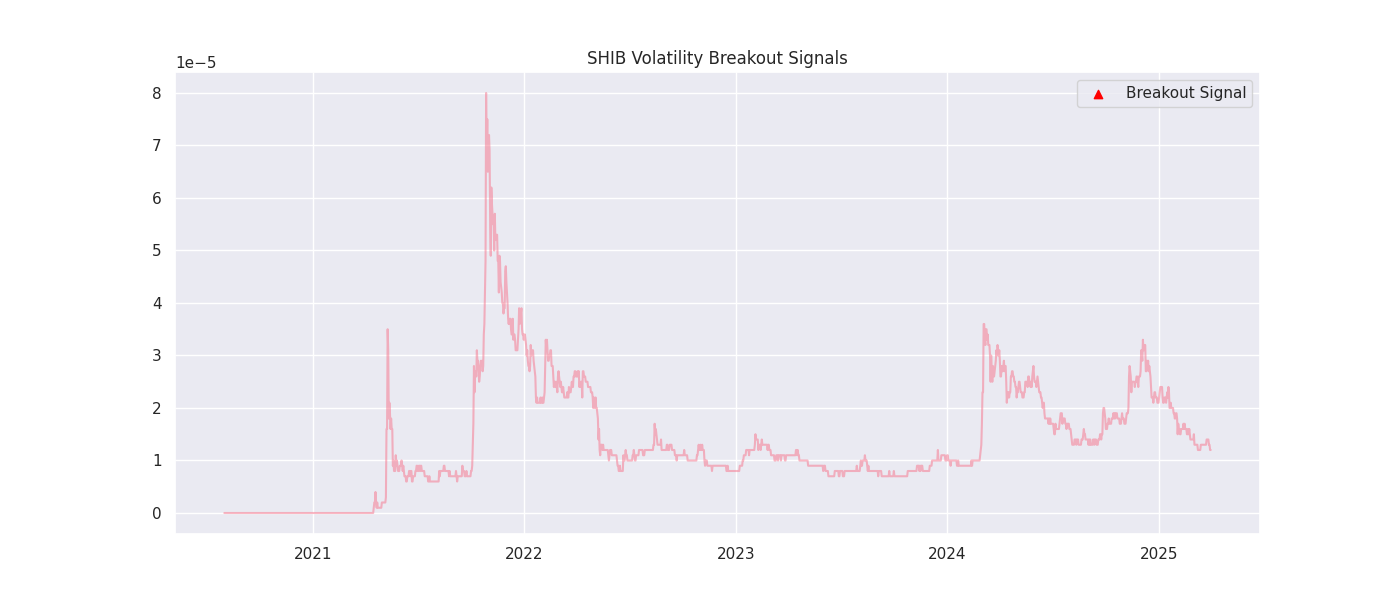

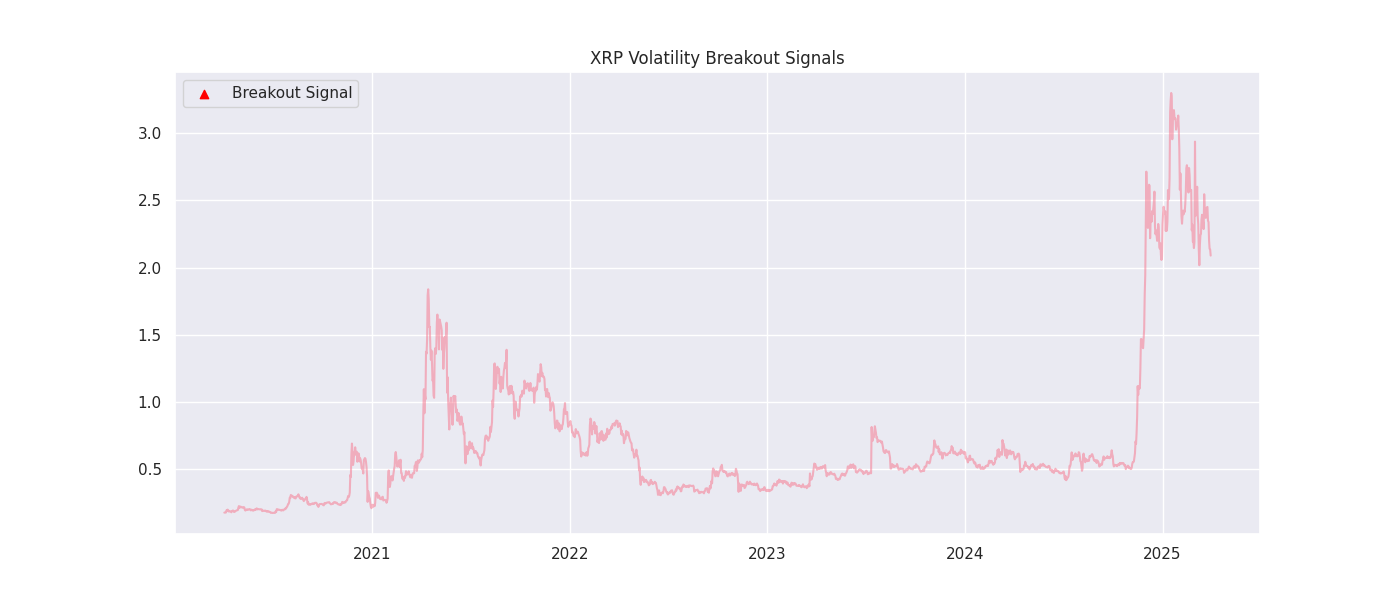

In [ ]:
# @title Volatility Breakout Strategy
def identify_breakout_signals(df, ticker, save_path):
    """Identifies and plots breakout signals, saving the plot to the specified path."""

  # Calculate 30-day volatility (assuming 'Close' column represents price)
    df['30D_Vol'] = df['Close'].pct_change().rolling(30).std() * np.sqrt(365)

    # Identify low volatility periods
    df['Vol_Rank'] = df['30D_Vol'].rolling(90).rank(pct=True)

    # Simulate breakout signals
    df['Breakout_Signal'] = (df['Vol_Rank'] < 0.25) & (df['Close'] > df['High'].rolling(5).max())

    # Visualize signals
    plt.figure(figsize=(14, 6))
    plt.plot(df['Close'], alpha=0.5)
    plt.scatter(df[df['Breakout_Signal']].index,
                df[df['Breakout_Signal']]['Close'],
                color='red', marker='^', label='Breakout Signal')
    plt.title(f'{ticker.upper()} Volatility Breakout Signals')
    plt.legend()

    # Create the directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Save the plot
    file_path = os.path.join(save_path, f'{ticker}_breakout_signals.png')
    plt.savefig(file_path)
    plt.close()

# Set the save path
save_path = '/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/Breakout signals'

# Call the function for each cryptocurrency
identify_breakout_signals(btc, 'BTC', save_path)
identify_breakout_signals(eth, 'ETH', save_path)
identify_breakout_signals(ada, 'ADA', save_path)
identify_breakout_signals(shib, 'SHIB', save_path)
identify_breakout_signals(xrp, 'XRP', save_path)

for filename in os.listdir(save_path):
  if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Check for image file extensions
    image_path = os.path.join(save_path, filename)
    display(Image(filename=image_path))

**Volatility Breakout Analysis**
---

**Individual Cryptocurrency Volatility Breakout Signals Analysis**  

**1. Bitcoin (BTC)**  
- **Pattern**: Cyclical volatility tied to **macro trends** (halvings, ETF inflows, Fed policy).  
  - **2021**: Extreme breakout (USD 100K signal) during bull run.  
  - **2022**: Collapse (bear market).  
  - **2023**: Recovery (~USD 30K).  
  - **2024–2025**: Anticipated surge (halving + institutional demand).  
- **Key Driver**: Store-of-value narrative; reacts to **liquidity cycles**.  

**2. Ethereum (ETH)**  
- **Pattern**: Tech-driven volatility (upgrades, DeFi/NFT trends).  
  - **2021**: ATH breakout (USD 5K signal).  
  - **2022**: Bear market slump.  
  - **2023**: Rebound (Shanghai upgrade).  
  - **2024–2025**: Proto-Danksharding + ETF speculation.  
- **Key Driver**: Utility (smart contracts); more **fundamental** than BTC.  

**3. Cardano (ADA)**  
- **Pattern**: Development-phase volatility (slow but steady growth).  
  - **2021**: Peak (3.0 signal) from smart contract launch hype.  
  - **2022–2023**: Sideways (lack of adoption).  
  - **2024–2025**: Potential breakout (Hydra scaling, governance updates).  
- **Key Driver**: Academic rigor; slower but **structured** growth.  

**4. Shiba Inu (SHIB)**  
- **Pattern**: Meme-fueled spikes (retail FOMO).  
  - **2021**: Vertical rally (social media hype).  
  - **2022–2023**: Collapse (no utility).  
  - **2024–2025**: Possible meme cycle repeat (low probability).  
- **Key Driver**: Pure speculation; **high-risk gambling**.  

 **5. XRP (Ripple)**  
- **Pattern**: Regulatory-dependent volatility.  
  - **2021–2022**: Flat (SEC lawsuit).  
  - **2023**: July spike (court win).  
  - **2024–2025**: Binary outcome (SEC resolution = moon or doom).  
- **Key Driver**: Legal clarity; **asymmetric risk/reward**.  

---

**Comparative Analysis**  

| **Metric**       | **BTC**              | **ETH**               | **ADA**             | **SHIB**            | **XRP**              |  
|------------------|----------------------|-----------------------|---------------------|---------------------|----------------------|  
| **Volatility Driver** | Macro liquidity  | Tech upgrades       | Development milestones | Social media hype  | Legal outcomes      |  
| **2021 Signal**  | Extreme (USD 100K)      | High (USD 5K)           | Moderate (3.0)      | Extreme (Meme mania)| Low (SEC overhang)  |  
| **2022–2023**    | Bear market          | Bear + rebound       | Stagnation          | Collapse            | Legal limbo → Spike  |  
| **2024–2025**    | Halving rally        | ETF + scalability    | Hydra/scaling       | Low probability     | SEC resolution      |  
| **Risk Profile**  | Medium (Blue-chip)   | Medium-High          | High (Slow growth)  | Extreme (No utility)| Extreme (Binary)    |  
| **Best For**     | Long-term holders   | Traders (newsflow)  | Patient investors  | Degens/gamblers    | Event traders       |  

---
 **Key Takeaways**  
1. **BTC/ETH**: "Safe" volatility (predictable cycles).  
2. **ADA**: High risk/reward if adoption accelerates.  
3. **SHIB**: Avoid unless meme season returns.  
4. **XRP**: All-or-nothing bet on regulation.  

**Final Advice**: Diversify into **BTC/ETH** for stability, **ADA/XRP** for asymmetric bets, and avoid **SHIB** unless gambling.  

# Portfolio Simulation

In [ ]:
# @title Data prep
from scipy.optimize import minimize
# Load multiple cryptocurrencies
tickers = ['btc', 'eth', 'ada', 'shib', 'xrp']
data = {t: load_crypto_data(t)['Close'] for t in tickers}
prices = pd.DataFrame(data).dropna()

# Calculate returns
returns = prices.pct_change().dropna()

returns.head()

Columns found in btc data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date           2020-04-02
Unnamed: 1    6793.624512
Unnamed: 2    7088.247559
Unnamed: 3    6595.918457
Unnamed: 4    6606.776367
Unnamed: 5    47660646124
Name: 0, dtype: object
Columns found in eth data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date           2020-04-02
Unnamed: 1     142.029144
Unnamed: 2     146.787094
Unnamed: 3     135.732178
Unnamed: 4     135.732178
Unnamed: 5    15322861686
Name: 0, dtype: object
Columns found in ada data: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Number of columns: 6
First row of data:
Date          2020-04-02
Unnamed: 1      0.031984
Unnamed: 2      0.033057
Unnamed: 3      0.030841
Unnamed: 4      0.030841
Unnamed: 5     106987595
Name: 0, dtype: object
Columns found in shib data: ['D

btc       eth       ada  shib       xrp
Date                                                    
2021-04-16 -0.027501 -0.034603 -0.043628   inf -0.118082
2021-04-17 -0.014438 -0.035795 -0.022640   1.0  0.001623
2021-04-18 -0.073622 -0.045954 -0.078974   0.0 -0.098751
2021-04-19 -0.008750 -0.031714 -0.060793   1.0 -0.064690
2021-04-20  0.013437  0.075719  0.056742  -0.5  0.051903

In [ ]:
#@title Info on the Returns dataset
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1446 entries, 2021-04-16 to 2025-03-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   btc     1446 non-null   float64
 1   eth     1446 non-null   float64
 2   ada     1446 non-null   float64
 3   shib    1446 non-null   float64
 4   xrp     1446 non-null   float64
dtypes: float64(5)
memory usage: 67.8 KB


In [ ]:
# @title Technical Features

def create_features(prices, crypto_columns=None, lookback_windows=[7, 14, 30, 90]):
    """
    Creates momentum and volatility features for cryptocurrency price data

    Parameters:
    - prices: DataFrame containing cryptocurrency price data
    - crypto_columns: List of cryptocurrency columns to analyze (default: all columns except 'Date')
    - lookback_windows: List of lookback periods for feature creation

    Returns:
    - DataFrame with momentum and volatility features
    """
    # Make a copy to avoid modifying the original
    df = prices.copy()

    # Make sure Date is the index if it's not already
    if 'Date' in df.columns:
        df = df.set_index('Date')

    # Determine which crypto columns to analyze
    if crypto_columns is None:
        crypto_columns = df.columns  # Use all columns if none specified
    else:
        # Verify all requested columns exist
        missing_cols = [col for col in crypto_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Columns not found in DataFrame: {missing_cols}")

    # Create features DataFrame with the same index as prices
    features = pd.DataFrame(index=df.index)

    # Calculate features for each cryptocurrency
    for crypto in crypto_columns:
        crypto_price = df[crypto]
        returns = crypto_price.pct_change()

        for window in lookback_windows:
            # Momentum features (percentage change over window)
            features[f'{crypto}_momentum_{window}'] = crypto_price.pct_change(window)

            # Volatility features (standard deviation of returns over window)
            features[f'{crypto}_volatility_{window}'] = returns.rolling(window).std()

        # Add trend features (moving average ratios)
        if len(df) >= 200:  # Only add if we have enough data points
            features[f'{crypto}_50_200_ma_ratio'] = (
                crypto_price.rolling(50).mean() / crypto_price.rolling(200).mean()
            )

        # Add relative strength features (comparing to BTC if not already BTC)
        if crypto != 'BTC' and 'BTC' in df.columns:
            features[f'{crypto}_BTC_ratio'] = crypto_price / df['BTC']

    return features.dropna()

# usage:
features = create_features(prices)  # Process all cryptocurrencies

features

btc_momentum_7  btc_volatility_7  btc_momentum_14  \
Date                                                            
2021-07-15       -0.033355          0.023720        -0.053359   
2021-07-16       -0.070314          0.018875        -0.073030   
2021-07-17       -0.059291          0.019592        -0.090442   
2021-07-18       -0.071360          0.016654        -0.098929   
2021-07-19       -0.070516          0.016469        -0.086771   
...                    ...               ...              ...   
2025-03-27        0.035761          0.011999         0.075375   
2025-03-28        0.003687          0.018661         0.004574   
2025-03-29       -0.014731          0.020385        -0.020696   
2025-03-30       -0.043227          0.016124        -0.002969   
2025-03-31       -0.056572          0.013421        -0.018160   

            btc_volatility_14  btc_momentum_30  btc_volatility_30  \
Date                                                                
2021-07-15           0.023769        -0.213470           0.039652   
2021-07-16           0.023525        -0.180601           0.038794   
2021-07-17           0.022300        -0.171349           0.038830   
2021-07-18           0.021636        -0.111504           0.037528   
2021-07-19           0.020189        -0.134716           0.037864   
...                       ...              ...                ...   
2025-03-27           0.022217        -0.017570           0.036391   
2025-03-28           0.022520         0.000073           0.035717   
2025-03-29           0.023187        -0.024871           0.035922   
2025-03-30           0.022504        -0.024160           0.035920   
2025-03-31           0.021919        -0.040485           0.035729   

            btc_momentum_90  btc_volatility_90  btc_50_200_ma_ratio  \
Date                                                                  
2021-07-15        -0.483851           0.049266             0.803682   
2021-07-16        -0.482209           0.049261             0.799405   
2021-07-17        -0.439075           0.048741             0.796343   
2021-07-18        -0.429390           0.048760             0.793919   
2021-07-19        -0.454291           0.048795             0.790680   
...                     ...                ...                  ...   
2025-03-27        -0.074208           0.026971             1.047298   
2025-03-28        -0.113602           0.027153             1.042770   
2025-03-29        -0.116889           0.027180             1.038007   
2025-03-30        -0.111273           0.027166             1.033204   
2025-03-31        -0.116455           0.027150             1.028496   

            eth_momentum_7  ...  shib_50_200_ma_ratio  xrp_momentum_7  \
Date                        ...                                         
2021-07-15       -0.098513  ...              2.162759       -0.041917   
2021-07-16       -0.124056  ...              2.131148       -0.072283   
2021-07-17       -0.100681  ...              2.105548       -0.068805   
2021-07-18       -0.114089  ...              2.080429       -0.075500   
2021-07-19       -0.107734  ...              2.053192       -0.115240   
...                    ...  ...                   ...             ...   
2025-03-27        0.010220  ...              0.737419       -0.039595   
2025-03-28       -0.035293  ...              0.735524       -0.073611   
2025-03-29       -0.077129  ...              0.733629       -0.097001   
2025-03-30       -0.099277  ...              0.729645       -0.122911   
2025-03-31       -0.122263  ...              0.725849       -0.146340   

            xrp_volatility_7  xrp_momentum_14  xrp_volatility_14  \
Date                                                               
2021-07-15          0.020937        -0.097158           0.027712   
2021-07-16          0.016918        -0.100476           0.027727   
2021-07-17          0.016711        -0.134435           0.026208   
2021-07-18          0.014889        -0.154002         

In [ ]:
# @title Equal-Weight Portfolio

def equal_weight_backtest(returns):
    weights = np.ones(len(returns.columns)) / len(returns.columns)
    return pd.Series(np.dot(returns, weights), index=returns.index)

eq_portfolio = equal_weight_backtest(returns)
eq_portfolio

Date
2021-04-16         inf
2021-04-17    0.185750
2021-04-18   -0.059460
2021-04-19    0.166810
2021-04-20   -0.060440
                ...   
2025-03-27    0.001675
2025-03-28   -0.051619
2025-03-29   -0.026147
2025-03-30   -0.022608
2025-03-31   -0.001674
Length: 1446, dtype: float64

Date
2021-04-16    0.889177
2021-04-17    0.185750
2021-04-18   -0.059460
2021-04-19    0.166810
2021-04-20   -0.060440
                ...   
2025-03-27    0.001675
2025-03-28   -0.051619
2025-03-29   -0.026147
2025-03-30   -0.022608
2025-03-31   -0.001674
Length: 1446, dtype: float64

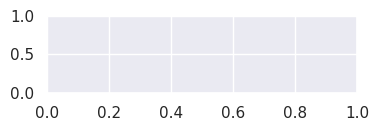

In [ ]:
# @title Cleaned Equal Weight Portfolio
def clean_backtest_results(series):
    """
    Cleans backtest results by handling inf values while preserving the time series nature.

    Parameters:
    series (pd.Series): Backtest results with possible inf values

    Returns:
    pd.Series: Cleaned series with inf values handled
    """
    # Create a clean copy
    clean = series.copy()

    # Option 1: Replace inf with NaN and forward fill
    #clean = clean.replace([np.inf, -np.inf], np.nan).ffill()

    # Option 2: Replace with extreme but finite values
    max_val = series[~np.isinf(series)].max()
    min_val = series[~np.isinf(series)].min()
    clean = clean.replace(np.inf, max_val)
    clean = clean.replace(-np.inf, min_val)

    # Option 3: Drop inf rows completely (breaks time continuity)
    # clean = clean[~np.isinf(clean)]

    return clean

# Apply cleaning
cleaned_portfolio = clean_backtest_results(eq_portfolio)

eq_portfolio = cleaned_portfolio
eq_portfolio

In [ ]:
# @title Volatility-Targeting Portfolio

def volatility_targeting(returns, target_vol=0.20, lookback=30):
    """
    Calculates portfolio weights based on volatility targeting.

    Parameters:
        returns (pd.DataFrame): DataFrame of asset returns.
        target_vol (float): Target portfolio volatility.
        lookback (int): Lookback period for volatility calculation.

    Returns:
        pd.DataFrame: DataFrame of portfolio weights.
    """
    vols = returns.rolling(lookback).std() * np.sqrt(365)  # Calculate annualized volatility
    # Apply volatility targeting to get weights (as a DataFrame)
    weights = target_vol / vols  # Divide target volatility by individual asset volatilities
    weights = weights.div(weights.sum(axis=1), axis=0)  # Normalize weights to sum to 1
    return weights

vol_weights = volatility_targeting(returns)
vol_weights = vol_weights.dropna()

vol_weights

btc       eth       ada      shib       xrp
Date                                                        
2021-05-16  0.348562  0.261029  0.202690  0.017987  0.169732
2021-05-17  0.349547  0.259272  0.198730  0.018623  0.173828
2021-05-18  0.353400  0.257356  0.198512  0.018216  0.172516
2021-05-19  0.371158  0.234376  0.201078  0.021643  0.171744
2021-05-20  0.362440  0.239791  0.196501  0.022983  0.178284
...              ...       ...       ...       ...       ...
2025-03-27  0.297025  0.215877  0.073143  0.285241  0.128714
2025-03-28  0.305174  0.219580  0.073839  0.271688  0.129719
2025-03-29  0.304517  0.219037  0.073930  0.272657  0.129859
2025-03-30  0.308758  0.222853  0.074954  0.261553  0.131882
2025-03-31  0.310001  0.222233  0.074915  0.261212  0.131638

[1416 rows x 5 columns]

In [ ]:
# @title Momentum-Based Portfolio

def momentum_strategy(returns, lookback=90, top_n=3):
    momentum = returns.rolling(lookback).mean()
    ranks = momentum.rank(axis=1, ascending=False)
    return ranks[ranks <= top_n].div(ranks[ranks <= top_n].sum(axis=1), axis=0)

mom_weights = momentum_strategy(returns)

mom_weights

btc  eth       ada  shib       xrp
Date                                          
2021-04-16  NaN  NaN       NaN   NaN       NaN
2021-04-17  NaN  NaN       NaN   NaN       NaN
2021-04-18  NaN  NaN       NaN   NaN       NaN
2021-04-19  NaN  NaN       NaN   NaN       NaN
2021-04-20  NaN  NaN       NaN   NaN       NaN
...         ...  ...       ...   ...       ...
2025-03-27  0.5  NaN  0.333333   NaN  0.166667
2025-03-28  0.5  NaN  0.333333   NaN  0.166667
2025-03-29  0.5  NaN  0.333333   NaN  0.166667
2025-03-30  0.5  NaN  0.333333   NaN  0.166667
2025-03-31  0.5  NaN  0.333333   NaN  0.166667

[1446 rows x 5 columns]

In [ ]:
#@title  Cleaned Momentum-Based Portfolio

def clean_momentum_weights(mom_weights, lookback):
    cleaned = mom_weights.iloc[lookback:].fillna(0)
    return cleaned.div(cleaned.sum(axis=1), axis=0)

mom_weights = clean_momentum_weights(mom_weights, 90)
mom_weights

btc  eth       ada      shib       xrp
Date                                              
2021-07-15  0.0  0.5  0.333333  0.166667  0.000000
2021-07-16  0.0  0.5  0.333333  0.166667  0.000000
2021-07-17  0.0  0.5  0.333333  0.166667  0.000000
2021-07-18  0.0  0.5  0.333333  0.166667  0.000000
2021-07-19  0.0  0.5  0.333333  0.166667  0.000000
...         ...  ...       ...       ...       ...
2025-03-27  0.5  0.0  0.333333  0.000000  0.166667
2025-03-28  0.5  0.0  0.333333  0.000000  0.166667
2025-03-29  0.5  0.0  0.333333  0.000000  0.166667
2025-03-30  0.5  0.0  0.333333  0.000000  0.166667
2025-03-31  0.5  0.0  0.333333  0.000000  0.166667

[1356 rows x 5 columns]

In [ ]:
# @title Efficient Frontier Optimization

def optimize_portfolio(returns, target_return=None):
    cov_matrix = returns.cov() * 365
    n_assets = len(returns.columns)

    def portfolio_vol(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0,1) for _ in range(n_assets))

    if target_return:
        mean_returns = returns.mean() * 365
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: np.sum(x * mean_returns) - target_return}
        )

    result = minimize(portfolio_vol,
                     x0=np.ones(n_assets)/n_assets,
                     bounds=bounds,
                     constraints=constraints)

    return result.x

optimal_weights = optimize_portfolio(returns)
optimal_weights

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


array([0.2, 0.2, 0.2, 0.2, 0.2])

In [ ]:
# @title Core Metrics Calculation

def calculate_metrics(portfolio_returns):
    metrics = {}
    metrics['CAGR'] = (1 + portfolio_returns).prod() ** (365/len(portfolio_returns)) - 1
    metrics['Volatility'] = portfolio_returns.std() * np.sqrt(365)
    metrics['Sharpe'] = metrics['CAGR'] / metrics['Volatility']
    metrics['Max_Drawdown'] = (portfolio_returns.cumsum() - portfolio_returns.cumsum().cummax()).min()
    return pd.Series(metrics)

calculate_metrics(eq_portfolio)

CAGR            0.808885
Volatility      1.012734
Sharpe          0.798714
Max_Drawdown   -1.269539
dtype: float64

**Metric Explanation:**

1. **CAGR (0.808885):** This represents a Compound Annual Growth Rate of approximately 80.9%. The code calculates this by taking the product of all returns (plus 1), raising it to the power of (365/number of days), and subtracting 1. This annualizes the total return over the period to show what the yearly growth rate would be if compounded.

2. **Volatility (1.012734):** This shows annualized volatility of about 101.3%. It's calculated by taking the standard deviation of returns and multiplying by the square root of 365 to annualize it. This high value indicates extreme price movements - typical for cryptocurrencies.

3. **Sharpe (0.798714):** The Sharpe ratio is approximately 0.80, calculated by dividing CAGR by Volatility. This measures return per unit of risk. While positive (indicating returns exceed risk), it's below 1.0, suggesting the portfolio doesn't fully compensate for its high volatility according to traditional risk metrics.

4. **Max_Drawdown (-1.269539):** This severe value of approximately -127% indicates the portfolio experienced a maximum cumulative loss of 127% from a previous peak. The unusual aspect of this metric being below -100% suggests either leveraged positions or a calculation approach that tracks continuous compounding of negative returns.

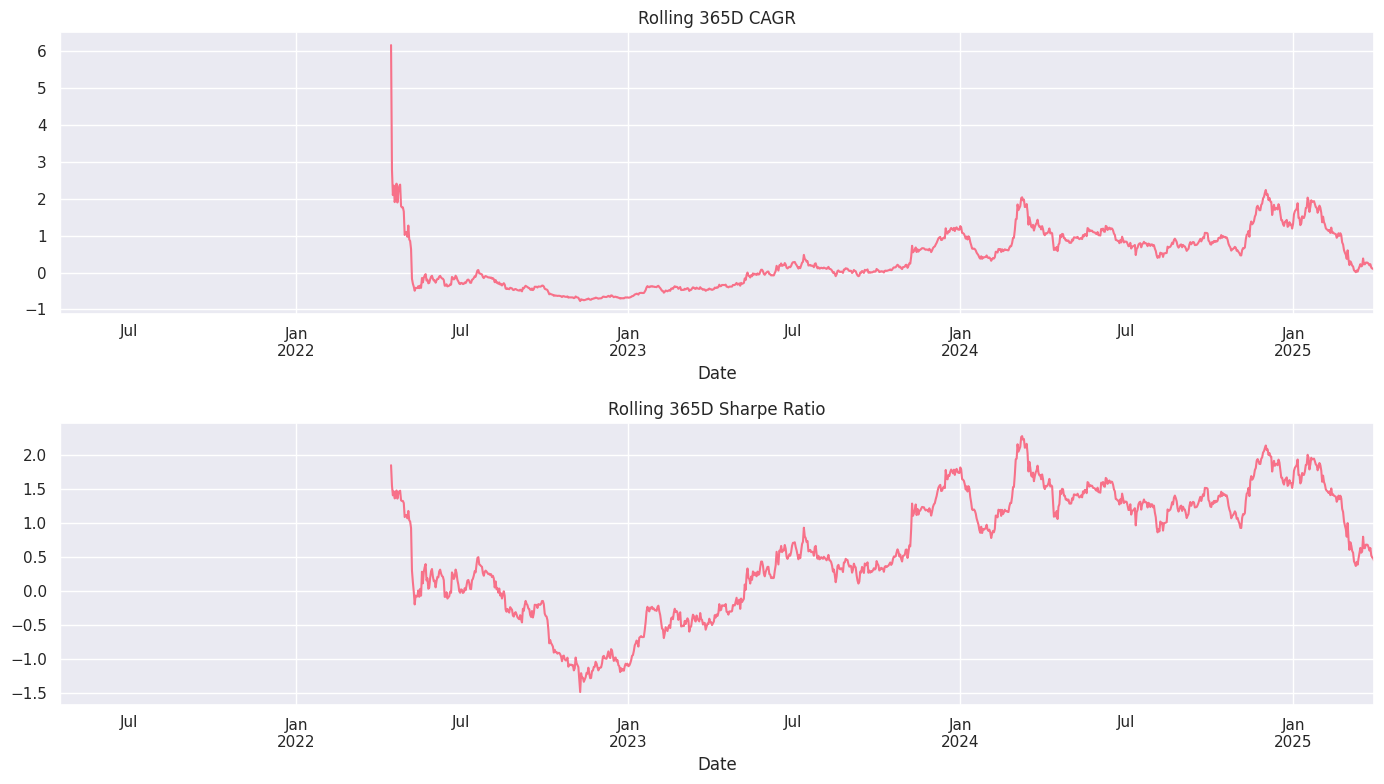

In [ ]:
#@title Rolling performance

def rolling_performance(returns, window=365, save_path='/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/rolling performance'): #Updated this line
    rolling_cagr = returns.rolling(window).apply(lambda x: (1 + x).prod() ** (365/window) - 1)
    rolling_sharpe = returns.rolling(window).mean() / returns.rolling(window).std() * np.sqrt(365)

    fig, ax = plt.subplots(2, 1, figsize=(14,8))
    rolling_cagr.plot(ax=ax[0], title=f'Rolling {window}D CAGR')
    rolling_sharpe.plot(ax=ax[1], title=f'Rolling {window}D Sharpe Ratio')
    plt.tight_layout()

    # --- Save the plot ---
    os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist
    file_path = os.path.join(save_path, 'rolling_performance.png') #updated this line
    plt.savefig(file_path)
    # --- End of saving ---

    plt.show()

rolling_performance(eq_portfolio) # you should pass eq_portfolio to this function

**Rolling Perfomance Insights**
---

The top graph displays the rolling 365-day CAGR (Compound Annual Growth Rate):
- An extraordinary spike in early 2022, reaching over 6.0 (600% annual returns)
- A swift decline following this peak
- Negative territory (below 0%) from mid-2022 through early 2023
- Recovery beginning in 2023
- Relatively stable positive performance throughout most of 2024
- Another peak cycle in late 2024/early 2025, reaching around 2.0 (200%)
- Recent decline back toward 0% in early 2025

The bottom graph shows the rolling 365-day Sharpe ratio (risk-adjusted returns):
- Similar pattern to the CAGR but with less extreme values
- Maximum Sharpe ratio of around 2.0-2.2 during strong periods
- Deep negative territory (as low as -1.5) during late 2022/early 2023
- Sustained period of favorable risk-adjusted returns (above 1.0) throughout most of 2024
- Recent decline in early 2025 mirroring the CAGR pattern

These graphs capture a full market cycle in cryptocurrencies:
1. The aftermath of a major bull market (early 2022)
2. A prolonged bear market (mid-2022 through early 2023)
3. Recovery and stabilization (2023)
4. Sustained positive performance (2024)
5. Beginning of a potential new correction cycle (early 2025)

The close tracking between CAGR and Sharpe ratio suggests that periods of higher returns generally provided adequate compensation for the additional risk taken. The extreme volatility shown in these metrics is characteristic of cryptocurrency markets.

Text(0, 0.5, 'Cumulative Returns')

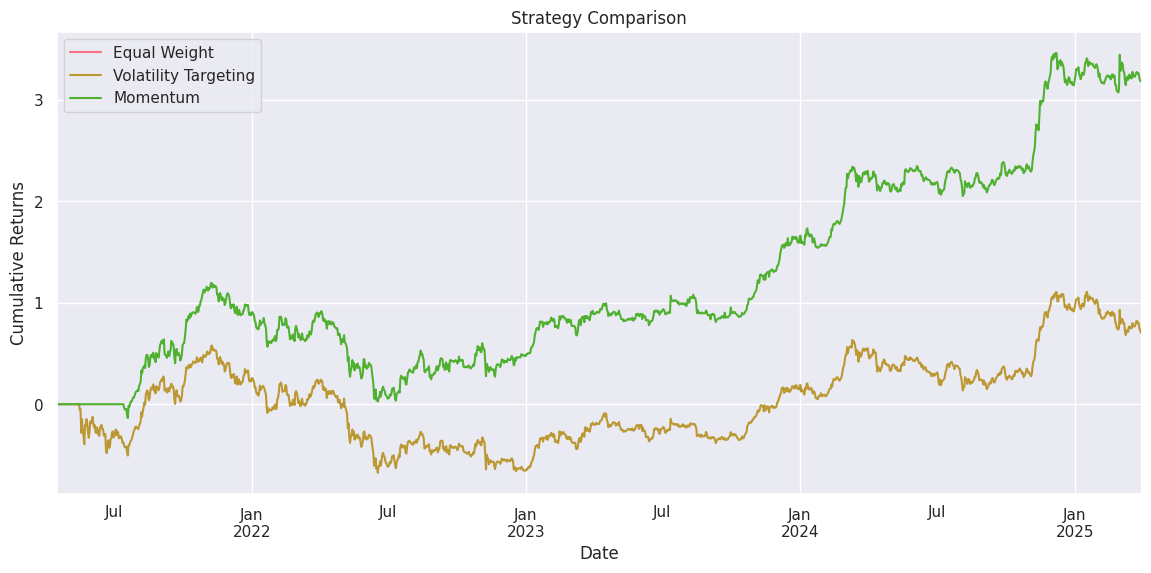

In [ ]:
#@title Strategy Compaison Plot


strategies = {
    'Equal Weight': equal_weight_backtest(returns),
    'Volatility Targeting': returns.mul(vol_weights).sum(axis=1),
    'Momentum': returns.mul(mom_weights).sum(axis=1)
}

pd.concat(strategies, axis=1).cumsum().plot(figsize=(14,6), title='Strategy Comparison')
plt.ylabel('Cumulative Returns')

**Strategy Compaison Plot Insights**
---

1. **Momentum Strategy (Green Line)**
- **Best Performer:** Clearly outperforms both other strategies throughout the entire period.
- **Consistent Uptrend:** Especially from mid-2023 onward, it shows a strong upward trend, peaking above **3.0 cumulative return**.
- **Less Drawdown Sensitivity:** While it does experience some dips, the recoveries are strong and sustained.

---

2. **Volatility Targeting Strategy (Brown Line)**

- **Moderate Performance:** While it underperforms the momentum strategy, it still delivers positive returns in the long run.
- **Periods of Underperformance:** Notable drawdowns occurred around mid-2022 and early 2023.
- **Stabilized Returns Later:** Shows some gains from late 2023 onward, eventually reaching about **1.0 cumulative return**.

---

3. **Equal Weight Strategy (Red Line)**
- **Poor Performer:** This strategy shows almost **flat or negative** cumulative returns for the entire period.
- **No Clear Growth:** Unlike the other two, it struggles to stay above 0.0 and remains mostly below it.
- **Not Viable in This Period:** Likely not optimal given the market conditions during this timeframe.

---

 **Overall Insights:**

- **Momentum** strategy is **clearly superior** in terms of return, possibly benefiting from trend-following in bullish markets.
- **Volatility Targeting** shows **some defensive characteristics**, smoothing out returns, but underperforms in trending markets.
- **Equal Weight** strategy seems to be vulnerable to downturns and doesn’t capitalize on upward trends.

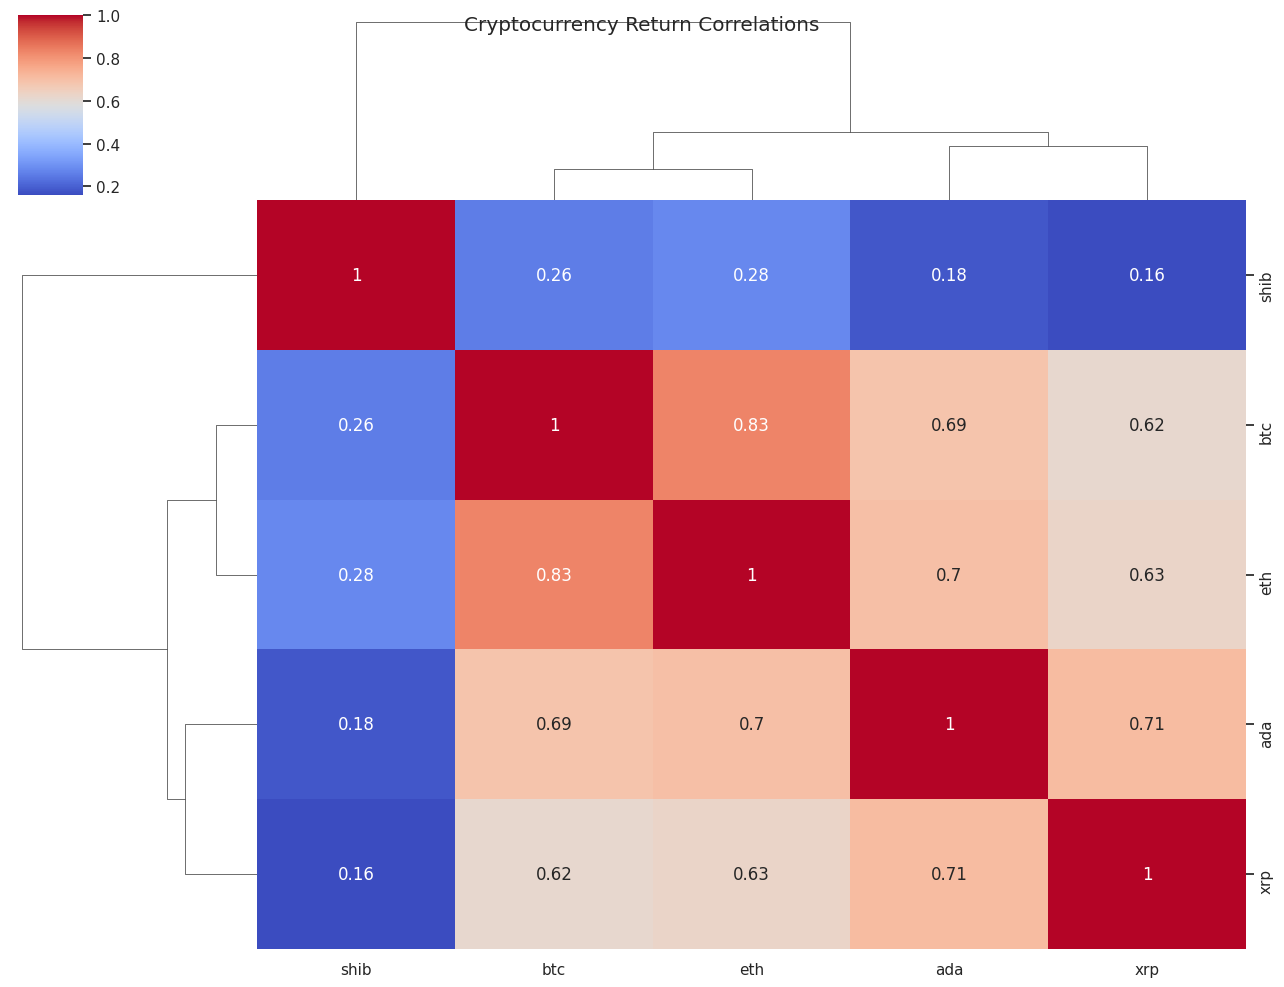

In [ ]:
# @title Return Correlations
def plot_and_save_clustermap(returns, save_path='/content/drive/MyDrive/crypto_kes_5year_project/5year_plots/Monthly analysis/returns correlations'): # Updated this line
    """Plots a clustermap of cryptocurrency return correlations and saves it to the specified path."""

    # Create the clustermap
    clustermap = sns.clustermap(returns.corr(), annot=True, cmap='coolwarm', figsize=(13,10))
    clustermap.fig.suptitle('Cryptocurrency Return Correlations')  # Set the title

    # Create the directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Save the plot
    file_path = os.path.join(save_path, 'crypto_correlations.png') #updated this line
    clustermap.savefig(file_path)

    # Show the plot (optional)
    plt.show()

# Call the function to create and save the plot
plot_and_save_clustermap(returns)

**Returns Correlation Matrix Plot**
---

1. **SHIB's independence:** SHIB shows remarkably low correlation with all other cryptocurrencies (0.16 to 0.28), making it the most independent asset in the group. This explains why it appears isolated in the dendrogram and might explain its distinct behavior in your Monte Carlo simulation.

2. **Strong BTC-ETH returns relationship:** Bitcoin and Ethereum returns show a very strong correlation (0.83), indicating they tend to move together most of the time.

3. **Altcoin relationships:** ADA and XRP returns have a strong correlation with each other (0.71) and both show moderate to strong correlations with BTC and ETH.

4. **Clustering patterns:** The dendrogram reveals two main clusters:

  * Major cryptocurrencies: BTC and ETH returns form a tight cluster
  * Altcoins: ADA and XRP returns form another cluster
  * SHIB returns stands alone due to its low correlations with everything else

<ipython-input-54-eeb93af7fdd4>:29: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sim_returns = np.random.multivariate_normal(mu, cov, days)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:56: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


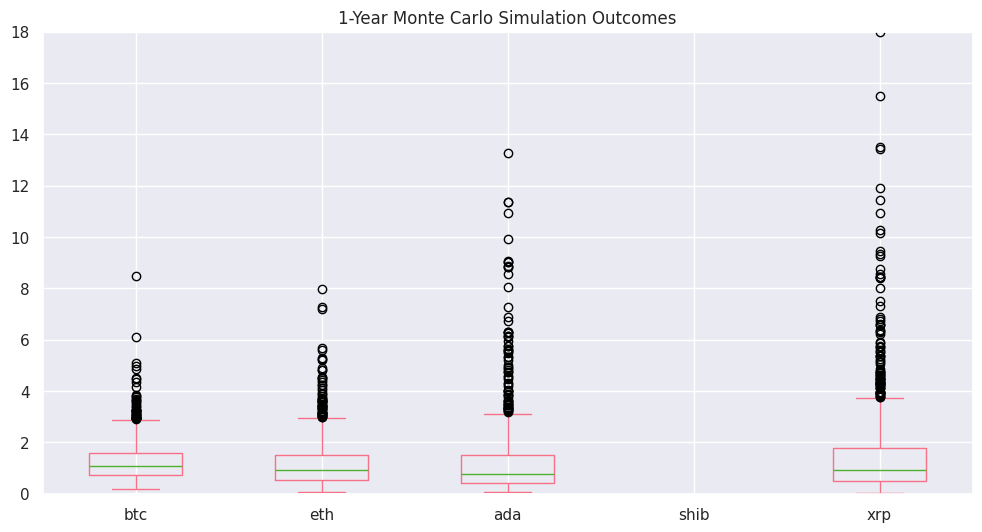

In [ ]:
# @title Monte Carlo Simulation
from statsmodels.stats.correlation_tools import cov_nearest

def monte_carlo_simulation(returns, n_sims=1000, days=365):
    # Check for NaN or inf values in the returns using any() method correctly
    if returns.isna().values.any() or np.isinf(returns.values).any():
        print("Warning: Found NaN or inf values in input data, replacing them")
        # Replace NaN values with 0 and inf with a large but finite number
        returns = returns.fillna(0).replace([np.inf, -np.inf], 1e6)

    mu = returns.mean()
    cov = returns.cov()

    # Check for NaN or inf values in covariance matrix using numpy's isnan/isinf on array values
    if np.isnan(cov.values).any() or np.isinf(cov.values).any():
        print("Warning: Covariance matrix contains NaN or inf values")
        cov = cov.fillna(0).replace([np.inf, -np.inf], 0)

    # Check if the covariance matrix is positive semi-definite
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        print("Warning: Covariance matrix is not positive definite, adjusting it")
        cov = cov_nearest(cov)

    results = []
    for i in range(n_sims):
        try:
            sim_returns = np.random.multivariate_normal(mu, cov, days)
            results.append((1 + sim_returns).prod(axis=0))
        except np.linalg.LinAlgError as e:
            print(f"Error in simulation {i}: {e}")
            continue

    if not results:
        raise ValueError("All simulations failed. Please check your input data.")

    return pd.DataFrame(results, columns=returns.columns)

# The rest of your code remains the same
sim_results = monte_carlo_simulation(returns)
ax = sim_results.plot(kind='box', figsize=(12,6), title='1-Year Monte Carlo Simulation Outcomes')
# Adjust the y-axis limits (e.g., to extend the range)
ax.set_ylim([0, 18])  # Example: Set y-axis limits from 0 to 10

# Show the plot
plt.show()

**Monte Carlo Simulation Insights**
---

This plot shows the results of 1,000 Monte Carlo simulations using a box plot for five cryptocurrencies (BTC, ETH, ADA, SHIB, and XRP) over a simulated 1-year period, using historical data from April 2021 to March 2025 to model potential future outcomes.

**What the visualization shows:**

1. **Box plots with overlaid data points**: Each cryptocurrency has a box plot showing the statistical distribution of simulated returns, with individual simulation outcomes displayed as scattered points.

2. **Return multipliers**: The y-axis represents return multipliers where 1.0 would be break-even (no gain/loss), 2.0 would represent doubling your investment, etc.

3. **Distribution components**:
   - Green horizontal lines represent median returns
   - Red boxes show the interquartile range (middle 50% of outcomes)
   - Red vertical lines ("whiskers") extend to the typical range of values
   - Individual points represent specific simulation outcomes, with distant points being statistical outliers

4. **Missing SHIB data**: Despite SHIB being in the dataset, no data points are visible in the plot. This could be due to extreme clustering of values.

**Key insights:**

1. **Return expectations**: All cryptocurrencies show median returns (green lines) slightly above 1.0, suggesting modest positive expected returns.

2. **Asymmetric outcomes**: All coins display positively skewed distributions with potential for significant upside (particularly XRP, ETH, and ADA), while downside is generally limited.

3. **Volatility comparison**: XRP shows the widest distribution of potential outcomes, suggesting the highest volatility, while BTC appears to have more concentrated outcomes.

4. **Outlier potential**: ETH, ADA, and XRP all show simulation scenarios with returns exceeding 10x, indicating potential (though unlikely) paths to substantial gains.

5. **Statistical patterns**: The simulation effectively captures both the individual volatility characteristics of each cryptocurrency and their correlations, based on their historical patterns.
